In [6]:
import torch
import time
import pandas as pd
import numpy as np  
import os
import itertools
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    TrainerCallback,
    EarlyStoppingCallback, 
    TrainerState, 
    TrainerControl
)
from sklearn.model_selection import train_test_split
from datasets import Dataset
from datasets import load_dataset, load_metric
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType, PrefixTuningConfig, IA3Config
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import wandb
WANDB_API_KEY = os.environ.get("WANDB_API_KEY", None)
wandb.login(key=WANDB_API_KEY)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [7]:
model_name = "EMBEDDIA/sloberta"
# Load the dataset
dataset = load_dataset('csv', data_files={
    'train': 'SuperGLUE-HumanT/csv/RTE/train.csv',
    'validation': 'SuperGLUE-HumanT/csv/RTE/val.csv'
})

# Tokenization
tokenizer = AutoTokenizer.from_pretrained(model_name)
def preprocess_function(examples):
    return tokenizer(examples['premise'], examples['hypothesis'], truncation=True, padding='max_length', max_length=512)
dataset = dataset.map(preprocess_function, batched=True)

# Here you split the validation set into validation and test sets
test_train_split = dataset['validation'].train_test_split(test_size=0.5)
# Now you need to add these new sets back into your dataset
dataset['validation'] = test_train_split['train']
dataset['test'] = test_train_split['test']

# Now continue with label mapping
def label_mapping(example):
    label_dict = {'not_entailment': 0, 'entailment': 1}
    example['labels'] = label_dict[example['label']]
    return example
dataset = dataset.map(label_mapping)

# Set format for PyTorch
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])



In [8]:
class MemoryUsageCallback(TrainerCallback):
    def __init__(self, log_file):
        self.log_file = log_file
        self.memory_usage = []

    def on_step_end(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, **kwargs):
        if torch.cuda.is_available():
            allocated_memory = torch.cuda.memory_allocated()
            reserved_memory = torch.cuda.memory_reserved()
            log_message = f"Step {state.global_step} - Allocated Memory: {allocated_memory}, Reserved Memory: {reserved_memory}"
            print(log_message)
            with open(self.log_file, "a") as log_f:
                log_f.write(log_message + "\n")
            self.memory_usage.append((allocated_memory, reserved_memory))

    def get_memory_usage(self):
        return self.memory_usage

    def get_max_memory_usage_percentage(self):
        if not self.memory_usage:
            return 0
        max_percentage = max(allocated / reserved * 100 for allocated, reserved in self.memory_usage if reserved > 0)
        return max_percentage
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')  # Modify as needed
    accuracy = accuracy_score(labels, predictions)
    return {
        'f1': f1,
        'accuracy': accuracy
    }
def fine_tune_model(model_name, model, training_args, dataset, patience, threshold):
    memory_callback = MemoryUsageCallback(log_file=f"{model_name}_memory_usage.log")
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['validation'],
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=patience, early_stopping_threshold=threshold), memory_callback]
    )

    start = time.time()
    trainer.train()
    elapsed_training = time.time() - start

    metrics = trainer.evaluate(dataset['test'])

    print(f"model: {model_name}, Dataset: Sentinews, Test Metrics: {metrics}")

    model.save_pretrained(f"{model_name}_RTE_FINAL")
    memory_usage = memory_callback.get_memory_usage()
    max_memory_usage_percentage = memory_callback.get_max_memory_usage_percentage()

    return model, metrics, elapsed_training, max_memory_usage_percentage
def count_trainable_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {trainable_params}")

def run_prefix_tune_sloberta(dataset,patience, threshold, model_name="EMBEDDIA/sloberta"):
    model_name = model_name
    task_type = TaskType.SEQ_CLS
    training_args = TrainingArguments(
        output_dir=f"{model_name}-sentinews",
        learning_rate=1e-4,
        per_device_train_batch_size=24,
        per_device_eval_batch_size=24,
        num_train_epochs=15,
        weight_decay=0.1,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
    model = prepare_model_for_kbit_training(model, task_type)

    target_modules = (
        [
            "roberta.encoder.layer." + str(i) + ".attention.self.query"
            for i in range(model.config.num_hidden_layers)
        ]
        + [
            "roberta.encoder.layer." + str(i) + ".attention.self.key"
            for i in range(model.config.num_hidden_layers)
        ]
        + [
            "roberta.encoder.layer." + str(i) + ".attention.self.value"
            for i in range(model.config.num_hidden_layers)
        ]
        + [
            "roberta.encoder.layer." + str(i) + ".attention.output.dense"
            for i in range(model.config.num_hidden_layers)
        ]
    )

    prefix_config = PrefixTuningConfig(task_type="SEQ_CLS", num_virtual_tokens=20)

    model = get_peft_model(model, prefix_config)
    print('Prefix Tune for ',model_name)
    count_trainable_parameters(model)
    _, metrics, elapsed_training,memory_usage = fine_tune_model(
        model_name, model, training_args, dataset,patience, threshold
    )

    current_time = time.strftime("%Y-%m-%d-%H-%M-%S")
    with open("results.csv", "a") as f:
        f.write(
            f"{current_time},{model_name},RTE-prefix_tune,{metrics},{elapsed_training},{memory_usage},{patience}, {threshold}\n"
        )
def run_ia3_sloberta(dataset,patience, threshold, model_name="EMBEDDIA/sloberta"):
    model_name = model_name
    task_type = TaskType.SEQ_CLS
    training_args = TrainingArguments(
        output_dir=f"{model_name}-sentinews",
        learning_rate=1e-4,
        per_device_train_batch_size=24,
        per_device_eval_batch_size=24,
        num_train_epochs=15,
        weight_decay=0.1,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
    model = prepare_model_for_kbit_training(model, task_type)

    target_modules = (
        [
            "roberta.encoder.layer." + str(i) + ".attention.self.query"
            for i in range(model.config.num_hidden_layers)
        ]
        + [
            "roberta.encoder.layer." + str(i) + ".attention.self.key"
            for i in range(model.config.num_hidden_layers)
        ]
        + [
            "roberta.encoder.layer." + str(i) + ".attention.self.value"
            for i in range(model.config.num_hidden_layers)
        ]
        + [
            "roberta.encoder.layer." + str(i) + ".attention.output.dense"
            for i in range(model.config.num_hidden_layers)
        ]
    )
    ia3_config = IA3Config(task_type=task_type, target_modules=target_modules, feedforward_modules=target_modules)

    model = get_peft_model(model, ia3_config)
    print('ia3 for ',model_name)
    count_trainable_parameters(model)
    _, metrics, elapsed_training,memory_usage = fine_tune_model(
        model_name, model, training_args, dataset,patience, threshold
    )

    current_time = time.strftime("%Y-%m-%d-%H-%M-%S")
    with open("results.csv", "a") as f:
        f.write(
            f"{current_time},{model_name},RTE-ia3,{metrics},{elapsed_training},{memory_usage},{patience}, {threshold}\n"
        )
def prepare_model_for_bitfit(model):
    # Freeze all parameters except for the biases
    for name, param in model.named_parameters():
        if 'bias' not in name:
            param.requires_grad = False
    return model
def run_bitfit_sloberta(dataset,patience, threshold, model_name="EMBEDDIA/sloberta"):
    model_name = model_name
    task_type = TaskType.SEQ_CLS
    training_args = TrainingArguments(
        output_dir=f"{model_name}-sentinews",
        learning_rate=1e-4,
        per_device_train_batch_size=24,
        per_device_eval_batch_size=24,
        num_train_epochs=15,
        weight_decay=0.1,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
    model = prepare_model_for_bitfit(model)
    print('BitFit for ',model_name)
    count_trainable_parameters(model)
    _, metrics, elapsed_training,memory_usage = fine_tune_model(
        model_name, model, training_args, dataset,patience, threshold
    )

    current_time = time.strftime("%Y-%m-%d-%H-%M-%S")
    with open("results.csv", "a") as f:
        f.write(
            f"{current_time},{model_name},RTE-bitfit,{metrics},{elapsed_training},{memory_usage},{patience}, {threshold}\n"
        )
def run_lora_sloberta(dataset,patience, threshold, model_name="EMBEDDIA/sloberta"):
    model_name = model_name
    task_type = TaskType.SEQ_CLS  # You might need a different TaskType depending on your exact use case

    training_args = TrainingArguments(
        output_dir=f"{model_name}-RTE",  # Change as needed
        learning_rate=1e-4,
        per_device_train_batch_size=16,  # Adjust based on your GPU memory
        per_device_eval_batch_size=16,
        num_train_epochs=15,
        weight_decay=0.1,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True
    )

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Adjust num_labels as needed
    model = prepare_model_for_kbit_training(model, task_type)

    target_modules = (
        [
            "roberta.encoder.layer." + str(i) + ".attention.self.query"
            for i in range(model.config.num_hidden_layers)
        ]
        + [
            "roberta.encoder.layer." + str(i) + ".attention.self.key"
            for i in range(model.config.num_hidden_layers)
        ]
        + [
            "roberta.encoder.layer." + str(i) + ".attention.self.value"
            for i in range(model.config.num_hidden_layers)
        ]
        + [
            "roberta.encoder.layer." + str(i) + ".attention.output.dense"
            for i in range(model.config.num_hidden_layers)
        ]
    )
    
    lora_config = LoraConfig(
        r=16,
        lora_alpha=16,
        lora_dropout=0.05,
        task_type=task_type,
        bias="none",
        target_modules=target_modules,
    )

    model = get_peft_model(model, lora_config)
    print_trainable_parameters(model)
    
    _, metrics, elapsed_training,memory_usage = fine_tune_model(
        model_name, model, training_args, dataset,patience, threshold
    )

    current_time = time.strftime("%Y-%m-%d-%H-%M-%S")
    with open("results.csv", "a") as f:
        f.write(
            f"{current_time},{model_name},RTE-lora,{metrics},{elapsed_training},{memory_usage},{patience}, {threshold}\n"
        )


In [9]:
from transformers import set_seed

def run_experiments_with_seed(seed, dataset, model_name="EMBEDDIA/sloberta"):
    # Set the seed for reproducibility
    set_seed(seed)
    
    # Run all your experiments
    run_lora_sloberta(dataset, patience=1, threshold=0.01, model_name=model_name)
    #run_prefix_tune_sloberta(dataset, patience=3, threshold=0.1, model_name=model_name)
    #run_ia3_sloberta(dataset, patience=6, threshold=0.01, model_name=model_name)
    #run_bitfit_sloberta(dataset, patience=1, threshold=0.001, model_name=model_name)

In [10]:
seeds = [42, 123, 456, 789, 1000]  # List of seeds you want to use

for seed in seeds:
    run_experiments_with_seed(seed, dataset, model_name)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  1%|          | 2/225 [00:00<00:44,  5.02it/s]

Step 1 - Allocated Memory: 482752512, Reserved Memory: 10928259072
Step 2 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  2%|▏         | 4/225 [00:00<00:43,  5.13it/s]

Step 3 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 4 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  3%|▎         | 6/225 [00:01<00:42,  5.16it/s]

Step 5 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 6 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  4%|▎         | 8/225 [00:01<00:41,  5.18it/s]

Step 7 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 8 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  4%|▍         | 10/225 [00:01<00:41,  5.19it/s]

Step 9 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 10 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  5%|▌         | 12/225 [00:02<00:41,  5.16it/s]

Step 11 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 12 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  6%|▌         | 14/225 [00:02<00:40,  5.19it/s]

Step 13 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 14 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  7%|▋         | 15/225 [00:02<00:34,  6.06it/s]

Step 15 - Allocated Memory: 482686976, Reserved Memory: 10938744832



  7%|▋         | 15/225 [00:02<00:34,  6.06it/s]

{'eval_loss': 0.7103356122970581, 'eval_f1': 0.2571428571428571, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.472, 'eval_steps_per_second': 13.319, 'epoch': 1.0}


  8%|▊         | 17/225 [00:04<01:19,  2.63it/s]

Step 16 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 17 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  8%|▊         | 19/225 [00:04<00:59,  3.49it/s]

Step 18 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 19 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  9%|▉         | 21/225 [00:04<00:49,  4.14it/s]

Step 20 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 21 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 10%|█         | 23/225 [00:05<00:44,  4.57it/s]

Step 22 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 23 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 11%|█         | 25/225 [00:05<00:41,  4.80it/s]

Step 24 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 25 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 12%|█▏        | 27/225 [00:06<00:40,  4.92it/s]

Step 26 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 27 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 13%|█▎        | 29/225 [00:06<00:39,  5.00it/s]

Step 28 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 29 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 13%|█▎        | 30/225 [00:06<00:33,  5.86it/s]

Step 30 - Allocated Memory: 482686976, Reserved Memory: 10938744832



 13%|█▎        | 30/225 [00:06<00:33,  5.86it/s]

{'eval_loss': 0.6893516182899475, 'eval_f1': 0.6714285714285715, 'eval_accuracy': 0.7142857142857143, 'eval_runtime': 0.0777, 'eval_samples_per_second': 180.285, 'eval_steps_per_second': 12.877, 'epoch': 2.0}


 14%|█▍        | 32/225 [00:08<01:33,  2.07it/s]

Step 31 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 32 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 15%|█▌        | 34/225 [00:08<01:04,  2.98it/s]

Step 33 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 34 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 16%|█▌        | 36/225 [00:09<00:49,  3.80it/s]

Step 35 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 36 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 17%|█▋        | 38/225 [00:09<00:42,  4.39it/s]

Step 37 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 38 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 18%|█▊        | 40/225 [00:10<00:39,  4.73it/s]

Step 39 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 40 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 19%|█▊        | 42/225 [00:10<00:37,  4.93it/s]

Step 41 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 42 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 20%|█▉        | 44/225 [00:10<00:36,  5.03it/s]

Step 43 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 44 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 20%|██        | 45/225 [00:10<00:30,  5.90it/s]

Step 45 - Allocated Memory: 482686976, Reserved Memory: 10938744832



 20%|██        | 45/225 [00:10<00:30,  5.90it/s]

{'eval_loss': 0.6843680143356323, 'eval_f1': 0.4155844155844156, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0768, 'eval_samples_per_second': 182.312, 'eval_steps_per_second': 13.022, 'epoch': 3.0}


 20%|██        | 45/225 [00:11<00:47,  3.80it/s]


{'train_runtime': 11.8445, 'train_samples_per_second': 293.807, 'train_steps_per_second': 18.996, 'train_loss': 0.6995674557156033, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 777.01it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6950117945671082, 'eval_f1': 0.4888888888888889, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0822, 'eval_samples_per_second': 182.535, 'eval_steps_per_second': 12.169, 'epoch': 3.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  1%|          | 2/225 [00:00<00:45,  4.90it/s]

Step 1 - Allocated Memory: 482752512, Reserved Memory: 10928259072
Step 2 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  2%|▏         | 4/225 [00:00<00:43,  5.08it/s]

Step 3 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 4 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  3%|▎         | 6/225 [00:01<00:42,  5.12it/s]

Step 5 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 6 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  4%|▎         | 8/225 [00:01<00:42,  5.13it/s]

Step 7 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 8 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  4%|▍         | 10/225 [00:01<00:41,  5.15it/s]

Step 9 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 10 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  5%|▌         | 12/225 [00:02<00:41,  5.15it/s]

Step 11 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 12 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  6%|▌         | 14/225 [00:02<00:41,  5.15it/s]

Step 13 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 14 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  7%|▋         | 15/225 [00:02<00:34,  6.02it/s]

Step 15 - Allocated Memory: 482686976, Reserved Memory: 10938744832



  7%|▋         | 15/225 [00:02<00:34,  6.02it/s]

{'eval_loss': 0.7022994756698608, 'eval_f1': 0.2571428571428571, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0768, 'eval_samples_per_second': 182.276, 'eval_steps_per_second': 13.02, 'epoch': 1.0}


  8%|▊         | 17/225 [00:03<00:53,  3.88it/s]

Step 16 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 17 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  8%|▊         | 19/225 [00:03<00:46,  4.43it/s]

Step 18 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 19 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  9%|▉         | 21/225 [00:04<00:42,  4.76it/s]

Step 20 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 21 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 10%|█         | 23/225 [00:04<00:40,  4.94it/s]

Step 22 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 23 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 11%|█         | 25/225 [00:05<00:39,  5.03it/s]

Step 24 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 25 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 12%|█▏        | 27/225 [00:05<00:38,  5.08it/s]

Step 26 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 27 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 13%|█▎        | 29/225 [00:05<00:38,  5.11it/s]

Step 28 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 29 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 13%|█▎        | 30/225 [00:06<00:32,  5.99it/s]

Step 30 - Allocated Memory: 482686976, Reserved Memory: 10938744832



 13%|█▎        | 30/225 [00:06<00:32,  5.99it/s]

{'eval_loss': 0.696366012096405, 'eval_f1': 0.3055767761650114, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0767, 'eval_samples_per_second': 182.492, 'eval_steps_per_second': 13.035, 'epoch': 2.0}


 14%|█▍        | 32/225 [00:06<00:49,  3.88it/s]

Step 31 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 32 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 15%|█▌        | 34/225 [00:07<00:42,  4.53it/s]

Step 33 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 34 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 16%|█▌        | 36/225 [00:07<00:37,  5.00it/s]

Step 35 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 36 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 17%|█▋        | 38/225 [00:07<00:35,  5.28it/s]

Step 37 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 38 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 18%|█▊        | 40/225 [00:08<00:34,  5.40it/s]

Step 39 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 40 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 19%|█▊        | 42/225 [00:08<00:33,  5.45it/s]

Step 41 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 42 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 20%|█▉        | 44/225 [00:09<00:34,  5.26it/s]

Step 43 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 44 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 20%|██        | 45/225 [00:09<00:29,  6.12it/s]

Step 45 - Allocated Memory: 482686976, Reserved Memory: 10938744832



 20%|██        | 45/225 [00:09<00:29,  6.12it/s]

{'eval_loss': 0.6865959763526917, 'eval_f1': 0.4155844155844156, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0773, 'eval_samples_per_second': 181.081, 'eval_steps_per_second': 12.934, 'epoch': 3.0}


 21%|██        | 47/225 [00:09<00:47,  3.76it/s]

Step 46 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 47 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 22%|██▏       | 49/225 [00:10<00:39,  4.50it/s]

Step 48 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 49 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 23%|██▎       | 51/225 [00:10<00:36,  4.77it/s]

Step 50 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 51 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 24%|██▎       | 53/225 [00:11<00:34,  4.92it/s]

Step 52 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 53 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 24%|██▍       | 55/225 [00:11<00:34,  4.98it/s]

Step 54 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 55 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 25%|██▌       | 57/225 [00:11<00:33,  5.01it/s]

Step 56 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 57 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 26%|██▌       | 59/225 [00:12<00:32,  5.06it/s]

Step 58 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 59 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 60 - Allocated Memory: 482686976, Reserved Memory: 10938744832



 27%|██▋       | 60/225 [00:12<00:32,  5.06it/s]

{'eval_loss': 0.7002066373825073, 'eval_f1': 0.3523809523809524, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0716, 'eval_samples_per_second': 195.449, 'eval_steps_per_second': 13.961, 'epoch': 4.0}


 27%|██▋       | 60/225 [00:12<00:34,  4.72it/s]


{'train_runtime': 12.7111, 'train_samples_per_second': 273.777, 'train_steps_per_second': 17.701, 'train_loss': 0.6966250737508138, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 519.80it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.686476469039917, 'eval_f1': 0.45, 'eval_accuracy': 0.6, 'eval_runtime': 0.077, 'eval_samples_per_second': 194.894, 'eval_steps_per_second': 12.993, 'epoch': 4.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  1%|          | 2/225 [00:00<00:43,  5.15it/s]

Step 1 - Allocated Memory: 482752512, Reserved Memory: 10928259072
Step 2 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  2%|▏         | 4/225 [00:00<00:41,  5.34it/s]

Step 3 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 4 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  3%|▎         | 6/225 [00:01<00:39,  5.48it/s]

Step 5 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 6 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  4%|▎         | 8/225 [00:01<00:39,  5.54it/s]

Step 7 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 8 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  4%|▍         | 10/225 [00:01<00:38,  5.56it/s]

Step 9 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 10 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  5%|▌         | 12/225 [00:02<00:38,  5.57it/s]

Step 11 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 12 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  6%|▌         | 14/225 [00:02<00:37,  5.57it/s]

Step 13 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 14 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 15 - Allocated Memory: 482686976, Reserved Memory: 10938744832



  7%|▋         | 15/225 [00:02<00:37,  5.57it/s]

{'eval_loss': 0.704104483127594, 'eval_f1': 0.2571428571428571, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.319, 'eval_steps_per_second': 14.023, 'epoch': 1.0}


  8%|▊         | 17/225 [00:03<00:48,  4.31it/s]

Step 16 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 17 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  8%|▊         | 19/225 [00:03<00:43,  4.75it/s]

Step 18 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 19 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  9%|▉         | 21/225 [00:04<00:40,  4.98it/s]

Step 20 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 21 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 10%|█         | 23/225 [00:04<00:38,  5.24it/s]

Step 22 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 23 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 11%|█         | 25/225 [00:04<00:36,  5.41it/s]

Step 24 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 25 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 12%|█▏        | 27/225 [00:05<00:36,  5.48it/s]

Step 26 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 27 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 13%|█▎        | 29/225 [00:05<00:35,  5.53it/s]

Step 28 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 29 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 30 - Allocated Memory: 482686976, Reserved Memory: 10938744832



 13%|█▎        | 30/225 [00:05<00:35,  5.53it/s]

{'eval_loss': 0.6894382238388062, 'eval_f1': 0.7015873015873016, 'eval_accuracy': 0.7142857142857143, 'eval_runtime': 0.0721, 'eval_samples_per_second': 194.229, 'eval_steps_per_second': 13.873, 'epoch': 2.0}


 14%|█▍        | 32/225 [00:06<00:44,  4.32it/s]

Step 31 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 32 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 15%|█▌        | 34/225 [00:06<00:39,  4.82it/s]

Step 33 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 34 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 16%|█▌        | 36/225 [00:07<00:36,  5.16it/s]

Step 35 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 36 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 17%|█▋        | 38/225 [00:07<00:34,  5.36it/s]

Step 37 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 38 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 18%|█▊        | 40/225 [00:07<00:33,  5.47it/s]

Step 39 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 40 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 19%|█▊        | 42/225 [00:08<00:33,  5.52it/s]

Step 41 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 42 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 20%|█▉        | 44/225 [00:08<00:32,  5.54it/s]

Step 43 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 44 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 45 - Allocated Memory: 482686976, Reserved Memory: 10938744832



 20%|██        | 45/225 [00:08<00:32,  5.54it/s]

{'eval_loss': 0.6835005879402161, 'eval_f1': 0.4155844155844156, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0712, 'eval_samples_per_second': 196.539, 'eval_steps_per_second': 14.039, 'epoch': 3.0}


 20%|██        | 45/225 [00:09<00:36,  4.98it/s]


{'train_runtime': 9.046, 'train_samples_per_second': 384.7, 'train_steps_per_second': 24.873, 'train_loss': 0.6975887722439236, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 727.29it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6934193968772888, 'eval_f1': 0.4888888888888889, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0825, 'eval_samples_per_second': 181.813, 'eval_steps_per_second': 12.121, 'epoch': 3.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  1%|          | 2/225 [00:00<00:43,  5.11it/s]

Step 1 - Allocated Memory: 482752512, Reserved Memory: 10928259072
Step 2 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  2%|▏         | 4/225 [00:00<00:40,  5.40it/s]

Step 3 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 4 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  3%|▎         | 6/225 [00:01<00:39,  5.51it/s]

Step 5 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 6 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  4%|▎         | 8/225 [00:01<00:39,  5.55it/s]

Step 7 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 8 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  4%|▍         | 10/225 [00:01<00:38,  5.55it/s]

Step 9 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 10 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  5%|▌         | 12/225 [00:02<00:38,  5.56it/s]

Step 11 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 12 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  6%|▌         | 14/225 [00:02<00:38,  5.54it/s]

Step 13 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 14 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 15 - Allocated Memory: 482686976, Reserved Memory: 10938744832



  7%|▋         | 15/225 [00:02<00:37,  5.54it/s]

{'eval_loss': 0.7063931226730347, 'eval_f1': 0.2571428571428571, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0716, 'eval_samples_per_second': 195.499, 'eval_steps_per_second': 13.964, 'epoch': 1.0}


  8%|▊         | 17/225 [00:03<00:48,  4.33it/s]

Step 16 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 17 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  8%|▊         | 19/225 [00:03<00:42,  4.83it/s]

Step 18 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 19 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  9%|▉         | 21/225 [00:04<00:39,  5.16it/s]

Step 20 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 21 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 10%|█         | 23/225 [00:04<00:37,  5.34it/s]

Step 22 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 23 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 11%|█         | 25/225 [00:04<00:37,  5.31it/s]

Step 24 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 25 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 12%|█▏        | 27/225 [00:05<00:37,  5.24it/s]

Step 26 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 27 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 13%|█▎        | 29/225 [00:05<00:36,  5.40it/s]

Step 28 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 29 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 30 - Allocated Memory: 482686976, Reserved Memory: 10938744832



 13%|█▎        | 30/225 [00:05<00:36,  5.40it/s]

{'eval_loss': 0.6906276941299438, 'eval_f1': 0.5025641025641026, 'eval_accuracy': 0.5, 'eval_runtime': 0.0714, 'eval_samples_per_second': 195.952, 'eval_steps_per_second': 13.997, 'epoch': 2.0}


 14%|█▍        | 32/225 [00:06<00:44,  4.35it/s]

Step 31 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 32 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 15%|█▌        | 34/225 [00:06<00:39,  4.84it/s]

Step 33 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 34 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 16%|█▌        | 36/225 [00:07<00:36,  5.17it/s]

Step 35 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 36 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 17%|█▋        | 38/225 [00:07<00:34,  5.34it/s]

Step 37 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 38 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 18%|█▊        | 40/225 [00:07<00:34,  5.41it/s]

Step 39 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 40 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 19%|█▊        | 42/225 [00:08<00:34,  5.25it/s]

Step 41 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 42 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 20%|█▉        | 44/225 [00:08<00:35,  5.16it/s]

Step 43 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 44 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 20%|██        | 45/225 [00:08<00:29,  6.02it/s]

Step 45 - Allocated Memory: 482686976, Reserved Memory: 10938744832



 20%|██        | 45/225 [00:08<00:29,  6.02it/s]

{'eval_loss': 0.6828022599220276, 'eval_f1': 0.4155844155844156, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0786, 'eval_samples_per_second': 178.012, 'eval_steps_per_second': 12.715, 'epoch': 3.0}


 20%|██        | 45/225 [00:09<00:37,  4.86it/s]


{'train_runtime': 9.2705, 'train_samples_per_second': 375.384, 'train_steps_per_second': 24.271, 'train_loss': 0.7014605628119575, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 754.51it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6941535472869873, 'eval_f1': 0.6, 'eval_accuracy': 0.6, 'eval_runtime': 0.0852, 'eval_samples_per_second': 176.007, 'eval_steps_per_second': 11.734, 'epoch': 3.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  1%|          | 2/225 [00:00<00:42,  5.22it/s]

Step 1 - Allocated Memory: 482752512, Reserved Memory: 10928259072
Step 2 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  2%|▏         | 4/225 [00:00<00:40,  5.41it/s]

Step 3 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 4 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  3%|▎         | 6/225 [00:01<00:41,  5.30it/s]

Step 5 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 6 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  4%|▎         | 8/225 [00:01<00:41,  5.18it/s]

Step 7 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 8 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  4%|▍         | 10/225 [00:01<00:41,  5.13it/s]

Step 9 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 10 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  5%|▌         | 12/225 [00:02<00:41,  5.13it/s]

Step 11 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 12 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  6%|▌         | 13/225 [00:02<00:41,  5.14it/s]

Step 13 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 14 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  7%|▋         | 15/225 [00:02<00:35,  5.93it/s]

Step 15 - Allocated Memory: 482686976, Reserved Memory: 10938744832



  7%|▋         | 15/225 [00:02<00:35,  5.93it/s]

{'eval_loss': 0.7091554403305054, 'eval_f1': 0.2571428571428571, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.08, 'eval_samples_per_second': 175.103, 'eval_steps_per_second': 12.507, 'epoch': 1.0}


  8%|▊         | 17/225 [00:03<00:55,  3.76it/s]

Step 16 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 17 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  8%|▊         | 19/225 [00:03<00:47,  4.36it/s]

Step 18 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 19 - Allocated Memory: 482752512, Reserved Memory: 10938744832


  9%|▉         | 21/225 [00:04<00:43,  4.73it/s]

Step 20 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 21 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 10%|█         | 23/225 [00:04<00:41,  4.88it/s]

Step 22 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 23 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 11%|█         | 25/225 [00:05<00:40,  4.99it/s]

Step 24 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 25 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 12%|█▏        | 27/225 [00:05<00:39,  5.05it/s]

Step 26 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 27 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 13%|█▎        | 29/225 [00:05<00:38,  5.09it/s]

Step 28 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 29 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 13%|█▎        | 30/225 [00:06<00:32,  5.96it/s]

Step 30 - Allocated Memory: 482686976, Reserved Memory: 10938744832



 13%|█▎        | 30/225 [00:06<00:32,  5.96it/s]

{'eval_loss': 0.6928721070289612, 'eval_f1': 0.49230769230769234, 'eval_accuracy': 0.5, 'eval_runtime': 0.0771, 'eval_samples_per_second': 181.469, 'eval_steps_per_second': 12.962, 'epoch': 2.0}


 14%|█▍        | 32/225 [00:06<00:50,  3.78it/s]

Step 31 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 32 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 15%|█▌        | 34/225 [00:07<00:43,  4.36it/s]

Step 33 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 34 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 16%|█▌        | 36/225 [00:07<00:40,  4.70it/s]

Step 35 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 36 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 17%|█▋        | 38/225 [00:08<00:38,  4.89it/s]

Step 37 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 38 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 18%|█▊        | 40/225 [00:08<00:37,  4.99it/s]

Step 39 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 40 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 19%|█▊        | 42/225 [00:08<00:36,  5.05it/s]

Step 41 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 42 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 20%|█▉        | 44/225 [00:09<00:35,  5.04it/s]

Step 43 - Allocated Memory: 482752512, Reserved Memory: 10938744832
Step 44 - Allocated Memory: 482752512, Reserved Memory: 10938744832


 20%|██        | 45/225 [00:09<00:30,  5.87it/s]

Step 45 - Allocated Memory: 482686976, Reserved Memory: 10938744832



 20%|██        | 45/225 [00:09<00:30,  5.87it/s]

{'eval_loss': 0.6854931116104126, 'eval_f1': 0.4155844155844156, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0773, 'eval_samples_per_second': 181.206, 'eval_steps_per_second': 12.943, 'epoch': 3.0}


 20%|██        | 45/225 [00:09<00:38,  4.65it/s]


{'train_runtime': 9.6751, 'train_samples_per_second': 359.686, 'train_steps_per_second': 23.256, 'train_loss': 0.6994477166069879, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 774.71it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6949453353881836, 'eval_f1': 0.4714285714285714, 'eval_accuracy': 0.4666666666666667, 'eval_runtime': 0.0828, 'eval_samples_per_second': 181.066, 'eval_steps_per_second': 12.071, 'epoch': 3.0}


In [ ]:
'''patiences =[1,3,5,6]
thresholds =[0.1,0.01,0.001,0.0001]
for patience in patiences:
    for threshold in thresholds:
        run_lora_sloberta(dataset,patience=patience, threshold=threshold)
        run_prefix_tune_sloberta(dataset,patience=patience, threshold=threshold)
        run_ia3_sloberta(dataset,patience=patience, threshold=threshold)
        run_bitfit_sloberta(dataset,patience=patience, threshold=threshold)'''

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


                                                
  7%|▋         | 15/225 [00:02<00:37,  5.53it/s]

{'eval_loss': 0.6944665312767029, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0711, 'eval_samples_per_second': 196.801, 'eval_steps_per_second': 14.057, 'epoch': 1.0}


                                                
 13%|█▎        | 30/225 [00:06<00:35,  5.47it/s]

{'eval_loss': 0.6927956938743591, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.727, 'eval_steps_per_second': 13.981, 'epoch': 2.0}


 13%|█▎        | 30/225 [00:06<00:43,  4.45it/s]


{'train_runtime': 8.6755, 'train_samples_per_second': 401.129, 'train_steps_per_second': 25.935, 'train_loss': 0.7038558959960938, 'epoch': 2.0}


100%|██████████| 1/1 [00:00<00:00, 680.23it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.697760283946991, 'eval_f1': 0.416289592760181, 'eval_accuracy': 0.4, 'eval_runtime': 0.0746, 'eval_samples_per_second': 200.966, 'eval_steps_per_second': 13.398, 'epoch': 2.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prefix Tune for  EMBEDDIA/sloberta
Number of trainable parameters: 961539


  7%|▋         | 10/150 [00:02<00:31,  4.47it/s]

{'eval_loss': 0.8219059705734253, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.068, 'eval_samples_per_second': 205.744, 'eval_steps_per_second': 14.696, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:29,  4.39it/s]

{'eval_loss': 0.7503606081008911, 'eval_f1': 0.2631578947368421, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0681, 'eval_samples_per_second': 205.709, 'eval_steps_per_second': 14.694, 'epoch': 2.0}


 13%|█▎        | 20/150 [00:05<00:35,  3.62it/s]


{'train_runtime': 5.5342, 'train_samples_per_second': 628.815, 'train_steps_per_second': 27.104, 'train_loss': 0.8702083587646484, 'epoch': 2.0}


100%|██████████| 1/1 [00:00<00:00, 719.81it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7698355913162231, 'eval_f1': 0.36199095022624433, 'eval_accuracy': 0.4, 'eval_runtime': 0.0711, 'eval_samples_per_second': 211.003, 'eval_steps_per_second': 14.067, 'epoch': 2.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 for  EMBEDDIA/sloberta
Number of trainable parameters: 629763


  7%|▋         | 10/150 [00:02<00:32,  4.30it/s]

{'eval_loss': 0.8009197115898132, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0674, 'eval_samples_per_second': 207.806, 'eval_steps_per_second': 14.843, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:30,  4.21it/s]

{'eval_loss': 0.7327368855476379, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0665, 'eval_samples_per_second': 210.589, 'eval_steps_per_second': 15.042, 'epoch': 2.0}


 13%|█▎        | 20/150 [00:05<00:37,  3.48it/s]


{'train_runtime': 5.7534, 'train_samples_per_second': 604.864, 'train_steps_per_second': 26.072, 'train_loss': 0.8617399215698243, 'epoch': 2.0}


100%|██████████| 1/1 [00:00<00:00, 714.90it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7480297684669495, 'eval_f1': 0.16666666666666666, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0706, 'eval_samples_per_second': 212.418, 'eval_steps_per_second': 14.161, 'epoch': 2.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit for  EMBEDDIA/sloberta
Number of trainable parameters: 102915


  7%|▋         | 10/150 [00:02<00:31,  4.39it/s]

{'eval_loss': 1.049661636352539, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0676, 'eval_samples_per_second': 207.015, 'eval_steps_per_second': 14.787, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:31,  4.18it/s]

{'eval_loss': 1.018426775932312, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0677, 'eval_samples_per_second': 206.933, 'eval_steps_per_second': 14.781, 'epoch': 2.0}


 13%|█▎        | 20/150 [00:06<00:43,  2.98it/s]


{'train_runtime': 6.7122, 'train_samples_per_second': 518.458, 'train_steps_per_second': 22.347, 'train_loss': 1.0554212570190429, 'epoch': 2.0}


100%|██████████| 1/1 [00:00<00:00, 702.80it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 1.0245716571807861, 'eval_f1': 0.16666666666666666, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.07, 'eval_samples_per_second': 214.316, 'eval_steps_per_second': 14.288, 'epoch': 2.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  7%|▋         | 15/225 [00:02<00:37,  5.56it/s]

{'eval_loss': 0.6942248940467834, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0711, 'eval_samples_per_second': 197.003, 'eval_steps_per_second': 14.072, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.50it/s]

{'eval_loss': 0.6913136839866638, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0708, 'eval_samples_per_second': 197.715, 'eval_steps_per_second': 14.122, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:32,  5.50it/s]

{'eval_loss': 0.6923878788948059, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0718, 'eval_samples_per_second': 195.05, 'eval_steps_per_second': 13.932, 'epoch': 3.0}


 20%|██        | 45/225 [00:08<00:35,  5.00it/s]


{'train_runtime': 8.9986, 'train_samples_per_second': 386.727, 'train_steps_per_second': 25.004, 'train_loss': 0.6988490634494358, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 558.27it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.693435788154602, 'eval_f1': 0.5422647527910686, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0759, 'eval_samples_per_second': 197.72, 'eval_steps_per_second': 13.181, 'epoch': 3.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prefix Tune for  EMBEDDIA/sloberta
Number of trainable parameters: 961539


  7%|▋         | 10/150 [00:02<00:31,  4.47it/s]

{'eval_loss': 0.8208380341529846, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0676, 'eval_samples_per_second': 206.967, 'eval_steps_per_second': 14.783, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:29,  4.37it/s]

{'eval_loss': 0.7489501237869263, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0673, 'eval_samples_per_second': 208.113, 'eval_steps_per_second': 14.865, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:27,  4.38it/s]

{'eval_loss': 0.725033700466156, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0671, 'eval_samples_per_second': 208.782, 'eval_steps_per_second': 14.913, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:10<00:25,  4.36it/s]

{'eval_loss': 0.7189269661903381, 'eval_f1': 0.4269005847953216, 'eval_accuracy': 0.5, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.307, 'eval_steps_per_second': 14.951, 'epoch': 4.0}


 27%|██▋       | 40/150 [00:11<00:31,  3.54it/s]


{'train_runtime': 11.2878, 'train_samples_per_second': 308.298, 'train_steps_per_second': 13.289, 'train_loss': 0.7947945594787598, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 636.75it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.711520254611969, 'eval_f1': 0.4242424242424242, 'eval_accuracy': 0.4666666666666667, 'eval_runtime': 0.0712, 'eval_samples_per_second': 210.705, 'eval_steps_per_second': 14.047, 'epoch': 4.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 for  EMBEDDIA/sloberta
Number of trainable parameters: 629763


  7%|▋         | 10/150 [00:02<00:32,  4.30it/s]

{'eval_loss': 0.8026644587516785, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.354, 'eval_steps_per_second': 14.954, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:30,  4.23it/s]

{'eval_loss': 0.7324457764625549, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0682, 'eval_samples_per_second': 205.288, 'eval_steps_per_second': 14.663, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:28,  4.24it/s]

{'eval_loss': 0.7134377360343933, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0676, 'eval_samples_per_second': 207.166, 'eval_steps_per_second': 14.798, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:25,  4.24it/s]

{'eval_loss': 0.7064670324325562, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0668, 'eval_samples_per_second': 209.617, 'eval_steps_per_second': 14.973, 'epoch': 4.0}


 27%|██▋       | 40/150 [00:11<00:31,  3.49it/s]


{'train_runtime': 11.4784, 'train_samples_per_second': 303.179, 'train_steps_per_second': 13.068, 'train_loss': 0.7991193771362305, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 681.34it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6968860030174255, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.0706, 'eval_samples_per_second': 212.522, 'eval_steps_per_second': 14.168, 'epoch': 4.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit for  EMBEDDIA/sloberta
Number of trainable parameters: 102915


  7%|▋         | 10/150 [00:02<00:31,  4.38it/s]

{'eval_loss': 1.0664923191070557, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0671, 'eval_samples_per_second': 208.506, 'eval_steps_per_second': 14.893, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:30,  4.20it/s]

{'eval_loss': 1.0306473970413208, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0663, 'eval_samples_per_second': 211.135, 'eval_steps_per_second': 15.081, 'epoch': 2.0}


 20%|██        | 30/150 [00:09<00:28,  4.18it/s]

{'eval_loss': 1.0008580684661865, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0662, 'eval_samples_per_second': 211.603, 'eval_steps_per_second': 15.115, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:12<00:26,  4.19it/s]

{'eval_loss': 0.9750432372093201, 'eval_f1': 0.625668449197861, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0671, 'eval_samples_per_second': 208.78, 'eval_steps_per_second': 14.913, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:15<00:23,  4.21it/s]

{'eval_loss': 0.9533023238182068, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0675, 'eval_samples_per_second': 207.485, 'eval_steps_per_second': 14.82, 'epoch': 5.0}


 40%|████      | 60/150 [00:19<00:21,  4.23it/s]

{'eval_loss': 0.9349114298820496, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0659, 'eval_samples_per_second': 212.34, 'eval_steps_per_second': 15.167, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:22<00:18,  4.21it/s]

{'eval_loss': 0.9192515015602112, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0661, 'eval_samples_per_second': 211.954, 'eval_steps_per_second': 15.14, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:25<00:16,  4.20it/s]

{'eval_loss': 0.9066984057426453, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0679, 'eval_samples_per_second': 206.13, 'eval_steps_per_second': 14.724, 'epoch': 8.0}


 60%|██████    | 90/150 [00:28<00:14,  4.23it/s]

{'eval_loss': 0.8971852660179138, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0662, 'eval_samples_per_second': 211.398, 'eval_steps_per_second': 15.1, 'epoch': 9.0}


 60%|██████    | 90/150 [00:29<00:19,  3.05it/s]


{'train_runtime': 29.5493, 'train_samples_per_second': 117.769, 'train_steps_per_second': 5.076, 'train_loss': 0.9860286288791232, 'epoch': 9.0}


100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.9011924862861633, 'eval_f1': 0.29665071770334933, 'eval_accuracy': 0.4, 'eval_runtime': 0.0711, 'eval_samples_per_second': 210.855, 'eval_steps_per_second': 14.057, 'epoch': 9.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  7%|▋         | 15/225 [00:02<00:37,  5.54it/s]

{'eval_loss': 0.6968498826026917, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0716, 'eval_samples_per_second': 195.474, 'eval_steps_per_second': 13.962, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.52it/s]

{'eval_loss': 0.6944462656974792, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0709, 'eval_samples_per_second': 197.38, 'eval_steps_per_second': 14.099, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:32,  5.47it/s]

{'eval_loss': 0.6980915069580078, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.309, 'eval_steps_per_second': 14.022, 'epoch': 3.0}


 20%|██        | 45/225 [00:09<00:36,  4.97it/s]


{'train_runtime': 9.054, 'train_samples_per_second': 384.36, 'train_steps_per_second': 24.851, 'train_loss': 0.7008214738633898, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6920817494392395, 'eval_f1': 0.5422647527910686, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0758, 'eval_samples_per_second': 197.891, 'eval_steps_per_second': 13.193, 'epoch': 3.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prefix Tune for  EMBEDDIA/sloberta
Number of trainable parameters: 961539


  7%|▋         | 10/150 [00:02<00:31,  4.46it/s]

{'eval_loss': 0.8208380341529846, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0674, 'eval_samples_per_second': 207.823, 'eval_steps_per_second': 14.845, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:29,  4.38it/s]

{'eval_loss': 0.7489501237869263, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0672, 'eval_samples_per_second': 208.379, 'eval_steps_per_second': 14.884, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:27,  4.38it/s]

{'eval_loss': 0.725033700466156, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0673, 'eval_samples_per_second': 207.892, 'eval_steps_per_second': 14.849, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:10<00:24,  4.40it/s]

{'eval_loss': 0.7189269661903381, 'eval_f1': 0.4269005847953216, 'eval_accuracy': 0.5, 'eval_runtime': 0.0677, 'eval_samples_per_second': 206.844, 'eval_steps_per_second': 14.775, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:13<00:22,  4.38it/s]

{'eval_loss': 0.7158097624778748, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0694, 'eval_samples_per_second': 201.779, 'eval_steps_per_second': 14.413, 'epoch': 5.0}


 40%|████      | 60/150 [00:16<00:20,  4.37it/s]

{'eval_loss': 0.7137160897254944, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0691, 'eval_samples_per_second': 202.583, 'eval_steps_per_second': 14.47, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:19<00:18,  4.37it/s]

{'eval_loss': 0.7111311554908752, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.067, 'eval_samples_per_second': 208.814, 'eval_steps_per_second': 14.915, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:21<00:16,  4.37it/s]

{'eval_loss': 0.7110728621482849, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0678, 'eval_samples_per_second': 206.524, 'eval_steps_per_second': 14.752, 'epoch': 8.0}


 53%|█████▎    | 80/150 [00:22<00:19,  3.61it/s]


{'train_runtime': 22.175, 'train_samples_per_second': 156.934, 'train_steps_per_second': 6.764, 'train_loss': 0.7472119808197022, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 764.41it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7013079524040222, 'eval_f1': 0.48148148148148145, 'eval_accuracy': 0.4666666666666667, 'eval_runtime': 0.0713, 'eval_samples_per_second': 210.35, 'eval_steps_per_second': 14.023, 'epoch': 8.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 for  EMBEDDIA/sloberta
Number of trainable parameters: 629763


  7%|▋         | 10/150 [00:02<00:32,  4.32it/s]

{'eval_loss': 0.8082131147384644, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.253, 'eval_steps_per_second': 14.947, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:30,  4.23it/s]

{'eval_loss': 0.735316812992096, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0667, 'eval_samples_per_second': 209.75, 'eval_steps_per_second': 14.982, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:28,  4.21it/s]

{'eval_loss': 0.7152456045150757, 'eval_f1': 0.2631578947368421, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0678, 'eval_samples_per_second': 206.461, 'eval_steps_per_second': 14.747, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:26,  4.21it/s]

{'eval_loss': 0.7070979475975037, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.271, 'eval_steps_per_second': 14.948, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:23,  4.21it/s]

{'eval_loss': 0.7046750783920288, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0671, 'eval_samples_per_second': 208.652, 'eval_steps_per_second': 14.904, 'epoch': 5.0}


 40%|████      | 60/150 [00:16<00:21,  4.22it/s]

{'eval_loss': 0.7027289271354675, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.194, 'eval_steps_per_second': 14.942, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:19<00:18,  4.22it/s]

{'eval_loss': 0.7010079622268677, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0678, 'eval_samples_per_second': 206.472, 'eval_steps_per_second': 14.748, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:22<00:16,  4.26it/s]

{'eval_loss': 0.6998663544654846, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.067, 'eval_samples_per_second': 209.051, 'eval_steps_per_second': 14.932, 'epoch': 8.0}


 60%|██████    | 90/150 [00:25<00:14,  4.21it/s]

{'eval_loss': 0.6999254822731018, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0671, 'eval_samples_per_second': 208.546, 'eval_steps_per_second': 14.896, 'epoch': 9.0}


 60%|██████    | 90/150 [00:25<00:17,  3.48it/s]


{'train_runtime': 25.8426, 'train_samples_per_second': 134.661, 'train_steps_per_second': 5.804, 'train_loss': 0.7477246602376302, 'epoch': 9.0}


100%|██████████| 1/1 [00:00<00:00, 736.75it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6995728611946106, 'eval_f1': 0.5422647527910686, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0711, 'eval_samples_per_second': 210.859, 'eval_steps_per_second': 14.057, 'epoch': 9.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit for  EMBEDDIA/sloberta
Number of trainable parameters: 102915


  7%|▋         | 10/150 [00:02<00:31,  4.38it/s]

{'eval_loss': 1.0362730026245117, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0672, 'eval_samples_per_second': 208.245, 'eval_steps_per_second': 14.875, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:31,  4.17it/s]

{'eval_loss': 0.9973774552345276, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0685, 'eval_samples_per_second': 204.51, 'eval_steps_per_second': 14.608, 'epoch': 2.0}


 20%|██        | 30/150 [00:09<00:28,  4.15it/s]

{'eval_loss': 0.9684266448020935, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0661, 'eval_samples_per_second': 211.695, 'eval_steps_per_second': 15.121, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:12<00:25,  4.26it/s]

{'eval_loss': 0.9456689953804016, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0656, 'eval_samples_per_second': 213.354, 'eval_steps_per_second': 15.24, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:15<00:23,  4.20it/s]

{'eval_loss': 0.9285963177680969, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0659, 'eval_samples_per_second': 212.558, 'eval_steps_per_second': 15.183, 'epoch': 5.0}


 40%|████      | 60/150 [00:19<00:21,  4.24it/s]

{'eval_loss': 0.9134970307350159, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0659, 'eval_samples_per_second': 212.368, 'eval_steps_per_second': 15.169, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:22<00:18,  4.28it/s]

{'eval_loss': 0.9003260731697083, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0659, 'eval_samples_per_second': 212.389, 'eval_steps_per_second': 15.171, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:25<00:16,  4.29it/s]

{'eval_loss': 0.8903834223747253, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0657, 'eval_samples_per_second': 213.237, 'eval_steps_per_second': 15.231, 'epoch': 8.0}


 60%|██████    | 90/150 [00:29<00:14,  4.27it/s]

{'eval_loss': 0.8813799023628235, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0657, 'eval_samples_per_second': 213.085, 'eval_steps_per_second': 15.22, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:32<00:11,  4.29it/s]

{'eval_loss': 0.8752902150154114, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0658, 'eval_samples_per_second': 212.762, 'eval_steps_per_second': 15.197, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:35<00:09,  4.32it/s]

{'eval_loss': 0.8697815537452698, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0654, 'eval_samples_per_second': 213.923, 'eval_steps_per_second': 15.28, 'epoch': 11.0}


 80%|████████  | 120/150 [00:38<00:06,  4.31it/s]

{'eval_loss': 0.8666039705276489, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0655, 'eval_samples_per_second': 213.876, 'eval_steps_per_second': 15.277, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:42<00:04,  4.31it/s]

{'eval_loss': 0.8637343049049377, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0659, 'eval_samples_per_second': 212.5, 'eval_steps_per_second': 15.179, 'epoch': 13.0}


 93%|█████████▎| 140/150 [00:45<00:02,  4.31it/s]

{'eval_loss': 0.8621958494186401, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0658, 'eval_samples_per_second': 212.863, 'eval_steps_per_second': 15.205, 'epoch': 14.0}


100%|██████████| 150/150 [00:48<00:00,  4.32it/s]

{'eval_loss': 0.8616898655891418, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0654, 'eval_samples_per_second': 214.205, 'eval_steps_per_second': 15.3, 'epoch': 15.0}


100%|██████████| 150/150 [00:49<00:00,  3.05it/s]


{'train_runtime': 49.1963, 'train_samples_per_second': 70.737, 'train_steps_per_second': 3.049, 'train_loss': 0.9258226521809896, 'epoch': 15.0}


100%|██████████| 1/1 [00:00<00:00, 751.94it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.85910964012146, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.0697, 'eval_samples_per_second': 215.322, 'eval_steps_per_second': 14.355, 'epoch': 15.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  7%|▋         | 15/225 [00:02<00:36,  5.71it/s]

{'eval_loss': 0.6963244080543518, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0702, 'eval_samples_per_second': 199.43, 'eval_steps_per_second': 14.245, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.50it/s]

{'eval_loss': 0.6947079300880432, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0716, 'eval_samples_per_second': 195.545, 'eval_steps_per_second': 13.967, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:32,  5.54it/s]

{'eval_loss': 0.698697030544281, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0711, 'eval_samples_per_second': 196.911, 'eval_steps_per_second': 14.065, 'epoch': 3.0}


 20%|██        | 45/225 [00:08<00:35,  5.00it/s]


{'train_runtime': 8.996, 'train_samples_per_second': 386.839, 'train_steps_per_second': 25.011, 'train_loss': 0.6989726172553168, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 663.55it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6943227052688599, 'eval_f1': 0.34523809523809523, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0756, 'eval_samples_per_second': 198.292, 'eval_steps_per_second': 13.219, 'epoch': 3.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prefix Tune for  EMBEDDIA/sloberta
Number of trainable parameters: 961539


  7%|▋         | 10/150 [00:02<00:31,  4.50it/s]

{'eval_loss': 0.8208380341529846, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0679, 'eval_samples_per_second': 206.253, 'eval_steps_per_second': 14.732, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:29,  4.41it/s]

{'eval_loss': 0.7489501237869263, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0683, 'eval_samples_per_second': 205.098, 'eval_steps_per_second': 14.65, 'epoch': 2.0}


 20%|██        | 30/150 [00:07<00:27,  4.38it/s]

{'eval_loss': 0.725033700466156, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0686, 'eval_samples_per_second': 203.937, 'eval_steps_per_second': 14.567, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:10<00:25,  4.39it/s]

{'eval_loss': 0.7189269661903381, 'eval_f1': 0.4269005847953216, 'eval_accuracy': 0.5, 'eval_runtime': 0.0674, 'eval_samples_per_second': 207.762, 'eval_steps_per_second': 14.84, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:13<00:22,  4.41it/s]

{'eval_loss': 0.7158097624778748, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.069, 'eval_samples_per_second': 202.78, 'eval_steps_per_second': 14.484, 'epoch': 5.0}


 40%|████      | 60/150 [00:16<00:20,  4.39it/s]

{'eval_loss': 0.7137160897254944, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0689, 'eval_samples_per_second': 203.123, 'eval_steps_per_second': 14.509, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:19<00:18,  4.38it/s]

{'eval_loss': 0.7111311554908752, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0675, 'eval_samples_per_second': 207.481, 'eval_steps_per_second': 14.82, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:21<00:15,  4.40it/s]

{'eval_loss': 0.7110728621482849, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0679, 'eval_samples_per_second': 206.035, 'eval_steps_per_second': 14.717, 'epoch': 8.0}


 53%|█████▎    | 80/150 [00:22<00:19,  3.62it/s]


{'train_runtime': 22.0977, 'train_samples_per_second': 157.482, 'train_steps_per_second': 6.788, 'train_loss': 0.7472119808197022, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 537.25it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7013079524040222, 'eval_f1': 0.48148148148148145, 'eval_accuracy': 0.4666666666666667, 'eval_runtime': 0.0717, 'eval_samples_per_second': 209.078, 'eval_steps_per_second': 13.939, 'epoch': 8.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 for  EMBEDDIA/sloberta
Number of trainable parameters: 629763


  7%|▋         | 10/150 [00:02<00:32,  4.28it/s]

{'eval_loss': 0.8082131147384644, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0674, 'eval_samples_per_second': 207.8, 'eval_steps_per_second': 14.843, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:30,  4.21it/s]

{'eval_loss': 0.735316812992096, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0666, 'eval_samples_per_second': 210.172, 'eval_steps_per_second': 15.012, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:28,  4.20it/s]

{'eval_loss': 0.7152456045150757, 'eval_f1': 0.2631578947368421, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0679, 'eval_samples_per_second': 206.12, 'eval_steps_per_second': 14.723, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:26,  4.22it/s]

{'eval_loss': 0.7070979475975037, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.139, 'eval_steps_per_second': 14.939, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:23,  4.19it/s]

{'eval_loss': 0.7046750783920288, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0664, 'eval_samples_per_second': 210.777, 'eval_steps_per_second': 15.056, 'epoch': 5.0}


 40%|████      | 60/150 [00:17<00:21,  4.18it/s]

{'eval_loss': 0.7027289271354675, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0672, 'eval_samples_per_second': 208.278, 'eval_steps_per_second': 14.877, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:19<00:19,  4.20it/s]

{'eval_loss': 0.7010079622268677, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0674, 'eval_samples_per_second': 207.853, 'eval_steps_per_second': 14.847, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:22<00:16,  4.21it/s]

{'eval_loss': 0.6998663544654846, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0676, 'eval_samples_per_second': 207.058, 'eval_steps_per_second': 14.79, 'epoch': 8.0}


 60%|██████    | 90/150 [00:25<00:14,  4.20it/s]

{'eval_loss': 0.6999254822731018, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0682, 'eval_samples_per_second': 205.353, 'eval_steps_per_second': 14.668, 'epoch': 9.0}


 60%|██████    | 90/150 [00:25<00:17,  3.47it/s]


{'train_runtime': 25.9559, 'train_samples_per_second': 134.074, 'train_steps_per_second': 5.779, 'train_loss': 0.7477246602376302, 'epoch': 9.0}


100%|██████████| 1/1 [00:00<00:00, 634.64it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6995728611946106, 'eval_f1': 0.5422647527910686, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0716, 'eval_samples_per_second': 209.472, 'eval_steps_per_second': 13.965, 'epoch': 9.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit for  EMBEDDIA/sloberta
Number of trainable parameters: 102915


  7%|▋         | 10/150 [00:02<00:32,  4.35it/s]

{'eval_loss': 1.0362730026245117, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0682, 'eval_samples_per_second': 205.339, 'eval_steps_per_second': 14.667, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:31,  4.17it/s]

{'eval_loss': 0.9973774552345276, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.068, 'eval_samples_per_second': 205.767, 'eval_steps_per_second': 14.698, 'epoch': 2.0}


 20%|██        | 30/150 [00:09<00:28,  4.16it/s]

{'eval_loss': 0.9684266448020935, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0677, 'eval_samples_per_second': 206.807, 'eval_steps_per_second': 14.772, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:12<00:26,  4.16it/s]

{'eval_loss': 0.9456689953804016, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0667, 'eval_samples_per_second': 210.009, 'eval_steps_per_second': 15.001, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:16<00:23,  4.18it/s]

{'eval_loss': 0.9285963177680969, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0664, 'eval_samples_per_second': 210.897, 'eval_steps_per_second': 15.064, 'epoch': 5.0}


 40%|████      | 60/150 [00:19<00:21,  4.16it/s]

{'eval_loss': 0.9134970307350159, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.067, 'eval_samples_per_second': 208.817, 'eval_steps_per_second': 14.916, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:23<00:19,  4.16it/s]

{'eval_loss': 0.9003260731697083, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0665, 'eval_samples_per_second': 210.454, 'eval_steps_per_second': 15.032, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:26<00:16,  4.16it/s]

{'eval_loss': 0.8903834223747253, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.4, 'eval_steps_per_second': 14.957, 'epoch': 8.0}


 60%|██████    | 90/150 [00:29<00:14,  4.19it/s]

{'eval_loss': 0.8813799023628235, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0666, 'eval_samples_per_second': 210.125, 'eval_steps_per_second': 15.009, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:33<00:11,  4.17it/s]

{'eval_loss': 0.8752902150154114, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0683, 'eval_samples_per_second': 205.104, 'eval_steps_per_second': 14.65, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:36<00:09,  4.15it/s]

{'eval_loss': 0.8697815537452698, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0678, 'eval_samples_per_second': 206.448, 'eval_steps_per_second': 14.746, 'epoch': 11.0}


 80%|████████  | 120/150 [00:40<00:07,  4.15it/s]

{'eval_loss': 0.8666039705276489, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0678, 'eval_samples_per_second': 206.618, 'eval_steps_per_second': 14.758, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:43<00:04,  4.16it/s]

{'eval_loss': 0.8637343049049377, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0675, 'eval_samples_per_second': 207.499, 'eval_steps_per_second': 14.821, 'epoch': 13.0}


 93%|█████████▎| 140/150 [00:46<00:02,  4.17it/s]

{'eval_loss': 0.8621958494186401, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0677, 'eval_samples_per_second': 206.849, 'eval_steps_per_second': 14.775, 'epoch': 14.0}


100%|██████████| 150/150 [00:50<00:00,  4.18it/s]

{'eval_loss': 0.8616898655891418, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0672, 'eval_samples_per_second': 208.342, 'eval_steps_per_second': 14.882, 'epoch': 15.0}


100%|██████████| 150/150 [00:51<00:00,  2.92it/s]


{'train_runtime': 51.2926, 'train_samples_per_second': 67.846, 'train_steps_per_second': 2.924, 'train_loss': 0.9258226521809896, 'epoch': 15.0}


100%|██████████| 1/1 [00:00<00:00, 625.08it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.85910964012146, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.0724, 'eval_samples_per_second': 207.057, 'eval_steps_per_second': 13.804, 'epoch': 15.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  7%|▋         | 15/225 [00:02<00:37,  5.58it/s]

{'eval_loss': 0.6963244080543518, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0699, 'eval_samples_per_second': 200.417, 'eval_steps_per_second': 14.315, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.48it/s]

{'eval_loss': 0.6947079300880432, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.371, 'eval_steps_per_second': 13.955, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:32,  5.48it/s]

{'eval_loss': 0.698697030544281, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0723, 'eval_samples_per_second': 193.536, 'eval_steps_per_second': 13.824, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:11<00:30,  5.48it/s]

{'eval_loss': 0.6963611841201782, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0718, 'eval_samples_per_second': 194.875, 'eval_steps_per_second': 13.92, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:14<00:27,  5.50it/s]

{'eval_loss': 0.6966370344161987, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0718, 'eval_samples_per_second': 194.994, 'eval_steps_per_second': 13.928, 'epoch': 5.0}


 40%|████      | 90/225 [00:17<00:24,  5.48it/s]

{'eval_loss': 0.6993998885154724, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0724, 'eval_samples_per_second': 193.344, 'eval_steps_per_second': 13.81, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:20<00:21,  5.47it/s]

{'eval_loss': 0.7034973502159119, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.124, 'eval_steps_per_second': 13.937, 'epoch': 7.0}


 47%|████▋     | 105/225 [00:21<00:24,  4.97it/s]


{'train_runtime': 21.1272, 'train_samples_per_second': 164.716, 'train_steps_per_second': 10.65, 'train_loss': 0.6942903064546131, 'epoch': 7.0}


100%|██████████| 1/1 [00:00<00:00, 665.13it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.706932008266449, 'eval_f1': 0.1111111111111111, 'eval_accuracy': 0.2, 'eval_runtime': 0.0775, 'eval_samples_per_second': 193.484, 'eval_steps_per_second': 12.899, 'epoch': 7.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prefix Tune for  EMBEDDIA/sloberta
Number of trainable parameters: 961539


  7%|▋         | 10/150 [00:02<00:31,  4.44it/s]

{'eval_loss': 0.8048216700553894, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0673, 'eval_samples_per_second': 207.874, 'eval_steps_per_second': 14.848, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:29,  4.39it/s]

{'eval_loss': 0.7504739165306091, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0676, 'eval_samples_per_second': 207.043, 'eval_steps_per_second': 14.789, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:28,  4.16it/s]

{'eval_loss': 0.734307587146759, 'eval_f1': 0.17647058823529413, 'eval_accuracy': 0.21428571428571427, 'eval_runtime': 0.0676, 'eval_samples_per_second': 207.154, 'eval_steps_per_second': 14.797, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:25,  4.37it/s]

{'eval_loss': 0.7311703562736511, 'eval_f1': 0.2631578947368421, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0678, 'eval_samples_per_second': 206.542, 'eval_steps_per_second': 14.753, 'epoch': 4.0}


 27%|██▋       | 40/150 [00:12<00:33,  3.32it/s]


{'train_runtime': 12.0329, 'train_samples_per_second': 289.206, 'train_steps_per_second': 12.466, 'train_loss': 0.7813994884490967, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 631.67it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6947768330574036, 'eval_f1': 0.7121212121212122, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.0724, 'eval_samples_per_second': 207.282, 'eval_steps_per_second': 13.819, 'epoch': 4.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 for  EMBEDDIA/sloberta
Number of trainable parameters: 629763


  7%|▋         | 10/150 [00:02<00:32,  4.26it/s]

{'eval_loss': 0.8026644587516785, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0683, 'eval_samples_per_second': 204.911, 'eval_steps_per_second': 14.636, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:30,  4.20it/s]

{'eval_loss': 0.7324457764625549, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0675, 'eval_samples_per_second': 207.507, 'eval_steps_per_second': 14.822, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:28,  4.20it/s]

{'eval_loss': 0.7134377360343933, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0682, 'eval_samples_per_second': 205.363, 'eval_steps_per_second': 14.669, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:26,  4.21it/s]

{'eval_loss': 0.7064670324325562, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0676, 'eval_samples_per_second': 207.115, 'eval_steps_per_second': 14.794, 'epoch': 4.0}


 27%|██▋       | 40/150 [00:11<00:31,  3.46it/s]


{'train_runtime': 11.5778, 'train_samples_per_second': 300.575, 'train_steps_per_second': 12.956, 'train_loss': 0.7991193771362305, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 653.62it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6968860030174255, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.0713, 'eval_samples_per_second': 210.483, 'eval_steps_per_second': 14.032, 'epoch': 4.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit for  EMBEDDIA/sloberta
Number of trainable parameters: 102915


  7%|▋         | 10/150 [00:02<00:31,  4.39it/s]

{'eval_loss': 1.0664923191070557, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0667, 'eval_samples_per_second': 209.814, 'eval_steps_per_second': 14.987, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:31,  4.15it/s]

{'eval_loss': 1.0306473970413208, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.067, 'eval_samples_per_second': 208.849, 'eval_steps_per_second': 14.918, 'epoch': 2.0}


 20%|██        | 30/150 [00:09<00:29,  4.14it/s]

{'eval_loss': 1.0008580684661865, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0675, 'eval_samples_per_second': 207.286, 'eval_steps_per_second': 14.806, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:12<00:26,  4.18it/s]

{'eval_loss': 0.9750432372093201, 'eval_f1': 0.625668449197861, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.067, 'eval_samples_per_second': 208.941, 'eval_steps_per_second': 14.924, 'epoch': 4.0}


 27%|██▋       | 40/150 [00:13<00:37,  2.90it/s]


{'train_runtime': 13.7935, 'train_samples_per_second': 252.292, 'train_steps_per_second': 10.875, 'train_loss': 1.041702938079834, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 611.59it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.9728003740310669, 'eval_f1': 0.463768115942029, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0707, 'eval_samples_per_second': 212.042, 'eval_steps_per_second': 14.136, 'epoch': 4.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  7%|▋         | 15/225 [00:02<00:38,  5.51it/s]

{'eval_loss': 0.6950017213821411, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.072, 'eval_samples_per_second': 194.316, 'eval_steps_per_second': 13.88, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.42it/s]

{'eval_loss': 0.6917141675949097, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0734, 'eval_samples_per_second': 190.845, 'eval_steps_per_second': 13.632, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.45it/s]

{'eval_loss': 0.6972084641456604, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.435, 'eval_steps_per_second': 14.031, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:11<00:30,  5.47it/s]

{'eval_loss': 0.6932893991470337, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0705, 'eval_samples_per_second': 198.465, 'eval_steps_per_second': 14.176, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:14<00:27,  5.53it/s]

{'eval_loss': 0.6920899748802185, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.15, 'eval_steps_per_second': 13.939, 'epoch': 5.0}


 40%|████      | 90/225 [00:17<00:24,  5.47it/s]

{'eval_loss': 0.6927388906478882, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.249, 'eval_steps_per_second': 13.946, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:20<00:21,  5.53it/s]

{'eval_loss': 0.693541407585144, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.071, 'eval_samples_per_second': 197.197, 'eval_steps_per_second': 14.086, 'epoch': 7.0}


 47%|████▋     | 105/225 [00:21<00:24,  4.90it/s]


{'train_runtime': 21.425, 'train_samples_per_second': 162.427, 'train_steps_per_second': 10.502, 'train_loss': 0.6919448852539063, 'epoch': 7.0}


100%|██████████| 1/1 [00:00<00:00, 709.70it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7065191864967346, 'eval_f1': 0.14035087719298245, 'eval_accuracy': 0.26666666666666666, 'eval_runtime': 0.0756, 'eval_samples_per_second': 198.505, 'eval_steps_per_second': 13.234, 'epoch': 7.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prefix Tune for  EMBEDDIA/sloberta
Number of trainable parameters: 961539


  7%|▋         | 10/150 [00:02<00:31,  4.50it/s]

{'eval_loss': 0.8048216700553894, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0673, 'eval_samples_per_second': 208.043, 'eval_steps_per_second': 14.86, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:29,  4.40it/s]

{'eval_loss': 0.7504739165306091, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0671, 'eval_samples_per_second': 208.793, 'eval_steps_per_second': 14.914, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:27,  4.39it/s]

{'eval_loss': 0.734307587146759, 'eval_f1': 0.17647058823529413, 'eval_accuracy': 0.21428571428571427, 'eval_runtime': 0.0676, 'eval_samples_per_second': 207.068, 'eval_steps_per_second': 14.791, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:10<00:24,  4.40it/s]

{'eval_loss': 0.7311703562736511, 'eval_f1': 0.2631578947368421, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0674, 'eval_samples_per_second': 207.678, 'eval_steps_per_second': 14.834, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:13<00:22,  4.40it/s]

{'eval_loss': 0.7294716238975525, 'eval_f1': 0.22222222222222218, 'eval_accuracy': 0.2857142857142857, 'eval_runtime': 0.0672, 'eval_samples_per_second': 208.438, 'eval_steps_per_second': 14.888, 'epoch': 5.0}


 40%|████      | 60/150 [00:16<00:20,  4.41it/s]

{'eval_loss': 0.7298987507820129, 'eval_f1': 0.3262032085561497, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0675, 'eval_samples_per_second': 207.549, 'eval_steps_per_second': 14.825, 'epoch': 6.0}


 40%|████      | 60/150 [00:16<00:24,  3.62it/s]


{'train_runtime': 16.594, 'train_samples_per_second': 209.714, 'train_steps_per_second': 9.039, 'train_loss': 0.7519365946451823, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 703.62it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6964694261550903, 'eval_f1': 0.5681818181818182, 'eval_accuracy': 0.6, 'eval_runtime': 0.0713, 'eval_samples_per_second': 210.486, 'eval_steps_per_second': 14.032, 'epoch': 6.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 for  EMBEDDIA/sloberta
Number of trainable parameters: 629763


  7%|▋         | 10/150 [00:02<00:32,  4.31it/s]

{'eval_loss': 0.8114611506462097, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0673, 'eval_samples_per_second': 208.077, 'eval_steps_per_second': 14.863, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:30,  4.23it/s]

{'eval_loss': 0.7383518815040588, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0683, 'eval_samples_per_second': 204.844, 'eval_steps_per_second': 14.632, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:28,  4.23it/s]

{'eval_loss': 0.7187076807022095, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0673, 'eval_samples_per_second': 208.077, 'eval_steps_per_second': 14.863, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:25,  4.24it/s]

{'eval_loss': 0.7107403874397278, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0674, 'eval_samples_per_second': 207.651, 'eval_steps_per_second': 14.832, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:23,  4.23it/s]

{'eval_loss': 0.7070516347885132, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0668, 'eval_samples_per_second': 209.721, 'eval_steps_per_second': 14.98, 'epoch': 5.0}


 40%|████      | 60/150 [00:16<00:21,  4.23it/s]

{'eval_loss': 0.7063091993331909, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0678, 'eval_samples_per_second': 206.402, 'eval_steps_per_second': 14.743, 'epoch': 6.0}


 40%|████      | 60/150 [00:17<00:25,  3.48it/s]


{'train_runtime': 17.2484, 'train_samples_per_second': 201.757, 'train_steps_per_second': 8.696, 'train_loss': 0.7674323399861653, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 642.90it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7104822993278503, 'eval_f1': 0.26666666666666666, 'eval_accuracy': 0.26666666666666666, 'eval_runtime': 0.0709, 'eval_samples_per_second': 211.574, 'eval_steps_per_second': 14.105, 'epoch': 6.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit for  EMBEDDIA/sloberta
Number of trainable parameters: 102915


  7%|▋         | 10/150 [00:02<00:31,  4.41it/s]

{'eval_loss': 1.071768879890442, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0676, 'eval_samples_per_second': 207.233, 'eval_steps_per_second': 14.802, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:30,  4.21it/s]

{'eval_loss': 1.033334493637085, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0675, 'eval_samples_per_second': 207.479, 'eval_steps_per_second': 14.82, 'epoch': 2.0}


 20%|██        | 30/150 [00:09<00:28,  4.23it/s]

{'eval_loss': 1.00263512134552, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.067, 'eval_samples_per_second': 208.84, 'eval_steps_per_second': 14.917, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:12<00:26,  4.20it/s]

{'eval_loss': 0.9765062928199768, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0661, 'eval_samples_per_second': 211.951, 'eval_steps_per_second': 15.139, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:15<00:23,  4.21it/s]

{'eval_loss': 0.9575393795967102, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.066, 'eval_samples_per_second': 211.967, 'eval_steps_per_second': 15.14, 'epoch': 5.0}


 40%|████      | 60/150 [00:19<00:21,  4.20it/s]

{'eval_loss': 0.9435084462165833, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.066, 'eval_samples_per_second': 212.264, 'eval_steps_per_second': 15.162, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:22<00:19,  4.21it/s]

{'eval_loss': 0.9320489764213562, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0665, 'eval_samples_per_second': 210.49, 'eval_steps_per_second': 15.035, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:25<00:16,  4.23it/s]

{'eval_loss': 0.9221143126487732, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.066, 'eval_samples_per_second': 212.208, 'eval_steps_per_second': 15.158, 'epoch': 8.0}


 60%|██████    | 90/150 [00:29<00:14,  4.22it/s]

{'eval_loss': 0.9137468338012695, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0657, 'eval_samples_per_second': 212.947, 'eval_steps_per_second': 15.211, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:32<00:11,  4.21it/s]

{'eval_loss': 0.9070509076118469, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0663, 'eval_samples_per_second': 211.159, 'eval_steps_per_second': 15.083, 'epoch': 10.0}


 67%|██████▋   | 100/150 [00:33<00:16,  2.99it/s]


{'train_runtime': 33.4992, 'train_samples_per_second': 103.883, 'train_steps_per_second': 4.478, 'train_loss': 0.9788372802734375, 'epoch': 10.0}


100%|██████████| 1/1 [00:00<00:00, 582.87it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.9219799637794495, 'eval_f1': 0.16666666666666666, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.077, 'eval_samples_per_second': 194.892, 'eval_steps_per_second': 12.993, 'epoch': 10.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  7%|▋         | 15/225 [00:02<00:37,  5.54it/s]

{'eval_loss': 0.6962398290634155, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0711, 'eval_samples_per_second': 196.89, 'eval_steps_per_second': 14.064, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.52it/s]

{'eval_loss': 0.6944532990455627, 'eval_f1': 0.3262032085561497, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0725, 'eval_samples_per_second': 193.235, 'eval_steps_per_second': 13.803, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:32,  5.50it/s]

{'eval_loss': 0.6985942125320435, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.907, 'eval_steps_per_second': 13.993, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:11<00:30,  5.48it/s]

{'eval_loss': 0.6961902976036072, 'eval_f1': 0.4269005847953216, 'eval_accuracy': 0.5, 'eval_runtime': 0.0711, 'eval_samples_per_second': 196.892, 'eval_steps_per_second': 14.064, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:14<00:27,  5.53it/s]

{'eval_loss': 0.6950398087501526, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0722, 'eval_samples_per_second': 193.982, 'eval_steps_per_second': 13.856, 'epoch': 5.0}


 40%|████      | 90/225 [00:17<00:24,  5.54it/s]

{'eval_loss': 0.6976062059402466, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0708, 'eval_samples_per_second': 197.859, 'eval_steps_per_second': 14.133, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:20<00:21,  5.54it/s]

{'eval_loss': 0.7050056457519531, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0711, 'eval_samples_per_second': 196.893, 'eval_steps_per_second': 14.064, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:23<00:18,  5.53it/s]

{'eval_loss': 0.7017313241958618, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0712, 'eval_samples_per_second': 196.651, 'eval_steps_per_second': 14.046, 'epoch': 8.0}


 53%|█████▎    | 120/225 [00:23<00:20,  5.01it/s]


{'train_runtime': 23.969, 'train_samples_per_second': 145.188, 'train_steps_per_second': 9.387, 'train_loss': 0.6921026229858398, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 693.96it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7035791873931885, 'eval_f1': 0.17857142857142855, 'eval_accuracy': 0.2, 'eval_runtime': 0.0757, 'eval_samples_per_second': 198.141, 'eval_steps_per_second': 13.209, 'epoch': 8.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prefix Tune for  EMBEDDIA/sloberta
Number of trainable parameters: 961539


  7%|▋         | 10/150 [00:02<00:31,  4.49it/s]

{'eval_loss': 0.8278608918190002, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0673, 'eval_samples_per_second': 207.937, 'eval_steps_per_second': 14.853, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:29,  4.40it/s]

{'eval_loss': 0.745764434337616, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.067, 'eval_samples_per_second': 208.941, 'eval_steps_per_second': 14.924, 'epoch': 2.0}


 20%|██        | 30/150 [00:07<00:27,  4.41it/s]

{'eval_loss': 0.7187929749488831, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.165, 'eval_steps_per_second': 14.94, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:10<00:25,  4.39it/s]

{'eval_loss': 0.7109009027481079, 'eval_f1': 0.5906432748538012, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0682, 'eval_samples_per_second': 205.36, 'eval_steps_per_second': 14.669, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:13<00:22,  4.39it/s]

{'eval_loss': 0.7061062455177307, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0674, 'eval_samples_per_second': 207.665, 'eval_steps_per_second': 14.833, 'epoch': 5.0}


 40%|████      | 60/150 [00:16<00:20,  4.41it/s]

{'eval_loss': 0.7049118280410767, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0677, 'eval_samples_per_second': 206.933, 'eval_steps_per_second': 14.781, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:19<00:18,  4.41it/s]

{'eval_loss': 0.7023054361343384, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0682, 'eval_samples_per_second': 205.336, 'eval_steps_per_second': 14.667, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:21<00:15,  4.39it/s]

{'eval_loss': 0.7011328339576721, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0672, 'eval_samples_per_second': 208.379, 'eval_steps_per_second': 14.884, 'epoch': 8.0}


 60%|██████    | 90/150 [00:24<00:13,  4.40it/s]

{'eval_loss': 0.7009111642837524, 'eval_f1': 0.5906432748538012, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0679, 'eval_samples_per_second': 206.129, 'eval_steps_per_second': 14.724, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:27<00:11,  4.39it/s]

{'eval_loss': 0.7000535726547241, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0682, 'eval_samples_per_second': 205.172, 'eval_steps_per_second': 14.655, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:30<00:09,  4.39it/s]

{'eval_loss': 0.7011156678199768, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0679, 'eval_samples_per_second': 206.139, 'eval_steps_per_second': 14.724, 'epoch': 11.0}


 73%|███████▎  | 110/150 [00:30<00:11,  3.62it/s]


{'train_runtime': 30.4063, 'train_samples_per_second': 114.45, 'train_steps_per_second': 4.933, 'train_loss': 0.735727969082919, 'epoch': 11.0}


100%|██████████| 1/1 [00:00<00:00, 714.78it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7164271473884583, 'eval_f1': 0.4, 'eval_accuracy': 0.4, 'eval_runtime': 0.0725, 'eval_samples_per_second': 206.818, 'eval_steps_per_second': 13.788, 'epoch': 11.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 for  EMBEDDIA/sloberta
Number of trainable parameters: 629763


  7%|▋         | 10/150 [00:02<00:32,  4.31it/s]

{'eval_loss': 0.7991021275520325, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0743, 'eval_samples_per_second': 188.509, 'eval_steps_per_second': 13.465, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:30,  4.22it/s]

{'eval_loss': 0.7341517210006714, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0679, 'eval_samples_per_second': 206.326, 'eval_steps_per_second': 14.738, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:28,  4.21it/s]

{'eval_loss': 0.716428816318512, 'eval_f1': 0.2631578947368421, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.067, 'eval_samples_per_second': 208.939, 'eval_steps_per_second': 14.924, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:26,  4.22it/s]

{'eval_loss': 0.7099154591560364, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.068, 'eval_samples_per_second': 205.775, 'eval_steps_per_second': 14.698, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:23,  4.23it/s]

{'eval_loss': 0.7073908448219299, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0678, 'eval_samples_per_second': 206.565, 'eval_steps_per_second': 14.755, 'epoch': 5.0}


 40%|████      | 60/150 [00:17<00:21,  4.22it/s]

{'eval_loss': 0.7050158381462097, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0677, 'eval_samples_per_second': 206.689, 'eval_steps_per_second': 14.764, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:19<00:18,  4.22it/s]

{'eval_loss': 0.7029365301132202, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0678, 'eval_samples_per_second': 206.346, 'eval_steps_per_second': 14.739, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:22<00:16,  4.23it/s]

{'eval_loss': 0.7023839950561523, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0671, 'eval_samples_per_second': 208.493, 'eval_steps_per_second': 14.892, 'epoch': 8.0}


 60%|██████    | 90/150 [00:25<00:14,  4.22it/s]

{'eval_loss': 0.7037316560745239, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.358, 'eval_steps_per_second': 14.954, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:28<00:11,  4.23it/s]

{'eval_loss': 0.7022858262062073, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.067, 'eval_samples_per_second': 209.057, 'eval_steps_per_second': 14.933, 'epoch': 10.0}


 67%|██████▋   | 100/150 [00:28<00:14,  3.48it/s]


{'train_runtime': 28.7484, 'train_samples_per_second': 121.05, 'train_steps_per_second': 5.218, 'train_loss': 0.7386386108398437, 'epoch': 10.0}


100%|██████████| 1/1 [00:00<00:00, 735.20it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6920682191848755, 'eval_f1': 0.6, 'eval_accuracy': 0.6, 'eval_runtime': 0.0706, 'eval_samples_per_second': 212.385, 'eval_steps_per_second': 14.159, 'epoch': 10.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit for  EMBEDDIA/sloberta
Number of trainable parameters: 102915


  7%|▋         | 10/150 [00:02<00:31,  4.41it/s]

{'eval_loss': 1.059414029121399, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.066, 'eval_samples_per_second': 211.973, 'eval_steps_per_second': 15.141, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:30,  4.22it/s]

{'eval_loss': 1.023788332939148, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.262, 'eval_steps_per_second': 14.947, 'epoch': 2.0}


 20%|██        | 30/150 [00:09<00:29,  4.03it/s]

{'eval_loss': 0.9958168864250183, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0702, 'eval_samples_per_second': 199.384, 'eval_steps_per_second': 14.242, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:12<00:27,  4.02it/s]

{'eval_loss': 0.974160373210907, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0658, 'eval_samples_per_second': 212.809, 'eval_steps_per_second': 15.201, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:16<00:24,  4.06it/s]

{'eval_loss': 0.9560955762863159, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0708, 'eval_samples_per_second': 197.823, 'eval_steps_per_second': 14.13, 'epoch': 5.0}


 40%|████      | 60/150 [00:19<00:21,  4.19it/s]

{'eval_loss': 0.9407435655593872, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0667, 'eval_samples_per_second': 209.924, 'eval_steps_per_second': 14.995, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:22<00:19,  4.20it/s]

{'eval_loss': 0.9282397031784058, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.402, 'eval_steps_per_second': 14.957, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:26<00:16,  4.20it/s]

{'eval_loss': 0.9176055788993835, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0662, 'eval_samples_per_second': 211.585, 'eval_steps_per_second': 15.113, 'epoch': 8.0}


 60%|██████    | 90/150 [00:29<00:14,  4.20it/s]

{'eval_loss': 0.9088909029960632, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.067, 'eval_samples_per_second': 208.815, 'eval_steps_per_second': 14.915, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:33<00:11,  4.19it/s]

{'eval_loss': 0.9020146727561951, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0676, 'eval_samples_per_second': 207.068, 'eval_steps_per_second': 14.791, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:36<00:09,  4.21it/s]

{'eval_loss': 0.8966273665428162, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.067, 'eval_samples_per_second': 209.023, 'eval_steps_per_second': 14.93, 'epoch': 11.0}


 80%|████████  | 120/150 [00:39<00:07,  4.18it/s]

{'eval_loss': 0.8926226496696472, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0661, 'eval_samples_per_second': 211.947, 'eval_steps_per_second': 15.139, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:43<00:04,  4.22it/s]

{'eval_loss': 0.8898265957832336, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0659, 'eval_samples_per_second': 212.54, 'eval_steps_per_second': 15.181, 'epoch': 13.0}


 93%|█████████▎| 140/150 [00:46<00:02,  4.21it/s]

{'eval_loss': 0.888239860534668, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0658, 'eval_samples_per_second': 212.626, 'eval_steps_per_second': 15.188, 'epoch': 14.0}


100%|██████████| 150/150 [00:49<00:00,  4.18it/s]

{'eval_loss': 0.887693464756012, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0671, 'eval_samples_per_second': 208.728, 'eval_steps_per_second': 14.909, 'epoch': 15.0}


100%|██████████| 150/150 [00:50<00:00,  2.95it/s]


{'train_runtime': 50.7789, 'train_samples_per_second': 68.532, 'train_steps_per_second': 2.954, 'train_loss': 0.9525775146484375, 'epoch': 15.0}


100%|██████████| 1/1 [00:00<00:00, 725.91it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.8788692951202393, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.0705, 'eval_samples_per_second': 212.909, 'eval_steps_per_second': 14.194, 'epoch': 15.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  7%|▋         | 15/225 [00:02<00:37,  5.55it/s]

{'eval_loss': 0.6963244080543518, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0714, 'eval_samples_per_second': 196.168, 'eval_steps_per_second': 14.012, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.55it/s]

{'eval_loss': 0.6947079300880432, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0708, 'eval_samples_per_second': 197.812, 'eval_steps_per_second': 14.129, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:32,  5.55it/s]

{'eval_loss': 0.698697030544281, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0718, 'eval_samples_per_second': 194.956, 'eval_steps_per_second': 13.925, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:11<00:29,  5.53it/s]

{'eval_loss': 0.6963611841201782, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0721, 'eval_samples_per_second': 194.142, 'eval_steps_per_second': 13.867, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:14<00:27,  5.55it/s]

{'eval_loss': 0.6966370344161987, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0718, 'eval_samples_per_second': 194.937, 'eval_steps_per_second': 13.924, 'epoch': 5.0}


 40%|████      | 90/225 [00:17<00:24,  5.56it/s]

{'eval_loss': 0.6993998885154724, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0709, 'eval_samples_per_second': 197.516, 'eval_steps_per_second': 14.108, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:20<00:21,  5.54it/s]

{'eval_loss': 0.7034973502159119, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.221, 'eval_steps_per_second': 13.944, 'epoch': 7.0}


 47%|████▋     | 105/225 [00:20<00:23,  5.01it/s]


{'train_runtime': 20.9636, 'train_samples_per_second': 166.002, 'train_steps_per_second': 10.733, 'train_loss': 0.6942903064546131, 'epoch': 7.0}


100%|██████████| 1/1 [00:00<00:00, 729.44it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.706932008266449, 'eval_f1': 0.1111111111111111, 'eval_accuracy': 0.2, 'eval_runtime': 0.0758, 'eval_samples_per_second': 197.965, 'eval_steps_per_second': 13.198, 'epoch': 7.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prefix Tune for  EMBEDDIA/sloberta
Number of trainable parameters: 961539


  7%|▋         | 10/150 [00:02<00:31,  4.50it/s]

{'eval_loss': 0.8048216700553894, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0677, 'eval_samples_per_second': 206.898, 'eval_steps_per_second': 14.778, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:29,  4.41it/s]

{'eval_loss': 0.7504739165306091, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0674, 'eval_samples_per_second': 207.753, 'eval_steps_per_second': 14.839, 'epoch': 2.0}


 20%|██        | 30/150 [00:07<00:27,  4.41it/s]

{'eval_loss': 0.734307587146759, 'eval_f1': 0.17647058823529413, 'eval_accuracy': 0.21428571428571427, 'eval_runtime': 0.0685, 'eval_samples_per_second': 204.471, 'eval_steps_per_second': 14.605, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:10<00:24,  4.40it/s]

{'eval_loss': 0.7311703562736511, 'eval_f1': 0.2631578947368421, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.068, 'eval_samples_per_second': 206.002, 'eval_steps_per_second': 14.714, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:13<00:22,  4.40it/s]

{'eval_loss': 0.7294716238975525, 'eval_f1': 0.22222222222222218, 'eval_accuracy': 0.2857142857142857, 'eval_runtime': 0.0681, 'eval_samples_per_second': 205.537, 'eval_steps_per_second': 14.681, 'epoch': 5.0}


 40%|████      | 60/150 [00:16<00:20,  4.40it/s]

{'eval_loss': 0.7298987507820129, 'eval_f1': 0.3262032085561497, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0679, 'eval_samples_per_second': 206.148, 'eval_steps_per_second': 14.725, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:19<00:18,  4.40it/s]

{'eval_loss': 0.7296883463859558, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0674, 'eval_samples_per_second': 207.645, 'eval_steps_per_second': 14.832, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:21<00:15,  4.40it/s]

{'eval_loss': 0.7322925925254822, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0672, 'eval_samples_per_second': 208.317, 'eval_steps_per_second': 14.88, 'epoch': 8.0}


 53%|█████▎    | 80/150 [00:22<00:19,  3.62it/s]


{'train_runtime': 22.1044, 'train_samples_per_second': 157.434, 'train_steps_per_second': 6.786, 'train_loss': 0.7360020637512207, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 693.04it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6964694261550903, 'eval_f1': 0.5681818181818182, 'eval_accuracy': 0.6, 'eval_runtime': 0.0709, 'eval_samples_per_second': 211.502, 'eval_steps_per_second': 14.1, 'epoch': 8.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 for  EMBEDDIA/sloberta
Number of trainable parameters: 629763


  7%|▋         | 10/150 [00:02<00:32,  4.30it/s]

{'eval_loss': 0.8082131147384644, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0677, 'eval_samples_per_second': 206.947, 'eval_steps_per_second': 14.782, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:30,  4.24it/s]

{'eval_loss': 0.735316812992096, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.068, 'eval_samples_per_second': 205.847, 'eval_steps_per_second': 14.703, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:28,  4.23it/s]

{'eval_loss': 0.7152456045150757, 'eval_f1': 0.2631578947368421, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0676, 'eval_samples_per_second': 207.139, 'eval_steps_per_second': 14.796, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:26,  4.23it/s]

{'eval_loss': 0.7070979475975037, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.068, 'eval_samples_per_second': 205.834, 'eval_steps_per_second': 14.702, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:23,  4.23it/s]

{'eval_loss': 0.7046750783920288, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0677, 'eval_samples_per_second': 206.815, 'eval_steps_per_second': 14.772, 'epoch': 5.0}


 40%|████      | 60/150 [00:16<00:21,  4.23it/s]

{'eval_loss': 0.7027289271354675, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0671, 'eval_samples_per_second': 208.786, 'eval_steps_per_second': 14.913, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:19<00:18,  4.23it/s]

{'eval_loss': 0.7010079622268677, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0677, 'eval_samples_per_second': 206.928, 'eval_steps_per_second': 14.781, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:22<00:16,  4.23it/s]

{'eval_loss': 0.6998663544654846, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0673, 'eval_samples_per_second': 208.015, 'eval_steps_per_second': 14.858, 'epoch': 8.0}


 60%|██████    | 90/150 [00:25<00:14,  4.22it/s]

{'eval_loss': 0.6999254822731018, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0682, 'eval_samples_per_second': 205.356, 'eval_steps_per_second': 14.668, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:28<00:11,  4.24it/s]

{'eval_loss': 0.698525071144104, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0665, 'eval_samples_per_second': 210.627, 'eval_steps_per_second': 15.045, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:31<00:09,  4.23it/s]

{'eval_loss': 0.6986290216445923, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0681, 'eval_samples_per_second': 205.63, 'eval_steps_per_second': 14.688, 'epoch': 11.0}


 80%|████████  | 120/150 [00:34<00:07,  4.23it/s]

{'eval_loss': 0.6980105638504028, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.324, 'eval_steps_per_second': 14.952, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:36<00:04,  4.26it/s]

{'eval_loss': 0.6978254914283752, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.286, 'eval_steps_per_second': 14.949, 'epoch': 13.0}


 93%|█████████▎| 140/150 [00:39<00:02,  4.21it/s]

{'eval_loss': 0.697817862033844, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0688, 'eval_samples_per_second': 203.472, 'eval_steps_per_second': 14.534, 'epoch': 14.0}


100%|██████████| 150/150 [00:42<00:00,  4.23it/s]

{'eval_loss': 0.6978062987327576, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0675, 'eval_samples_per_second': 207.496, 'eval_steps_per_second': 14.821, 'epoch': 15.0}


100%|██████████| 150/150 [00:43<00:00,  3.49it/s]


{'train_runtime': 43.0065, 'train_samples_per_second': 80.918, 'train_steps_per_second': 3.488, 'train_loss': 0.727716064453125, 'epoch': 15.0}


100%|██████████| 1/1 [00:00<00:00, 768.61it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7054377794265747, 'eval_f1': 0.34523809523809523, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0712, 'eval_samples_per_second': 210.821, 'eval_steps_per_second': 14.055, 'epoch': 15.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit for  EMBEDDIA/sloberta
Number of trainable parameters: 102915


  7%|▋         | 10/150 [00:02<00:31,  4.40it/s]

{'eval_loss': 1.0588921308517456, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0664, 'eval_samples_per_second': 210.921, 'eval_steps_per_second': 15.066, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:31,  4.17it/s]

{'eval_loss': 1.0219870805740356, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0664, 'eval_samples_per_second': 210.796, 'eval_steps_per_second': 15.057, 'epoch': 2.0}


 20%|██        | 30/150 [00:09<00:28,  4.19it/s]

{'eval_loss': 0.9908676147460938, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0661, 'eval_samples_per_second': 211.75, 'eval_steps_per_second': 15.125, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:12<00:26,  4.20it/s]

{'eval_loss': 0.9646837115287781, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.33, 'eval_steps_per_second': 14.952, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:16<00:23,  4.20it/s]

{'eval_loss': 0.9440689086914062, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0667, 'eval_samples_per_second': 209.998, 'eval_steps_per_second': 15.0, 'epoch': 5.0}


 40%|████      | 60/150 [00:19<00:21,  4.20it/s]

{'eval_loss': 0.9271213412284851, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0665, 'eval_samples_per_second': 210.502, 'eval_steps_per_second': 15.036, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:22<00:19,  4.21it/s]

{'eval_loss': 0.9127750396728516, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0668, 'eval_samples_per_second': 209.619, 'eval_steps_per_second': 14.973, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:26<00:16,  4.20it/s]

{'eval_loss': 0.900877058506012, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0663, 'eval_samples_per_second': 211.13, 'eval_steps_per_second': 15.081, 'epoch': 8.0}


 60%|██████    | 90/150 [00:29<00:14,  4.15it/s]

{'eval_loss': 0.8918095231056213, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0693, 'eval_samples_per_second': 201.979, 'eval_steps_per_second': 14.427, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:32<00:11,  4.21it/s]

{'eval_loss': 0.883764922618866, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0659, 'eval_samples_per_second': 212.57, 'eval_steps_per_second': 15.184, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:36<00:09,  4.19it/s]

{'eval_loss': 0.8766635060310364, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0663, 'eval_samples_per_second': 211.192, 'eval_steps_per_second': 15.085, 'epoch': 11.0}


 80%|████████  | 120/150 [00:39<00:07,  4.20it/s]

{'eval_loss': 0.8726533055305481, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0675, 'eval_samples_per_second': 207.454, 'eval_steps_per_second': 14.818, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:43<00:05,  3.94it/s]

{'eval_loss': 0.8692048192024231, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0704, 'eval_samples_per_second': 198.821, 'eval_steps_per_second': 14.201, 'epoch': 13.0}


 93%|█████████▎| 140/150 [00:46<00:02,  3.99it/s]

{'eval_loss': 0.867031991481781, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0705, 'eval_samples_per_second': 198.72, 'eval_steps_per_second': 14.194, 'epoch': 14.0}


100%|██████████| 150/150 [00:50<00:00,  3.96it/s]

{'eval_loss': 0.8658780455589294, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0706, 'eval_samples_per_second': 198.203, 'eval_steps_per_second': 14.157, 'epoch': 15.0}


100%|██████████| 150/150 [00:51<00:00,  2.94it/s]


{'train_runtime': 51.0246, 'train_samples_per_second': 68.202, 'train_steps_per_second': 2.94, 'train_loss': 0.934879659016927, 'epoch': 15.0}


100%|██████████| 1/1 [00:00<00:00, 745.92it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.8701695203781128, 'eval_f1': 0.16666666666666666, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0753, 'eval_samples_per_second': 199.322, 'eval_steps_per_second': 13.288, 'epoch': 15.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  7%|▋         | 15/225 [00:02<00:40,  5.24it/s]

{'eval_loss': 0.6963244080543518, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0759, 'eval_samples_per_second': 184.418, 'eval_steps_per_second': 13.173, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:06<00:37,  5.25it/s]

{'eval_loss': 0.6947079300880432, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.137, 'eval_steps_per_second': 13.295, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:34,  5.25it/s]

{'eval_loss': 0.698697030544281, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.292, 'eval_steps_per_second': 13.307, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:31,  5.25it/s]

{'eval_loss': 0.6963611841201782, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0753, 'eval_samples_per_second': 185.981, 'eval_steps_per_second': 13.284, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:28,  5.23it/s]

{'eval_loss': 0.6966370344161987, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0766, 'eval_samples_per_second': 182.783, 'eval_steps_per_second': 13.056, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.21it/s]

{'eval_loss': 0.6993998885154724, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0761, 'eval_samples_per_second': 183.914, 'eval_steps_per_second': 13.137, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.23it/s]

{'eval_loss': 0.7034973502159119, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.728, 'eval_steps_per_second': 13.123, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:19,  5.26it/s]

{'eval_loss': 0.6992677450180054, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.122, 'eval_steps_per_second': 13.294, 'epoch': 8.0}


 60%|██████    | 135/225 [00:28<00:17,  5.23it/s]

{'eval_loss': 0.7003387212753296, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0755, 'eval_samples_per_second': 185.388, 'eval_steps_per_second': 13.242, 'epoch': 9.0}


 60%|██████    | 135/225 [00:28<00:18,  4.75it/s]


{'train_runtime': 28.4091, 'train_samples_per_second': 122.496, 'train_steps_per_second': 7.92, 'train_loss': 0.6919418334960937, 'epoch': 9.0}


100%|██████████| 1/1 [00:00<00:00, 800.90it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.706932008266449, 'eval_f1': 0.1111111111111111, 'eval_accuracy': 0.2, 'eval_runtime': 0.0807, 'eval_samples_per_second': 185.951, 'eval_steps_per_second': 12.397, 'epoch': 9.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prefix Tune for  EMBEDDIA/sloberta
Number of trainable parameters: 961539


  7%|▋         | 10/150 [00:02<00:33,  4.23it/s]

{'eval_loss': 0.8029250502586365, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.071, 'eval_samples_per_second': 197.222, 'eval_steps_per_second': 14.087, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:31,  4.13it/s]

{'eval_loss': 0.7451369166374207, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.072, 'eval_samples_per_second': 194.387, 'eval_steps_per_second': 13.885, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:29,  4.13it/s]

{'eval_loss': 0.7252645492553711, 'eval_f1': 0.5714285714285714, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0719, 'eval_samples_per_second': 194.611, 'eval_steps_per_second': 13.901, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:26,  4.13it/s]

{'eval_loss': 0.7187735438346863, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.28, 'eval_steps_per_second': 13.949, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:24,  4.12it/s]

{'eval_loss': 0.715142548084259, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0719, 'eval_samples_per_second': 194.621, 'eval_steps_per_second': 13.901, 'epoch': 5.0}


 40%|████      | 60/150 [00:17<00:21,  4.13it/s]

{'eval_loss': 0.7152982950210571, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0719, 'eval_samples_per_second': 194.731, 'eval_steps_per_second': 13.909, 'epoch': 6.0}


 40%|████      | 60/150 [00:17<00:26,  3.42it/s]


{'train_runtime': 17.5448, 'train_samples_per_second': 198.35, 'train_steps_per_second': 8.55, 'train_loss': 0.7532087961832682, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 778.31it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.694412350654602, 'eval_f1': 0.5422647527910686, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0764, 'eval_samples_per_second': 196.391, 'eval_steps_per_second': 13.093, 'epoch': 6.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 for  EMBEDDIA/sloberta
Number of trainable parameters: 629763


  7%|▋         | 10/150 [00:02<00:34,  4.04it/s]

{'eval_loss': 0.8114611506462097, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.723, 'eval_steps_per_second': 13.98, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:32,  3.98it/s]

{'eval_loss': 0.7383518815040588, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.853, 'eval_steps_per_second': 13.99, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:30,  3.98it/s]

{'eval_loss': 0.7187076807022095, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0716, 'eval_samples_per_second': 195.446, 'eval_steps_per_second': 13.96, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:27,  3.98it/s]

{'eval_loss': 0.7107403874397278, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0716, 'eval_samples_per_second': 195.649, 'eval_steps_per_second': 13.975, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:25,  3.96it/s]

{'eval_loss': 0.7070516347885132, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.749, 'eval_steps_per_second': 13.982, 'epoch': 5.0}


 40%|████      | 60/150 [00:17<00:22,  4.00it/s]

{'eval_loss': 0.7063091993331909, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.071, 'eval_samples_per_second': 197.191, 'eval_steps_per_second': 14.085, 'epoch': 6.0}


 40%|████      | 60/150 [00:18<00:27,  3.29it/s]


{'train_runtime': 18.2126, 'train_samples_per_second': 191.076, 'train_steps_per_second': 8.236, 'train_loss': 0.7674323399861653, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 762.74it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7104822993278503, 'eval_f1': 0.26666666666666666, 'eval_accuracy': 0.26666666666666666, 'eval_runtime': 0.0762, 'eval_samples_per_second': 196.882, 'eval_steps_per_second': 13.125, 'epoch': 6.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit for  EMBEDDIA/sloberta
Number of trainable parameters: 102915


  7%|▋         | 10/150 [00:02<00:33,  4.13it/s]

{'eval_loss': 1.071768879890442, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0708, 'eval_samples_per_second': 197.604, 'eval_steps_per_second': 14.115, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:06<00:32,  3.95it/s]

{'eval_loss': 1.033334493637085, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0703, 'eval_samples_per_second': 199.233, 'eval_steps_per_second': 14.231, 'epoch': 2.0}


 20%|██        | 30/150 [00:09<00:30,  3.93it/s]

{'eval_loss': 1.00263512134552, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.071, 'eval_samples_per_second': 197.115, 'eval_steps_per_second': 14.08, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:13<00:27,  3.94it/s]

{'eval_loss': 0.9765062928199768, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0711, 'eval_samples_per_second': 197.017, 'eval_steps_per_second': 14.073, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:17<00:25,  3.95it/s]

{'eval_loss': 0.9575393795967102, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0711, 'eval_samples_per_second': 197.039, 'eval_steps_per_second': 14.074, 'epoch': 5.0}


 40%|████      | 60/150 [00:20<00:22,  3.98it/s]

{'eval_loss': 0.9435084462165833, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.07, 'eval_samples_per_second': 200.016, 'eval_steps_per_second': 14.287, 'epoch': 6.0}


 40%|████      | 60/150 [00:21<00:32,  2.77it/s]


{'train_runtime': 21.6431, 'train_samples_per_second': 160.79, 'train_steps_per_second': 6.931, 'train_loss': 1.0117238998413085, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 742.88it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.9608572721481323, 'eval_f1': 0.16666666666666666, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0759, 'eval_samples_per_second': 197.513, 'eval_steps_per_second': 13.168, 'epoch': 6.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  7%|▋         | 15/225 [00:02<00:39,  5.28it/s]

{'eval_loss': 0.6972256302833557, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.076, 'eval_samples_per_second': 184.207, 'eval_steps_per_second': 13.158, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:06<00:37,  5.22it/s]

{'eval_loss': 0.6959794163703918, 'eval_f1': 0.4269005847953216, 'eval_accuracy': 0.5, 'eval_runtime': 0.0761, 'eval_samples_per_second': 184.056, 'eval_steps_per_second': 13.147, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:34,  5.21it/s]

{'eval_loss': 0.7000628113746643, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.65, 'eval_steps_per_second': 13.118, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:31,  5.21it/s]

{'eval_loss': 0.6982880234718323, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.384, 'eval_steps_per_second': 13.099, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:28,  5.25it/s]

{'eval_loss': 0.7001799941062927, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0759, 'eval_samples_per_second': 184.474, 'eval_steps_per_second': 13.177, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.21it/s]

{'eval_loss': 0.7019065618515015, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.689, 'eval_steps_per_second': 13.192, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.25it/s]

{'eval_loss': 0.7006543278694153, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.758, 'eval_steps_per_second': 13.197, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:25<00:20,  5.25it/s]

{'eval_loss': 0.7028093934059143, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0754, 'eval_samples_per_second': 185.616, 'eval_steps_per_second': 13.258, 'epoch': 8.0}


 60%|██████    | 135/225 [00:28<00:17,  5.22it/s]

{'eval_loss': 0.7054328322410583, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0767, 'eval_samples_per_second': 182.478, 'eval_steps_per_second': 13.034, 'epoch': 9.0}


 60%|██████    | 135/225 [00:28<00:18,  4.74it/s]


{'train_runtime': 28.4891, 'train_samples_per_second': 122.152, 'train_steps_per_second': 7.898, 'train_loss': 0.6916863900643808, 'epoch': 9.0}


100%|██████████| 1/1 [00:00<00:00, 792.13it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7054585218429565, 'eval_f1': 0.17857142857142855, 'eval_accuracy': 0.2, 'eval_runtime': 0.0799, 'eval_samples_per_second': 187.648, 'eval_steps_per_second': 12.51, 'epoch': 9.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prefix Tune for  EMBEDDIA/sloberta
Number of trainable parameters: 961539


  7%|▋         | 10/150 [00:02<00:33,  4.22it/s]

{'eval_loss': 0.8029250502586365, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.778, 'eval_steps_per_second': 13.984, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:31,  4.13it/s]

{'eval_loss': 0.7451369166374207, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0722, 'eval_samples_per_second': 194.028, 'eval_steps_per_second': 13.859, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:29,  4.14it/s]

{'eval_loss': 0.7252645492553711, 'eval_f1': 0.5714285714285714, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0723, 'eval_samples_per_second': 193.711, 'eval_steps_per_second': 13.836, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:26,  4.12it/s]

{'eval_loss': 0.7187735438346863, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0721, 'eval_samples_per_second': 194.299, 'eval_steps_per_second': 13.878, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:24,  4.12it/s]

{'eval_loss': 0.715142548084259, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0721, 'eval_samples_per_second': 194.182, 'eval_steps_per_second': 13.87, 'epoch': 5.0}


 40%|████      | 60/150 [00:17<00:21,  4.13it/s]

{'eval_loss': 0.7152982950210571, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0718, 'eval_samples_per_second': 195.093, 'eval_steps_per_second': 13.935, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:20<00:19,  4.13it/s]

{'eval_loss': 0.7135077714920044, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0719, 'eval_samples_per_second': 194.644, 'eval_steps_per_second': 13.903, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:23<00:16,  4.13it/s]

{'eval_loss': 0.7138341069221497, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0718, 'eval_samples_per_second': 194.868, 'eval_steps_per_second': 13.919, 'epoch': 8.0}


 53%|█████▎    | 80/150 [00:23<00:20,  3.42it/s]


{'train_runtime': 23.3828, 'train_samples_per_second': 148.827, 'train_steps_per_second': 6.415, 'train_loss': 0.7380026817321778, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 796.49it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6862640380859375, 'eval_f1': 0.7121212121212122, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.0761, 'eval_samples_per_second': 197.207, 'eval_steps_per_second': 13.147, 'epoch': 8.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 for  EMBEDDIA/sloberta
Number of trainable parameters: 629763


  7%|▋         | 10/150 [00:02<00:34,  4.07it/s]

{'eval_loss': 0.8082131147384644, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0721, 'eval_samples_per_second': 194.052, 'eval_steps_per_second': 13.861, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:32,  3.97it/s]

{'eval_loss': 0.735316812992096, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.352, 'eval_steps_per_second': 13.954, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:29,  4.00it/s]

{'eval_loss': 0.7152456045150757, 'eval_f1': 0.2631578947368421, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0716, 'eval_samples_per_second': 195.494, 'eval_steps_per_second': 13.964, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:27,  4.03it/s]

{'eval_loss': 0.7070979475975037, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0704, 'eval_samples_per_second': 198.901, 'eval_steps_per_second': 14.207, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:15<00:25,  3.98it/s]

{'eval_loss': 0.7046750783920288, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0704, 'eval_samples_per_second': 198.94, 'eval_steps_per_second': 14.21, 'epoch': 5.0}


 40%|████      | 60/150 [00:18<00:22,  4.02it/s]

{'eval_loss': 0.7027289271354675, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0719, 'eval_samples_per_second': 194.675, 'eval_steps_per_second': 13.905, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:21<00:20,  3.96it/s]

{'eval_loss': 0.7010079622268677, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0721, 'eval_samples_per_second': 194.18, 'eval_steps_per_second': 13.87, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:24<00:17,  3.96it/s]

{'eval_loss': 0.6998663544654846, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0718, 'eval_samples_per_second': 195.012, 'eval_steps_per_second': 13.929, 'epoch': 8.0}


 53%|█████▎    | 80/150 [00:24<00:21,  3.27it/s]


{'train_runtime': 24.4426, 'train_samples_per_second': 142.374, 'train_steps_per_second': 6.137, 'train_loss': 0.7536053657531738, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 744.99it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6995728611946106, 'eval_f1': 0.5422647527910686, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0761, 'eval_samples_per_second': 197.01, 'eval_steps_per_second': 13.134, 'epoch': 8.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit for  EMBEDDIA/sloberta
Number of trainable parameters: 102915


  7%|▋         | 10/150 [00:02<00:33,  4.17it/s]

{'eval_loss': 1.0732134580612183, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0707, 'eval_samples_per_second': 197.881, 'eval_steps_per_second': 14.134, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:06<00:32,  4.03it/s]

{'eval_loss': 1.0283839702606201, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0688, 'eval_samples_per_second': 203.484, 'eval_steps_per_second': 14.535, 'epoch': 2.0}


 20%|██        | 30/150 [00:09<00:29,  4.01it/s]

{'eval_loss': 0.9939514994621277, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0695, 'eval_samples_per_second': 201.392, 'eval_steps_per_second': 14.385, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:13<00:27,  4.02it/s]

{'eval_loss': 0.9690436720848083, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0708, 'eval_samples_per_second': 197.879, 'eval_steps_per_second': 14.134, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:16<00:24,  4.01it/s]

{'eval_loss': 0.9486521482467651, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0699, 'eval_samples_per_second': 200.303, 'eval_steps_per_second': 14.307, 'epoch': 5.0}


 40%|████      | 60/150 [00:20<00:22,  4.01it/s]

{'eval_loss': 0.9316967129707336, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0689, 'eval_samples_per_second': 203.198, 'eval_steps_per_second': 14.514, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:23<00:19,  4.01it/s]

{'eval_loss': 0.9181309342384338, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0697, 'eval_samples_per_second': 200.884, 'eval_steps_per_second': 14.349, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:27<00:17,  4.01it/s]

{'eval_loss': 0.9077063202857971, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0712, 'eval_samples_per_second': 196.738, 'eval_steps_per_second': 14.053, 'epoch': 8.0}


 60%|██████    | 90/150 [00:30<00:14,  4.00it/s]

{'eval_loss': 0.89898282289505, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.07, 'eval_samples_per_second': 200.067, 'eval_steps_per_second': 14.29, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:33<00:12,  4.03it/s]

{'eval_loss': 0.8925238251686096, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.069, 'eval_samples_per_second': 202.838, 'eval_steps_per_second': 14.488, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:37<00:09,  4.01it/s]

{'eval_loss': 0.8871533274650574, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.231, 'eval_steps_per_second': 14.017, 'epoch': 11.0}


 80%|████████  | 120/150 [00:40<00:07,  4.01it/s]

{'eval_loss': 0.8836422562599182, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0709, 'eval_samples_per_second': 197.455, 'eval_steps_per_second': 14.104, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:44<00:04,  4.01it/s]

{'eval_loss': 0.8799333572387695, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0695, 'eval_samples_per_second': 201.391, 'eval_steps_per_second': 14.385, 'epoch': 13.0}


 87%|████████▋ | 130/150 [00:45<00:06,  2.87it/s]


{'train_runtime': 45.2589, 'train_samples_per_second': 76.891, 'train_steps_per_second': 3.314, 'train_loss': 0.9629828232985277, 'epoch': 13.0}


100%|██████████| 1/1 [00:00<00:00, 753.02it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.8890467286109924, 'eval_f1': 0.16666666666666666, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0734, 'eval_samples_per_second': 204.434, 'eval_steps_per_second': 13.629, 'epoch': 13.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  7%|▋         | 15/225 [00:02<00:39,  5.32it/s]

{'eval_loss': 0.6959800124168396, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0753, 'eval_samples_per_second': 185.907, 'eval_steps_per_second': 13.279, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.36it/s]

{'eval_loss': 0.6939229369163513, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0731, 'eval_samples_per_second': 191.506, 'eval_steps_per_second': 13.679, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.32it/s]

{'eval_loss': 0.7002123594284058, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.075, 'eval_samples_per_second': 186.604, 'eval_steps_per_second': 13.329, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.35it/s]

{'eval_loss': 0.6967169046401978, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0747, 'eval_samples_per_second': 187.406, 'eval_steps_per_second': 13.386, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:28,  5.32it/s]

{'eval_loss': 0.6987327337265015, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.075, 'eval_samples_per_second': 186.768, 'eval_steps_per_second': 13.341, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.27it/s]

{'eval_loss': 0.6982405781745911, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.421, 'eval_steps_per_second': 13.101, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:23,  5.22it/s]

{'eval_loss': 0.7038212418556213, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0765, 'eval_samples_per_second': 183.111, 'eval_steps_per_second': 13.079, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:20,  5.22it/s]

{'eval_loss': 0.6979033350944519, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0756, 'eval_samples_per_second': 185.101, 'eval_steps_per_second': 13.222, 'epoch': 8.0}


 60%|██████    | 135/225 [00:27<00:17,  5.21it/s]

{'eval_loss': 0.7006782293319702, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0759, 'eval_samples_per_second': 184.45, 'eval_steps_per_second': 13.175, 'epoch': 9.0}


 67%|██████▋   | 150/225 [00:30<00:14,  5.22it/s]

{'eval_loss': 0.7024943232536316, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0757, 'eval_samples_per_second': 184.919, 'eval_steps_per_second': 13.208, 'epoch': 10.0}


 73%|███████▎  | 165/225 [00:34<00:11,  5.23it/s]

{'eval_loss': 0.7035601735115051, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0772, 'eval_samples_per_second': 181.383, 'eval_steps_per_second': 12.956, 'epoch': 11.0}


 80%|████████  | 180/225 [00:37<00:08,  5.22it/s]

{'eval_loss': 0.7064646482467651, 'eval_f1': 0.3262032085561497, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0761, 'eval_samples_per_second': 183.96, 'eval_steps_per_second': 13.14, 'epoch': 12.0}


 87%|████████▋ | 195/225 [00:40<00:05,  5.23it/s]

{'eval_loss': 0.7088466882705688, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0756, 'eval_samples_per_second': 185.161, 'eval_steps_per_second': 13.226, 'epoch': 13.0}


 87%|████████▋ | 195/225 [00:40<00:06,  4.79it/s]


{'train_runtime': 40.6969, 'train_samples_per_second': 85.51, 'train_steps_per_second': 5.529, 'train_loss': 0.6863102839543269, 'epoch': 13.0}


100%|██████████| 1/1 [00:00<00:00, 737.40it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7163991332054138, 'eval_f1': 0.220211161387632, 'eval_accuracy': 0.26666666666666666, 'eval_runtime': 0.0811, 'eval_samples_per_second': 184.99, 'eval_steps_per_second': 12.333, 'epoch': 13.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prefix Tune for  EMBEDDIA/sloberta
Number of trainable parameters: 961539


  7%|▋         | 10/150 [00:02<00:33,  4.16it/s]

{'eval_loss': 0.812258780002594, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0727, 'eval_samples_per_second': 192.655, 'eval_steps_per_second': 13.761, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:31,  4.10it/s]

{'eval_loss': 0.7432576417922974, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0721, 'eval_samples_per_second': 194.093, 'eval_steps_per_second': 13.864, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:29,  4.09it/s]

{'eval_loss': 0.718265950679779, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0723, 'eval_samples_per_second': 193.545, 'eval_steps_per_second': 13.825, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:26,  4.10it/s]

{'eval_loss': 0.7081394195556641, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0724, 'eval_samples_per_second': 193.345, 'eval_steps_per_second': 13.81, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:24,  4.15it/s]

{'eval_loss': 0.7051782011985779, 'eval_f1': 0.5714285714285714, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0714, 'eval_samples_per_second': 196.021, 'eval_steps_per_second': 14.002, 'epoch': 5.0}


 40%|████      | 60/150 [00:17<00:21,  4.17it/s]

{'eval_loss': 0.7052430510520935, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0709, 'eval_samples_per_second': 197.356, 'eval_steps_per_second': 14.097, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:20<00:19,  4.17it/s]

{'eval_loss': 0.700799822807312, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0714, 'eval_samples_per_second': 195.986, 'eval_steps_per_second': 13.999, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:23<00:16,  4.17it/s]

{'eval_loss': 0.6994209885597229, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.759, 'eval_steps_per_second': 13.983, 'epoch': 8.0}


 60%|██████    | 90/150 [00:26<00:14,  4.15it/s]

{'eval_loss': 0.6978573203086853, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0708, 'eval_samples_per_second': 197.779, 'eval_steps_per_second': 14.127, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:28<00:12,  4.16it/s]

{'eval_loss': 0.6971167325973511, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0714, 'eval_samples_per_second': 196.115, 'eval_steps_per_second': 14.008, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:31<00:09,  4.15it/s]

{'eval_loss': 0.6961351633071899, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.218, 'eval_steps_per_second': 14.016, 'epoch': 11.0}


 80%|████████  | 120/150 [00:34<00:07,  4.17it/s]

{'eval_loss': 0.6953807473182678, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.401, 'eval_steps_per_second': 14.029, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:37<00:04,  4.16it/s]

{'eval_loss': 0.6946917176246643, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0712, 'eval_samples_per_second': 196.616, 'eval_steps_per_second': 14.044, 'epoch': 13.0}


 93%|█████████▎| 140/150 [00:40<00:02,  4.17it/s]

{'eval_loss': 0.6948217153549194, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.072, 'eval_samples_per_second': 194.473, 'eval_steps_per_second': 13.891, 'epoch': 14.0}


 93%|█████████▎| 140/150 [00:40<00:02,  3.43it/s]


{'train_runtime': 40.779, 'train_samples_per_second': 85.338, 'train_steps_per_second': 3.678, 'train_loss': 0.7191868373325893, 'epoch': 14.0}


100%|██████████| 1/1 [00:00<00:00, 790.63it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7006406784057617, 'eval_f1': 0.4666666666666667, 'eval_accuracy': 0.4666666666666667, 'eval_runtime': 0.0764, 'eval_samples_per_second': 196.363, 'eval_steps_per_second': 13.091, 'epoch': 14.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 for  EMBEDDIA/sloberta
Number of trainable parameters: 629763


  7%|▋         | 10/150 [00:02<00:34,  4.09it/s]

{'eval_loss': 0.8232744932174683, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.298, 'eval_steps_per_second': 14.021, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:32,  4.02it/s]

{'eval_loss': 0.7412102818489075, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.071, 'eval_samples_per_second': 197.17, 'eval_steps_per_second': 14.084, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:29,  4.02it/s]

{'eval_loss': 0.718772828578949, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.349, 'eval_steps_per_second': 14.025, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:27,  3.98it/s]

{'eval_loss': 0.7101744413375854, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0716, 'eval_samples_per_second': 195.446, 'eval_steps_per_second': 13.96, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:25,  3.98it/s]

{'eval_loss': 0.7069069147109985, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.326, 'eval_steps_per_second': 14.023, 'epoch': 5.0}


 40%|████      | 60/150 [00:17<00:22,  3.99it/s]

{'eval_loss': 0.7044468522071838, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0716, 'eval_samples_per_second': 195.501, 'eval_steps_per_second': 13.964, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:20<00:20,  3.98it/s]

{'eval_loss': 0.7026211619377136, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.368, 'eval_steps_per_second': 13.955, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:23<00:17,  3.98it/s]

{'eval_loss': 0.702106773853302, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.351, 'eval_steps_per_second': 13.954, 'epoch': 8.0}


 60%|██████    | 90/150 [00:26<00:15,  3.97it/s]

{'eval_loss': 0.6997238397598267, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0714, 'eval_samples_per_second': 196.161, 'eval_steps_per_second': 14.011, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:29<00:12,  3.98it/s]

{'eval_loss': 0.6979891657829285, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.313, 'eval_steps_per_second': 13.951, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:33<00:10,  3.95it/s]

{'eval_loss': 0.6977113485336304, 'eval_f1': 0.4269005847953216, 'eval_accuracy': 0.5, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.939, 'eval_steps_per_second': 13.996, 'epoch': 11.0}


 80%|████████  | 120/150 [00:36<00:07,  3.98it/s]

{'eval_loss': 0.6973428130149841, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.219, 'eval_steps_per_second': 13.944, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:39<00:05,  4.00it/s]

{'eval_loss': 0.6970605254173279, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0711, 'eval_samples_per_second': 196.947, 'eval_steps_per_second': 14.068, 'epoch': 13.0}


 93%|█████████▎| 140/150 [00:42<00:02,  4.00it/s]

{'eval_loss': 0.6971006393432617, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0712, 'eval_samples_per_second': 196.708, 'eval_steps_per_second': 14.051, 'epoch': 14.0}


100%|██████████| 150/150 [00:45<00:00,  3.96it/s]

{'eval_loss': 0.6971483826637268, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0722, 'eval_samples_per_second': 193.991, 'eval_steps_per_second': 13.856, 'epoch': 15.0}


100%|██████████| 150/150 [00:45<00:00,  3.30it/s]


{'train_runtime': 45.4743, 'train_samples_per_second': 76.527, 'train_steps_per_second': 3.299, 'train_loss': 0.7308191935221354, 'epoch': 15.0}


100%|██████████| 1/1 [00:00<00:00, 793.32it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7000846266746521, 'eval_f1': 0.4, 'eval_accuracy': 0.4, 'eval_runtime': 0.0762, 'eval_samples_per_second': 196.819, 'eval_steps_per_second': 13.121, 'epoch': 15.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit for  EMBEDDIA/sloberta
Number of trainable parameters: 102915


  7%|▋         | 10/150 [00:02<00:33,  4.14it/s]

{'eval_loss': 1.0588921308517456, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0701, 'eval_samples_per_second': 199.752, 'eval_steps_per_second': 14.268, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:06<00:32,  3.97it/s]

{'eval_loss': 1.0219870805740356, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.071, 'eval_samples_per_second': 197.05, 'eval_steps_per_second': 14.075, 'epoch': 2.0}


 20%|██        | 30/150 [00:09<00:30,  3.94it/s]

{'eval_loss': 0.9908676147460938, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0709, 'eval_samples_per_second': 197.565, 'eval_steps_per_second': 14.112, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:13<00:27,  3.94it/s]

{'eval_loss': 0.9646837115287781, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0711, 'eval_samples_per_second': 197.021, 'eval_steps_per_second': 14.073, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:16<00:25,  3.95it/s]

{'eval_loss': 0.9440689086914062, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.397, 'eval_steps_per_second': 14.028, 'epoch': 5.0}


 40%|████      | 60/150 [00:20<00:22,  3.95it/s]

{'eval_loss': 0.9271213412284851, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0705, 'eval_samples_per_second': 198.587, 'eval_steps_per_second': 14.185, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:23<00:20,  3.95it/s]

{'eval_loss': 0.9127750396728516, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.292, 'eval_steps_per_second': 14.021, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:27<00:17,  3.95it/s]

{'eval_loss': 0.900877058506012, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.892, 'eval_steps_per_second': 13.992, 'epoch': 8.0}


 60%|██████    | 90/150 [00:30<00:15,  3.96it/s]

{'eval_loss': 0.8918095231056213, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0712, 'eval_samples_per_second': 196.694, 'eval_steps_per_second': 14.05, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:34<00:12,  3.95it/s]

{'eval_loss': 0.883764922618866, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0711, 'eval_samples_per_second': 196.792, 'eval_steps_per_second': 14.057, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:37<00:10,  3.99it/s]

{'eval_loss': 0.8766635060310364, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0699, 'eval_samples_per_second': 200.303, 'eval_steps_per_second': 14.307, 'epoch': 11.0}


 80%|████████  | 120/150 [00:41<00:07,  4.02it/s]

{'eval_loss': 0.8726533055305481, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0701, 'eval_samples_per_second': 199.658, 'eval_steps_per_second': 14.261, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:44<00:04,  4.01it/s]

{'eval_loss': 0.8692048192024231, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0694, 'eval_samples_per_second': 201.845, 'eval_steps_per_second': 14.417, 'epoch': 13.0}


 93%|█████████▎| 140/150 [00:48<00:02,  4.02it/s]

{'eval_loss': 0.867031991481781, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0693, 'eval_samples_per_second': 202.132, 'eval_steps_per_second': 14.438, 'epoch': 14.0}


100%|██████████| 150/150 [00:51<00:00,  4.04it/s]

{'eval_loss': 0.8658780455589294, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0695, 'eval_samples_per_second': 201.521, 'eval_steps_per_second': 14.394, 'epoch': 15.0}


100%|██████████| 150/150 [00:52<00:00,  2.84it/s]


{'train_runtime': 52.7936, 'train_samples_per_second': 65.917, 'train_steps_per_second': 2.841, 'train_loss': 0.934879659016927, 'epoch': 15.0}


100%|██████████| 1/1 [00:00<00:00, 758.74it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.8701695203781128, 'eval_f1': 0.16666666666666666, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0746, 'eval_samples_per_second': 201.179, 'eval_steps_per_second': 13.412, 'epoch': 15.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  7%|▋         | 15/225 [00:02<00:39,  5.31it/s]

{'eval_loss': 0.6963244080543518, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.73, 'eval_steps_per_second': 13.124, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:37,  5.22it/s]

{'eval_loss': 0.6947079300880432, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0757, 'eval_samples_per_second': 185.019, 'eval_steps_per_second': 13.216, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:34,  5.23it/s]

{'eval_loss': 0.698697030544281, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0754, 'eval_samples_per_second': 185.58, 'eval_steps_per_second': 13.256, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:31,  5.22it/s]

{'eval_loss': 0.6963611841201782, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0765, 'eval_samples_per_second': 182.907, 'eval_steps_per_second': 13.065, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:28,  5.23it/s]

{'eval_loss': 0.6966370344161987, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0765, 'eval_samples_per_second': 182.999, 'eval_steps_per_second': 13.071, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.22it/s]

{'eval_loss': 0.6993998885154724, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0759, 'eval_samples_per_second': 184.468, 'eval_steps_per_second': 13.176, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.23it/s]

{'eval_loss': 0.7034973502159119, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0764, 'eval_samples_per_second': 183.237, 'eval_steps_per_second': 13.088, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:20,  5.21it/s]

{'eval_loss': 0.6992677450180054, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.839, 'eval_steps_per_second': 13.131, 'epoch': 8.0}


 60%|██████    | 135/225 [00:27<00:17,  5.23it/s]

{'eval_loss': 0.7003387212753296, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0761, 'eval_samples_per_second': 183.91, 'eval_steps_per_second': 13.136, 'epoch': 9.0}


 60%|██████    | 135/225 [00:28<00:18,  4.78it/s]


{'train_runtime': 28.2642, 'train_samples_per_second': 123.124, 'train_steps_per_second': 7.961, 'train_loss': 0.6919418334960937, 'epoch': 9.0}


100%|██████████| 1/1 [00:00<00:00, 782.08it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.706932008266449, 'eval_f1': 0.1111111111111111, 'eval_accuracy': 0.2, 'eval_runtime': 0.0802, 'eval_samples_per_second': 187.076, 'eval_steps_per_second': 12.472, 'epoch': 9.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prefix Tune for  EMBEDDIA/sloberta
Number of trainable parameters: 961539


  7%|▋         | 10/150 [00:02<00:33,  4.21it/s]

{'eval_loss': 0.8029250502586365, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0722, 'eval_samples_per_second': 193.999, 'eval_steps_per_second': 13.857, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:31,  4.14it/s]

{'eval_loss': 0.7451369166374207, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.155, 'eval_steps_per_second': 13.94, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:29,  4.13it/s]

{'eval_loss': 0.7252645492553711, 'eval_f1': 0.5714285714285714, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0719, 'eval_samples_per_second': 194.727, 'eval_steps_per_second': 13.909, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:26,  4.12it/s]

{'eval_loss': 0.7187735438346863, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.072, 'eval_samples_per_second': 194.387, 'eval_steps_per_second': 13.885, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:24,  4.13it/s]

{'eval_loss': 0.715142548084259, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0719, 'eval_samples_per_second': 194.808, 'eval_steps_per_second': 13.915, 'epoch': 5.0}


 40%|████      | 60/150 [00:17<00:21,  4.13it/s]

{'eval_loss': 0.7152982950210571, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0719, 'eval_samples_per_second': 194.769, 'eval_steps_per_second': 13.912, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:20<00:19,  4.13it/s]

{'eval_loss': 0.7135077714920044, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.072, 'eval_samples_per_second': 194.532, 'eval_steps_per_second': 13.895, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:23<00:16,  4.13it/s]

{'eval_loss': 0.7138341069221497, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0718, 'eval_samples_per_second': 194.896, 'eval_steps_per_second': 13.921, 'epoch': 8.0}


 60%|██████    | 90/150 [00:25<00:14,  4.12it/s]

{'eval_loss': 0.7146309614181519, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0718, 'eval_samples_per_second': 195.05, 'eval_steps_per_second': 13.932, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:28<00:12,  4.16it/s]

{'eval_loss': 0.7130727767944336, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.195, 'eval_steps_per_second': 13.942, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:31<00:09,  4.14it/s]

{'eval_loss': 0.7119372487068176, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0723, 'eval_samples_per_second': 193.68, 'eval_steps_per_second': 13.834, 'epoch': 11.0}


 80%|████████  | 120/150 [00:34<00:07,  4.14it/s]

{'eval_loss': 0.7109061479568481, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.072, 'eval_samples_per_second': 194.387, 'eval_steps_per_second': 13.885, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:37<00:04,  4.12it/s]

{'eval_loss': 0.7103978395462036, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.21, 'eval_steps_per_second': 13.944, 'epoch': 13.0}


 93%|█████████▎| 140/150 [00:40<00:02,  4.13it/s]

{'eval_loss': 0.7104727625846863, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0722, 'eval_samples_per_second': 194.003, 'eval_steps_per_second': 13.857, 'epoch': 14.0}


100%|██████████| 150/150 [00:43<00:00,  4.13it/s]

{'eval_loss': 0.7105227112770081, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0722, 'eval_samples_per_second': 193.926, 'eval_steps_per_second': 13.852, 'epoch': 15.0}


100%|██████████| 150/150 [00:43<00:00,  3.41it/s]


{'train_runtime': 43.9625, 'train_samples_per_second': 79.158, 'train_steps_per_second': 3.412, 'train_loss': 0.7132390848795573, 'epoch': 15.0}


100%|██████████| 1/1 [00:00<00:00, 794.38it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6874291896820068, 'eval_f1': 0.416289592760181, 'eval_accuracy': 0.4, 'eval_runtime': 0.0766, 'eval_samples_per_second': 195.872, 'eval_steps_per_second': 13.058, 'epoch': 15.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 for  EMBEDDIA/sloberta
Number of trainable parameters: 629763


  7%|▋         | 10/150 [00:02<00:34,  4.07it/s]

{'eval_loss': 0.8057247996330261, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.441, 'eval_steps_per_second': 14.031, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:32,  4.01it/s]

{'eval_loss': 0.7345113754272461, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.288, 'eval_steps_per_second': 14.021, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:29,  4.00it/s]

{'eval_loss': 0.7144489884376526, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0716, 'eval_samples_per_second': 195.467, 'eval_steps_per_second': 13.962, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:27,  4.00it/s]

{'eval_loss': 0.7071475386619568, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.94, 'eval_steps_per_second': 13.996, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:24,  4.01it/s]

{'eval_loss': 0.7042707204818726, 'eval_f1': 0.4269005847953216, 'eval_accuracy': 0.5, 'eval_runtime': 0.0712, 'eval_samples_per_second': 196.556, 'eval_steps_per_second': 14.04, 'epoch': 5.0}


 40%|████      | 60/150 [00:17<00:22,  3.97it/s]

{'eval_loss': 0.7019768953323364, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0711, 'eval_samples_per_second': 197.006, 'eval_steps_per_second': 14.072, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:20<00:20,  4.00it/s]

{'eval_loss': 0.7001429200172424, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.693, 'eval_steps_per_second': 13.978, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:23<00:17,  4.00it/s]

{'eval_loss': 0.6984907388687134, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.366, 'eval_steps_per_second': 14.026, 'epoch': 8.0}


 60%|██████    | 90/150 [00:26<00:14,  4.00it/s]

{'eval_loss': 0.6980380415916443, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.918, 'eval_steps_per_second': 13.994, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:30<00:12,  4.00it/s]

{'eval_loss': 0.6968902349472046, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.355, 'eval_steps_per_second': 14.025, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:33<00:09,  4.00it/s]

{'eval_loss': 0.6970101594924927, 'eval_f1': 0.4269005847953216, 'eval_accuracy': 0.5, 'eval_runtime': 0.0708, 'eval_samples_per_second': 197.645, 'eval_steps_per_second': 14.117, 'epoch': 11.0}


 80%|████████  | 120/150 [00:36<00:07,  4.00it/s]

{'eval_loss': 0.6964417099952698, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.071, 'eval_samples_per_second': 197.228, 'eval_steps_per_second': 14.088, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:39<00:04,  4.00it/s]

{'eval_loss': 0.6962839365005493, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0711, 'eval_samples_per_second': 196.771, 'eval_steps_per_second': 14.055, 'epoch': 13.0}


 93%|█████████▎| 140/150 [00:42<00:02,  4.00it/s]

{'eval_loss': 0.69633948802948, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0701, 'eval_samples_per_second': 199.587, 'eval_steps_per_second': 14.256, 'epoch': 14.0}


100%|██████████| 150/150 [00:45<00:00,  4.00it/s]

{'eval_loss': 0.6963502168655396, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0712, 'eval_samples_per_second': 196.668, 'eval_steps_per_second': 14.048, 'epoch': 15.0}


100%|██████████| 150/150 [00:45<00:00,  3.31it/s]


{'train_runtime': 45.3038, 'train_samples_per_second': 76.815, 'train_steps_per_second': 3.311, 'train_loss': 0.7258708190917968, 'epoch': 15.0}


100%|██████████| 1/1 [00:00<00:00, 763.43it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7026853561401367, 'eval_f1': 0.34523809523809523, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0751, 'eval_samples_per_second': 199.722, 'eval_steps_per_second': 13.315, 'epoch': 15.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit for  EMBEDDIA/sloberta
Number of trainable parameters: 102915


  7%|▋         | 10/150 [00:02<00:33,  4.16it/s]

{'eval_loss': 1.0588921308517456, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0704, 'eval_samples_per_second': 198.748, 'eval_steps_per_second': 14.196, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:06<00:32,  3.99it/s]

{'eval_loss': 1.0219870805740356, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0702, 'eval_samples_per_second': 199.493, 'eval_steps_per_second': 14.249, 'epoch': 2.0}


 20%|██        | 30/150 [00:09<00:30,  3.99it/s]

{'eval_loss': 0.9908676147460938, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0712, 'eval_samples_per_second': 196.67, 'eval_steps_per_second': 14.048, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:13<00:27,  4.01it/s]

{'eval_loss': 0.9646837115287781, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0699, 'eval_samples_per_second': 200.285, 'eval_steps_per_second': 14.306, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:16<00:24,  4.01it/s]

{'eval_loss': 0.9440689086914062, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0696, 'eval_samples_per_second': 201.269, 'eval_steps_per_second': 14.376, 'epoch': 5.0}


 40%|████      | 60/150 [00:20<00:22,  4.01it/s]

{'eval_loss': 0.9271213412284851, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0703, 'eval_samples_per_second': 199.192, 'eval_steps_per_second': 14.228, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:23<00:19,  4.01it/s]

{'eval_loss': 0.9127750396728516, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0703, 'eval_samples_per_second': 199.249, 'eval_steps_per_second': 14.232, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:26<00:17,  3.99it/s]

{'eval_loss': 0.900877058506012, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0701, 'eval_samples_per_second': 199.657, 'eval_steps_per_second': 14.261, 'epoch': 8.0}


 60%|██████    | 90/150 [00:30<00:15,  3.98it/s]

{'eval_loss': 0.8918095231056213, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0706, 'eval_samples_per_second': 198.381, 'eval_steps_per_second': 14.17, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:33<00:12,  3.99it/s]

{'eval_loss': 0.883764922618866, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0699, 'eval_samples_per_second': 200.205, 'eval_steps_per_second': 14.3, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:37<00:10,  3.99it/s]

{'eval_loss': 0.8766635060310364, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0694, 'eval_samples_per_second': 201.59, 'eval_steps_per_second': 14.399, 'epoch': 11.0}


 80%|████████  | 120/150 [00:40<00:07,  3.99it/s]

{'eval_loss': 0.8726533055305481, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0701, 'eval_samples_per_second': 199.842, 'eval_steps_per_second': 14.274, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:44<00:05,  3.99it/s]

{'eval_loss': 0.8692048192024231, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0706, 'eval_samples_per_second': 198.245, 'eval_steps_per_second': 14.16, 'epoch': 13.0}


 93%|█████████▎| 140/150 [00:47<00:02,  4.01it/s]

{'eval_loss': 0.867031991481781, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.069, 'eval_samples_per_second': 202.977, 'eval_steps_per_second': 14.498, 'epoch': 14.0}


100%|██████████| 150/150 [00:51<00:00,  4.01it/s]

{'eval_loss': 0.8658780455589294, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0711, 'eval_samples_per_second': 197.011, 'eval_steps_per_second': 14.072, 'epoch': 15.0}


100%|██████████| 150/150 [00:52<00:00,  2.87it/s]


{'train_runtime': 52.206, 'train_samples_per_second': 66.659, 'train_steps_per_second': 2.873, 'train_loss': 0.934879659016927, 'epoch': 15.0}


100%|██████████| 1/1 [00:00<00:00, 757.92it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.8701695203781128, 'eval_f1': 0.16666666666666666, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0739, 'eval_samples_per_second': 202.963, 'eval_steps_per_second': 13.531, 'epoch': 15.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  7%|▋         | 15/225 [00:02<00:39,  5.33it/s]

{'eval_loss': 0.6963244080543518, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0736, 'eval_samples_per_second': 190.198, 'eval_steps_per_second': 13.586, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.29it/s]

{'eval_loss': 0.6947079300880432, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0746, 'eval_samples_per_second': 187.556, 'eval_steps_per_second': 13.397, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.31it/s]

{'eval_loss': 0.698697030544281, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0746, 'eval_samples_per_second': 187.714, 'eval_steps_per_second': 13.408, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:31,  5.28it/s]

{'eval_loss': 0.6963611841201782, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0743, 'eval_samples_per_second': 188.299, 'eval_steps_per_second': 13.45, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:28,  5.30it/s]

{'eval_loss': 0.6966370344161987, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0745, 'eval_samples_per_second': 187.857, 'eval_steps_per_second': 13.418, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.31it/s]

{'eval_loss': 0.6993998885154724, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.486, 'eval_steps_per_second': 13.32, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.27it/s]

{'eval_loss': 0.7034973502159119, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0746, 'eval_samples_per_second': 187.595, 'eval_steps_per_second': 13.4, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:19,  5.28it/s]

{'eval_loss': 0.6992677450180054, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.075, 'eval_samples_per_second': 186.68, 'eval_steps_per_second': 13.334, 'epoch': 8.0}


 60%|██████    | 135/225 [00:28<00:17,  5.26it/s]

{'eval_loss': 0.7003387212753296, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0744, 'eval_samples_per_second': 188.221, 'eval_steps_per_second': 13.444, 'epoch': 9.0}


 67%|██████▋   | 150/225 [00:31<00:14,  5.31it/s]

{'eval_loss': 0.7043246626853943, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0744, 'eval_samples_per_second': 188.242, 'eval_steps_per_second': 13.446, 'epoch': 10.0}


 67%|██████▋   | 150/225 [00:31<00:15,  4.73it/s]


{'train_runtime': 31.7366, 'train_samples_per_second': 109.653, 'train_steps_per_second': 7.09, 'train_loss': 0.6904759216308594, 'epoch': 10.0}


100%|██████████| 1/1 [00:00<00:00, 775.86it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.706932008266449, 'eval_f1': 0.1111111111111111, 'eval_accuracy': 0.2, 'eval_runtime': 0.08, 'eval_samples_per_second': 187.506, 'eval_steps_per_second': 12.5, 'epoch': 10.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prefix Tune for  EMBEDDIA/sloberta
Number of trainable parameters: 961539


  7%|▋         | 10/150 [00:02<00:32,  4.27it/s]

{'eval_loss': 0.8111389875411987, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0701, 'eval_samples_per_second': 199.596, 'eval_steps_per_second': 14.257, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:31,  4.19it/s]

{'eval_loss': 0.7391262650489807, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0705, 'eval_samples_per_second': 198.461, 'eval_steps_per_second': 14.176, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:28,  4.19it/s]

{'eval_loss': 0.7206783890724182, 'eval_f1': 0.5906432748538012, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0706, 'eval_samples_per_second': 198.346, 'eval_steps_per_second': 14.168, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:26,  4.20it/s]

{'eval_loss': 0.7149705290794373, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0711, 'eval_samples_per_second': 196.793, 'eval_steps_per_second': 14.057, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:23,  4.20it/s]

{'eval_loss': 0.7120620012283325, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0724, 'eval_samples_per_second': 193.494, 'eval_steps_per_second': 13.821, 'epoch': 5.0}


 40%|████      | 60/150 [00:17<00:21,  4.13it/s]

{'eval_loss': 0.7098830938339233, 'eval_f1': 0.3262032085561497, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.072, 'eval_samples_per_second': 194.531, 'eval_steps_per_second': 13.895, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:21<00:20,  3.91it/s]

{'eval_loss': 0.7116298079490662, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.278, 'eval_steps_per_second': 14.02, 'epoch': 7.0}


 47%|████▋     | 70/150 [00:21<00:24,  3.26it/s]


{'train_runtime': 21.4531, 'train_samples_per_second': 162.215, 'train_steps_per_second': 6.992, 'train_loss': 0.7508690425327846, 'epoch': 7.0}


100%|██████████| 1/1 [00:00<00:00, 756.68it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.689946174621582, 'eval_f1': 0.6169772256728778, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.0761, 'eval_samples_per_second': 197.106, 'eval_steps_per_second': 13.14, 'epoch': 7.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 for  EMBEDDIA/sloberta
Number of trainable parameters: 629763


  7%|▋         | 10/150 [00:02<00:34,  4.11it/s]

{'eval_loss': 0.8172568678855896, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0695, 'eval_samples_per_second': 201.518, 'eval_steps_per_second': 14.394, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:32,  4.04it/s]

{'eval_loss': 0.7379948496818542, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0709, 'eval_samples_per_second': 197.348, 'eval_steps_per_second': 14.096, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:29,  4.04it/s]

{'eval_loss': 0.7167858481407166, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0716, 'eval_samples_per_second': 195.574, 'eval_steps_per_second': 13.97, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:27,  4.04it/s]

{'eval_loss': 0.7092491984367371, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0705, 'eval_samples_per_second': 198.475, 'eval_steps_per_second': 14.177, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:15<00:25,  3.92it/s]

{'eval_loss': 0.7060086131095886, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0695, 'eval_samples_per_second': 201.425, 'eval_steps_per_second': 14.388, 'epoch': 5.0}


 40%|████      | 60/150 [00:18<00:22,  4.03it/s]

{'eval_loss': 0.7037442326545715, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0702, 'eval_samples_per_second': 199.319, 'eval_steps_per_second': 14.237, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:21<00:20,  3.98it/s]

{'eval_loss': 0.7024195790290833, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0716, 'eval_samples_per_second': 195.466, 'eval_steps_per_second': 13.962, 'epoch': 7.0}


 47%|████▋     | 70/150 [00:21<00:24,  3.24it/s]


{'train_runtime': 21.6156, 'train_samples_per_second': 160.995, 'train_steps_per_second': 6.939, 'train_loss': 0.7626031603131975, 'epoch': 7.0}


100%|██████████| 1/1 [00:00<00:00, 759.42it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6981613636016846, 'eval_f1': 0.5422647527910686, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0764, 'eval_samples_per_second': 196.391, 'eval_steps_per_second': 13.093, 'epoch': 7.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit for  EMBEDDIA/sloberta
Number of trainable parameters: 102915


  7%|▋         | 10/150 [00:02<00:33,  4.16it/s]

{'eval_loss': 1.0788171291351318, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0697, 'eval_samples_per_second': 200.855, 'eval_steps_per_second': 14.347, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:06<00:32,  3.99it/s]

{'eval_loss': 1.0324087142944336, 'eval_f1': 0.22222222222222218, 'eval_accuracy': 0.2857142857142857, 'eval_runtime': 0.0692, 'eval_samples_per_second': 202.186, 'eval_steps_per_second': 14.442, 'epoch': 2.0}


 20%|██        | 30/150 [00:09<00:30,  3.98it/s]

{'eval_loss': 0.996797502040863, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.07, 'eval_samples_per_second': 199.913, 'eval_steps_per_second': 14.28, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:13<00:27,  4.00it/s]

{'eval_loss': 0.9689692854881287, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0701, 'eval_samples_per_second': 199.693, 'eval_steps_per_second': 14.264, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:16<00:24,  4.00it/s]

{'eval_loss': 0.94879549741745, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0695, 'eval_samples_per_second': 201.382, 'eval_steps_per_second': 14.384, 'epoch': 5.0}


 40%|████      | 60/150 [00:20<00:22,  3.97it/s]

{'eval_loss': 0.931402325630188, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0704, 'eval_samples_per_second': 198.988, 'eval_steps_per_second': 14.213, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:23<00:20,  3.97it/s]

{'eval_loss': 0.9168375134468079, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0707, 'eval_samples_per_second': 198.137, 'eval_steps_per_second': 14.153, 'epoch': 7.0}


 47%|████▋     | 70/150 [00:24<00:28,  2.85it/s]


{'train_runtime': 24.551, 'train_samples_per_second': 141.746, 'train_steps_per_second': 6.11, 'train_loss': 0.99869384765625, 'epoch': 7.0}


100%|██████████| 1/1 [00:00<00:00, 733.53it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.9235040545463562, 'eval_f1': 0.16666666666666666, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0747, 'eval_samples_per_second': 200.713, 'eval_steps_per_second': 13.381, 'epoch': 7.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  7%|▋         | 15/225 [00:02<00:39,  5.25it/s]

{'eval_loss': 0.6974784135818481, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0761, 'eval_samples_per_second': 184.056, 'eval_steps_per_second': 13.147, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:06<00:37,  5.23it/s]

{'eval_loss': 0.6965218782424927, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0759, 'eval_samples_per_second': 184.47, 'eval_steps_per_second': 13.176, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:34,  5.25it/s]

{'eval_loss': 0.7019003629684448, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.202, 'eval_steps_per_second': 13.3, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:31,  5.24it/s]

{'eval_loss': 0.6978419423103333, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.612, 'eval_steps_per_second': 13.187, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:28,  5.21it/s]

{'eval_loss': 0.6985368132591248, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0761, 'eval_samples_per_second': 183.911, 'eval_steps_per_second': 13.137, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.23it/s]

{'eval_loss': 0.6987329721450806, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0757, 'eval_samples_per_second': 185.058, 'eval_steps_per_second': 13.218, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.27it/s]

{'eval_loss': 0.7048832178115845, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0745, 'eval_samples_per_second': 188.005, 'eval_steps_per_second': 13.429, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:20,  5.23it/s]

{'eval_loss': 0.7032409906387329, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0761, 'eval_samples_per_second': 184.063, 'eval_steps_per_second': 13.147, 'epoch': 8.0}


 60%|██████    | 135/225 [00:27<00:14,  6.09it/s]

{'eval_loss': 0.7066615223884583, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.657, 'eval_steps_per_second': 13.19, 'epoch': 9.0}


 67%|██████▋   | 150/225 [00:31<00:14,  5.24it/s]

{'eval_loss': 0.7138118743896484, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0756, 'eval_samples_per_second': 185.109, 'eval_steps_per_second': 13.222, 'epoch': 10.0}


 73%|███████▎  | 165/225 [00:34<00:11,  5.24it/s]

{'eval_loss': 0.711807370185852, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0755, 'eval_samples_per_second': 185.544, 'eval_steps_per_second': 13.253, 'epoch': 11.0}


 73%|███████▎  | 165/225 [00:34<00:12,  4.77it/s]


{'train_runtime': 34.5649, 'train_samples_per_second': 100.68, 'train_steps_per_second': 6.51, 'train_loss': 0.6880672108043324, 'epoch': 11.0}


100%|██████████| 1/1 [00:00<00:00, 810.49it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6989613175392151, 'eval_f1': 0.4, 'eval_accuracy': 0.4, 'eval_runtime': 0.0802, 'eval_samples_per_second': 187.069, 'eval_steps_per_second': 12.471, 'epoch': 11.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prefix Tune for  EMBEDDIA/sloberta
Number of trainable parameters: 961539


  7%|▋         | 10/150 [00:02<00:32,  4.26it/s]

{'eval_loss': 0.8148953318595886, 'eval_f1': 0.4269005847953216, 'eval_accuracy': 0.5, 'eval_runtime': 0.0712, 'eval_samples_per_second': 196.752, 'eval_steps_per_second': 14.054, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:31,  4.15it/s]

{'eval_loss': 0.7464208602905273, 'eval_f1': 0.4269005847953216, 'eval_accuracy': 0.5, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.362, 'eval_steps_per_second': 13.954, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:29,  4.06it/s]

{'eval_loss': 0.7245263457298279, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0711, 'eval_samples_per_second': 196.961, 'eval_steps_per_second': 14.069, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:26,  4.15it/s]

{'eval_loss': 0.7196375131607056, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0716, 'eval_samples_per_second': 195.623, 'eval_steps_per_second': 13.973, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:24,  4.14it/s]

{'eval_loss': 0.7153254151344299, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0721, 'eval_samples_per_second': 194.219, 'eval_steps_per_second': 13.873, 'epoch': 5.0}


 40%|████      | 60/150 [00:17<00:21,  4.14it/s]

{'eval_loss': 0.7132377028465271, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.816, 'eval_steps_per_second': 13.987, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:20<00:19,  4.13it/s]

{'eval_loss': 0.7104472517967224, 'eval_f1': 0.6410256410256411, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0724, 'eval_samples_per_second': 193.377, 'eval_steps_per_second': 13.813, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:23<00:16,  4.14it/s]

{'eval_loss': 0.7100579142570496, 'eval_f1': 0.5714285714285714, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0721, 'eval_samples_per_second': 194.154, 'eval_steps_per_second': 13.868, 'epoch': 8.0}


 60%|██████    | 90/150 [00:26<00:14,  4.14it/s]

{'eval_loss': 0.7103875279426575, 'eval_f1': 0.4269005847953216, 'eval_accuracy': 0.5, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.77, 'eval_steps_per_second': 13.984, 'epoch': 9.0}


 60%|██████    | 90/150 [00:26<00:17,  3.38it/s]


{'train_runtime': 26.6021, 'train_samples_per_second': 130.817, 'train_steps_per_second': 5.639, 'train_loss': 0.741703372531467, 'epoch': 9.0}


100%|██████████| 1/1 [00:00<00:00, 759.01it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7005148530006409, 'eval_f1': 0.34523809523809523, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0759, 'eval_samples_per_second': 197.541, 'eval_steps_per_second': 13.169, 'epoch': 9.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 for  EMBEDDIA/sloberta
Number of trainable parameters: 629763


  7%|▋         | 10/150 [00:02<00:34,  4.05it/s]

{'eval_loss': 0.7982590794563293, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.243, 'eval_steps_per_second': 13.946, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:32,  3.99it/s]

{'eval_loss': 0.733543336391449, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0714, 'eval_samples_per_second': 196.03, 'eval_steps_per_second': 14.002, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:30,  3.98it/s]

{'eval_loss': 0.7153618931770325, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.789, 'eval_steps_per_second': 13.985, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:27,  3.98it/s]

{'eval_loss': 0.708529531955719, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0716, 'eval_samples_per_second': 195.585, 'eval_steps_per_second': 13.97, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:25,  3.99it/s]

{'eval_loss': 0.7042239308357239, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0714, 'eval_samples_per_second': 196.168, 'eval_steps_per_second': 14.012, 'epoch': 5.0}


 40%|████      | 60/150 [00:18<00:22,  3.95it/s]

{'eval_loss': 0.7025777101516724, 'eval_f1': 0.4269005847953216, 'eval_accuracy': 0.5, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.707, 'eval_steps_per_second': 13.979, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:21<00:20,  3.98it/s]

{'eval_loss': 0.7005902528762817, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.877, 'eval_steps_per_second': 13.991, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:24<00:17,  3.98it/s]

{'eval_loss': 0.6995154023170471, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0716, 'eval_samples_per_second': 195.604, 'eval_steps_per_second': 13.972, 'epoch': 8.0}


 60%|██████    | 90/150 [00:27<00:15,  3.98it/s]

{'eval_loss': 0.6991356611251831, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0712, 'eval_samples_per_second': 196.614, 'eval_steps_per_second': 14.044, 'epoch': 9.0}


 60%|██████    | 90/150 [00:28<00:18,  3.20it/s]


{'train_runtime': 28.1548, 'train_samples_per_second': 123.602, 'train_steps_per_second': 5.328, 'train_loss': 0.7436261494954427, 'epoch': 9.0}


100%|██████████| 1/1 [00:00<00:00, 784.57it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6919050812721252, 'eval_f1': 0.7701863354037267, 'eval_accuracy': 0.8, 'eval_runtime': 0.0757, 'eval_samples_per_second': 198.156, 'eval_steps_per_second': 13.21, 'epoch': 9.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit for  EMBEDDIA/sloberta
Number of trainable parameters: 102915


  7%|▋         | 10/150 [00:02<00:33,  4.15it/s]

{'eval_loss': 1.0362730026245117, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0703, 'eval_samples_per_second': 199.081, 'eval_steps_per_second': 14.22, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:06<00:32,  3.97it/s]

{'eval_loss': 0.9973774552345276, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0701, 'eval_samples_per_second': 199.808, 'eval_steps_per_second': 14.272, 'epoch': 2.0}


 20%|██        | 30/150 [00:09<00:30,  3.97it/s]

{'eval_loss': 0.9684266448020935, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0707, 'eval_samples_per_second': 198.025, 'eval_steps_per_second': 14.145, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:13<00:27,  3.95it/s]

{'eval_loss': 0.9456689953804016, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0704, 'eval_samples_per_second': 198.966, 'eval_steps_per_second': 14.212, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:16<00:25,  3.98it/s]

{'eval_loss': 0.9285963177680969, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0703, 'eval_samples_per_second': 199.024, 'eval_steps_per_second': 14.216, 'epoch': 5.0}


 40%|████      | 60/150 [00:20<00:22,  4.00it/s]

{'eval_loss': 0.9134970307350159, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0703, 'eval_samples_per_second': 199.218, 'eval_steps_per_second': 14.23, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:23<00:19,  4.01it/s]

{'eval_loss': 0.9003260731697083, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0703, 'eval_samples_per_second': 199.135, 'eval_steps_per_second': 14.224, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:27<00:17,  4.00it/s]

{'eval_loss': 0.8903834223747253, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0703, 'eval_samples_per_second': 199.267, 'eval_steps_per_second': 14.233, 'epoch': 8.0}


 60%|██████    | 90/150 [00:30<00:15,  3.98it/s]

{'eval_loss': 0.8813799023628235, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0693, 'eval_samples_per_second': 201.993, 'eval_steps_per_second': 14.428, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:34<00:12,  3.99it/s]

{'eval_loss': 0.8752902150154114, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0699, 'eval_samples_per_second': 200.16, 'eval_steps_per_second': 14.297, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:37<00:10,  3.99it/s]

{'eval_loss': 0.8697815537452698, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0695, 'eval_samples_per_second': 201.433, 'eval_steps_per_second': 14.388, 'epoch': 11.0}


 80%|████████  | 120/150 [00:41<00:07,  3.99it/s]

{'eval_loss': 0.8666039705276489, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0699, 'eval_samples_per_second': 200.198, 'eval_steps_per_second': 14.3, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:44<00:04,  4.00it/s]

{'eval_loss': 0.8637343049049377, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0694, 'eval_samples_per_second': 201.79, 'eval_steps_per_second': 14.414, 'epoch': 13.0}


 87%|████████▋ | 130/150 [00:45<00:06,  2.86it/s]


{'train_runtime': 45.4924, 'train_samples_per_second': 76.496, 'train_steps_per_second': 3.297, 'train_loss': 0.9339917696439303, 'epoch': 13.0}


100%|██████████| 1/1 [00:00<00:00, 742.62it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.8607094287872314, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.075, 'eval_samples_per_second': 199.994, 'eval_steps_per_second': 13.333, 'epoch': 13.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  7%|▋         | 15/225 [00:02<00:39,  5.29it/s]

{'eval_loss': 0.6959800124168396, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0755, 'eval_samples_per_second': 185.431, 'eval_steps_per_second': 13.245, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:37,  5.27it/s]

{'eval_loss': 0.6939229369163513, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0756, 'eval_samples_per_second': 185.075, 'eval_steps_per_second': 13.22, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:34,  5.27it/s]

{'eval_loss': 0.7002123594284058, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0755, 'eval_samples_per_second': 185.485, 'eval_steps_per_second': 13.249, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:31,  5.26it/s]

{'eval_loss': 0.6967169046401978, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.195, 'eval_steps_per_second': 13.3, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:28,  5.27it/s]

{'eval_loss': 0.6987327337265015, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.456, 'eval_steps_per_second': 13.318, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.30it/s]

{'eval_loss': 0.6982405781745911, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0747, 'eval_samples_per_second': 187.399, 'eval_steps_per_second': 13.386, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.28it/s]

{'eval_loss': 0.7038212418556213, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0748, 'eval_samples_per_second': 187.082, 'eval_steps_per_second': 13.363, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:19,  5.29it/s]

{'eval_loss': 0.6979033350944519, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0746, 'eval_samples_per_second': 187.71, 'eval_steps_per_second': 13.408, 'epoch': 8.0}


 60%|██████    | 135/225 [00:27<00:17,  5.24it/s]

{'eval_loss': 0.7006782293319702, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0756, 'eval_samples_per_second': 185.164, 'eval_steps_per_second': 13.226, 'epoch': 9.0}


 67%|██████▋   | 150/225 [00:30<00:14,  5.22it/s]

{'eval_loss': 0.7024943232536316, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.669, 'eval_steps_per_second': 13.191, 'epoch': 10.0}


 73%|███████▎  | 165/225 [00:34<00:11,  5.21it/s]

{'eval_loss': 0.7035601735115051, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.076, 'eval_samples_per_second': 184.189, 'eval_steps_per_second': 13.156, 'epoch': 11.0}


 80%|████████  | 180/225 [00:37<00:08,  5.22it/s]

{'eval_loss': 0.7064646482467651, 'eval_f1': 0.3262032085561497, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.748, 'eval_steps_per_second': 13.125, 'epoch': 12.0}


 87%|████████▋ | 195/225 [00:40<00:05,  5.22it/s]

{'eval_loss': 0.7088466882705688, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.734, 'eval_steps_per_second': 13.195, 'epoch': 13.0}


 93%|█████████▎| 210/225 [00:43<00:02,  5.22it/s]

{'eval_loss': 0.7101348638534546, 'eval_f1': 0.2631578947368421, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.631, 'eval_steps_per_second': 13.188, 'epoch': 14.0}


 93%|█████████▎| 210/225 [00:43<00:03,  4.80it/s]


{'train_runtime': 43.7925, 'train_samples_per_second': 79.466, 'train_steps_per_second': 5.138, 'train_loss': 0.6851138886951265, 'epoch': 14.0}


100%|██████████| 1/1 [00:00<00:00, 724.91it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7163991332054138, 'eval_f1': 0.220211161387632, 'eval_accuracy': 0.26666666666666666, 'eval_runtime': 0.0804, 'eval_samples_per_second': 186.491, 'eval_steps_per_second': 12.433, 'epoch': 14.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prefix Tune for  EMBEDDIA/sloberta
Number of trainable parameters: 961539


  7%|▋         | 10/150 [00:02<00:33,  4.22it/s]

{'eval_loss': 0.8049102425575256, 'eval_f1': 0.4269005847953216, 'eval_accuracy': 0.5, 'eval_runtime': 0.0713, 'eval_samples_per_second': 196.353, 'eval_steps_per_second': 14.025, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:31,  4.13it/s]

{'eval_loss': 0.7383057475090027, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0718, 'eval_samples_per_second': 195.033, 'eval_steps_per_second': 13.931, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:29,  4.12it/s]

{'eval_loss': 0.7174566984176636, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0716, 'eval_samples_per_second': 195.439, 'eval_steps_per_second': 13.96, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:26,  4.13it/s]

{'eval_loss': 0.7093315720558167, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0719, 'eval_samples_per_second': 194.705, 'eval_steps_per_second': 13.908, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:24,  4.12it/s]

{'eval_loss': 0.705691933631897, 'eval_f1': 0.3777777777777778, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0719, 'eval_samples_per_second': 194.662, 'eval_steps_per_second': 13.904, 'epoch': 5.0}


 40%|████      | 60/150 [00:17<00:21,  4.12it/s]

{'eval_loss': 0.7042084336280823, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0721, 'eval_samples_per_second': 194.179, 'eval_steps_per_second': 13.87, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:20<00:19,  4.13it/s]

{'eval_loss': 0.7017984390258789, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.732, 'eval_steps_per_second': 13.981, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:23<00:16,  4.12it/s]

{'eval_loss': 0.7005528807640076, 'eval_f1': 0.4269005847953216, 'eval_accuracy': 0.5, 'eval_runtime': 0.072, 'eval_samples_per_second': 194.458, 'eval_steps_per_second': 13.89, 'epoch': 8.0}


 60%|██████    | 90/150 [00:26<00:14,  4.11it/s]

{'eval_loss': 0.7011547684669495, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0666, 'eval_samples_per_second': 210.164, 'eval_steps_per_second': 15.012, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:28<00:11,  4.47it/s]

{'eval_loss': 0.6991714239120483, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0666, 'eval_samples_per_second': 210.258, 'eval_steps_per_second': 15.018, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:31<00:08,  4.51it/s]

{'eval_loss': 0.6981239318847656, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0663, 'eval_samples_per_second': 211.044, 'eval_steps_per_second': 15.075, 'epoch': 11.0}


 80%|████████  | 120/150 [00:34<00:06,  4.49it/s]

{'eval_loss': 0.6973813772201538, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0663, 'eval_samples_per_second': 211.191, 'eval_steps_per_second': 15.085, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:36<00:04,  4.50it/s]

{'eval_loss': 0.6971035599708557, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.285, 'eval_steps_per_second': 14.949, 'epoch': 13.0}


 93%|█████████▎| 140/150 [00:39<00:02,  4.51it/s]

{'eval_loss': 0.6969447731971741, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.066, 'eval_samples_per_second': 212.004, 'eval_steps_per_second': 15.143, 'epoch': 14.0}


100%|██████████| 150/150 [00:42<00:00,  4.52it/s]

{'eval_loss': 0.6969572901725769, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.066, 'eval_samples_per_second': 212.098, 'eval_steps_per_second': 15.15, 'epoch': 15.0}


100%|██████████| 150/150 [00:42<00:00,  3.52it/s]


{'train_runtime': 42.6051, 'train_samples_per_second': 81.68, 'train_steps_per_second': 3.521, 'train_loss': 0.7143395487467448, 'epoch': 15.0}


100%|██████████| 1/1 [00:00<00:00, 769.03it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6905592679977417, 'eval_f1': 0.47619047619047616, 'eval_accuracy': 0.4666666666666667, 'eval_runtime': 0.0692, 'eval_samples_per_second': 216.805, 'eval_steps_per_second': 14.454, 'epoch': 15.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 for  EMBEDDIA/sloberta
Number of trainable parameters: 629763


  7%|▋         | 10/150 [00:02<00:31,  4.42it/s]

{'eval_loss': 0.8057247996330261, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0659, 'eval_samples_per_second': 212.441, 'eval_steps_per_second': 15.174, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:29,  4.34it/s]

{'eval_loss': 0.7345113754272461, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.066, 'eval_samples_per_second': 212.071, 'eval_steps_per_second': 15.148, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:27,  4.30it/s]

{'eval_loss': 0.7144489884376526, 'eval_f1': 0.3, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0657, 'eval_samples_per_second': 213.027, 'eval_steps_per_second': 15.216, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:25,  4.33it/s]

{'eval_loss': 0.7071475386619568, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0668, 'eval_samples_per_second': 209.683, 'eval_steps_per_second': 14.977, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:14<00:23,  4.32it/s]

{'eval_loss': 0.7042707204818726, 'eval_f1': 0.4269005847953216, 'eval_accuracy': 0.5, 'eval_runtime': 0.0664, 'eval_samples_per_second': 210.89, 'eval_steps_per_second': 15.064, 'epoch': 5.0}


 40%|████      | 60/150 [00:16<00:20,  4.34it/s]

{'eval_loss': 0.7019768953323364, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0663, 'eval_samples_per_second': 211.161, 'eval_steps_per_second': 15.083, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:19<00:18,  4.33it/s]

{'eval_loss': 0.7001429200172424, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.066, 'eval_samples_per_second': 212.022, 'eval_steps_per_second': 15.144, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:22<00:16,  4.33it/s]

{'eval_loss': 0.6984907388687134, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.066, 'eval_samples_per_second': 212.202, 'eval_steps_per_second': 15.157, 'epoch': 8.0}


 60%|██████    | 90/150 [00:25<00:13,  4.34it/s]

{'eval_loss': 0.6980380415916443, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0666, 'eval_samples_per_second': 210.099, 'eval_steps_per_second': 15.007, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:28<00:11,  4.34it/s]

{'eval_loss': 0.6968902349472046, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0659, 'eval_samples_per_second': 212.582, 'eval_steps_per_second': 15.184, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:30<00:09,  4.34it/s]

{'eval_loss': 0.6970101594924927, 'eval_f1': 0.4269005847953216, 'eval_accuracy': 0.5, 'eval_runtime': 0.0658, 'eval_samples_per_second': 212.715, 'eval_steps_per_second': 15.194, 'epoch': 11.0}


 80%|████████  | 120/150 [00:33<00:06,  4.33it/s]

{'eval_loss': 0.6964417099952698, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.066, 'eval_samples_per_second': 212.215, 'eval_steps_per_second': 15.158, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:36<00:04,  4.29it/s]

{'eval_loss': 0.6962839365005493, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0661, 'eval_samples_per_second': 211.761, 'eval_steps_per_second': 15.126, 'epoch': 13.0}


 93%|█████████▎| 140/150 [00:39<00:02,  4.33it/s]

{'eval_loss': 0.69633948802948, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0661, 'eval_samples_per_second': 211.893, 'eval_steps_per_second': 15.135, 'epoch': 14.0}


100%|██████████| 150/150 [00:42<00:00,  4.32it/s]

{'eval_loss': 0.6963502168655396, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0659, 'eval_samples_per_second': 212.561, 'eval_steps_per_second': 15.183, 'epoch': 15.0}


100%|██████████| 150/150 [00:42<00:00,  3.53it/s]


{'train_runtime': 42.5153, 'train_samples_per_second': 81.853, 'train_steps_per_second': 3.528, 'train_loss': 0.7258708190917968, 'epoch': 15.0}


100%|██████████| 1/1 [00:00<00:00, 776.87it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7026853561401367, 'eval_f1': 0.34523809523809523, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0689, 'eval_samples_per_second': 217.579, 'eval_steps_per_second': 14.505, 'epoch': 15.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit for  EMBEDDIA/sloberta
Number of trainable parameters: 102915


  7%|▋         | 10/150 [00:02<00:31,  4.50it/s]

{'eval_loss': 1.0588921308517456, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0651, 'eval_samples_per_second': 214.978, 'eval_steps_per_second': 15.356, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:30,  4.31it/s]

{'eval_loss': 1.0219870805740356, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.065, 'eval_samples_per_second': 215.522, 'eval_steps_per_second': 15.394, 'epoch': 2.0}


 20%|██        | 30/150 [00:09<00:27,  4.30it/s]

{'eval_loss': 0.9908676147460938, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0653, 'eval_samples_per_second': 214.379, 'eval_steps_per_second': 15.313, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:12<00:25,  4.32it/s]

{'eval_loss': 0.9646837115287781, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.066, 'eval_samples_per_second': 212.052, 'eval_steps_per_second': 15.147, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:15<00:23,  4.32it/s]

{'eval_loss': 0.9440689086914062, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0655, 'eval_samples_per_second': 213.63, 'eval_steps_per_second': 15.259, 'epoch': 5.0}


 40%|████      | 60/150 [00:18<00:20,  4.30it/s]

{'eval_loss': 0.9271213412284851, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.065, 'eval_samples_per_second': 215.359, 'eval_steps_per_second': 15.383, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:22<00:18,  4.31it/s]

{'eval_loss': 0.9127750396728516, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0648, 'eval_samples_per_second': 216.044, 'eval_steps_per_second': 15.432, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:25<00:16,  4.13it/s]

{'eval_loss': 0.900877058506012, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0689, 'eval_samples_per_second': 203.286, 'eval_steps_per_second': 14.52, 'epoch': 8.0}


 60%|██████    | 90/150 [00:28<00:14,  4.18it/s]

{'eval_loss': 0.8918095231056213, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.071, 'eval_samples_per_second': 197.149, 'eval_steps_per_second': 14.082, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:32<00:11,  4.19it/s]

{'eval_loss': 0.883764922618866, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0661, 'eval_samples_per_second': 211.755, 'eval_steps_per_second': 15.125, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:35<00:09,  4.26it/s]

{'eval_loss': 0.8766635060310364, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0667, 'eval_samples_per_second': 209.982, 'eval_steps_per_second': 14.999, 'epoch': 11.0}


 80%|████████  | 120/150 [00:38<00:07,  4.17it/s]

{'eval_loss': 0.8726533055305481, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0663, 'eval_samples_per_second': 211.042, 'eval_steps_per_second': 15.074, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:42<00:04,  4.18it/s]

{'eval_loss': 0.8692048192024231, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0666, 'eval_samples_per_second': 210.224, 'eval_steps_per_second': 15.016, 'epoch': 13.0}


 93%|█████████▎| 140/150 [00:45<00:02,  4.19it/s]

{'eval_loss': 0.867031991481781, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0664, 'eval_samples_per_second': 210.928, 'eval_steps_per_second': 15.066, 'epoch': 14.0}


100%|██████████| 150/150 [00:48<00:00,  4.19it/s]

{'eval_loss': 0.8658780455589294, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0684, 'eval_samples_per_second': 204.721, 'eval_steps_per_second': 14.623, 'epoch': 15.0}


100%|██████████| 150/150 [00:49<00:00,  3.01it/s]


{'train_runtime': 49.8291, 'train_samples_per_second': 69.839, 'train_steps_per_second': 3.01, 'train_loss': 0.934879659016927, 'epoch': 15.0}


100%|██████████| 1/1 [00:00<00:00, 746.98it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.8701695203781128, 'eval_f1': 0.16666666666666666, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.071, 'eval_samples_per_second': 211.201, 'eval_steps_per_second': 14.08, 'epoch': 15.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  7%|▋         | 15/225 [00:02<00:37,  5.56it/s]

{'eval_loss': 0.6963244080543518, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0714, 'eval_samples_per_second': 196.086, 'eval_steps_per_second': 14.006, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.53it/s]

{'eval_loss': 0.6947079300880432, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0714, 'eval_samples_per_second': 195.986, 'eval_steps_per_second': 13.999, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:32,  5.51it/s]

{'eval_loss': 0.698697030544281, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.359, 'eval_steps_per_second': 13.954, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:11<00:29,  5.50it/s]

{'eval_loss': 0.6963611841201782, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0715, 'eval_samples_per_second': 195.887, 'eval_steps_per_second': 13.992, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:14<00:27,  5.53it/s]

{'eval_loss': 0.6966370344161987, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.072, 'eval_samples_per_second': 194.368, 'eval_steps_per_second': 13.883, 'epoch': 5.0}


 40%|████      | 90/225 [00:17<00:24,  5.52it/s]

{'eval_loss': 0.6993998885154724, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.201, 'eval_steps_per_second': 13.943, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:20<00:21,  5.50it/s]

{'eval_loss': 0.7034973502159119, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0721, 'eval_samples_per_second': 194.049, 'eval_steps_per_second': 13.861, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:23<00:19,  5.51it/s]

{'eval_loss': 0.6992677450180054, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0718, 'eval_samples_per_second': 195.083, 'eval_steps_per_second': 13.934, 'epoch': 8.0}


 60%|██████    | 135/225 [00:26<00:16,  5.50it/s]

{'eval_loss': 0.7003387212753296, 'eval_f1': 0.35384615384615387, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0726, 'eval_samples_per_second': 192.957, 'eval_steps_per_second': 13.783, 'epoch': 9.0}


 67%|██████▋   | 150/225 [00:29<00:13,  5.54it/s]

{'eval_loss': 0.7043246626853943, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0717, 'eval_samples_per_second': 195.168, 'eval_steps_per_second': 13.941, 'epoch': 10.0}


 67%|██████▋   | 150/225 [00:29<00:14,  5.00it/s]


{'train_runtime': 29.9803, 'train_samples_per_second': 116.076, 'train_steps_per_second': 7.505, 'train_loss': 0.6904759216308594, 'epoch': 10.0}


100%|██████████| 1/1 [00:00<00:00, 710.18it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.706932008266449, 'eval_f1': 0.1111111111111111, 'eval_accuracy': 0.2, 'eval_runtime': 0.076, 'eval_samples_per_second': 197.344, 'eval_steps_per_second': 13.156, 'epoch': 10.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prefix Tune for  EMBEDDIA/sloberta
Number of trainable parameters: 961539


  7%|▋         | 10/150 [00:02<00:31,  4.49it/s]

{'eval_loss': 0.8111389875411987, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0676, 'eval_samples_per_second': 207.15, 'eval_steps_per_second': 14.796, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:29,  4.40it/s]

{'eval_loss': 0.7391262650489807, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0662, 'eval_samples_per_second': 211.564, 'eval_steps_per_second': 15.112, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:27,  4.40it/s]

{'eval_loss': 0.7206783890724182, 'eval_f1': 0.5906432748538012, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.068, 'eval_samples_per_second': 205.819, 'eval_steps_per_second': 14.701, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:10<00:25,  4.38it/s]

{'eval_loss': 0.7149705290794373, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0679, 'eval_samples_per_second': 206.249, 'eval_steps_per_second': 14.732, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:13<00:23,  4.35it/s]

{'eval_loss': 0.7120620012283325, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.068, 'eval_samples_per_second': 205.903, 'eval_steps_per_second': 14.707, 'epoch': 5.0}


 40%|████      | 60/150 [00:16<00:20,  4.37it/s]

{'eval_loss': 0.7098830938339233, 'eval_f1': 0.3262032085561497, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0679, 'eval_samples_per_second': 206.273, 'eval_steps_per_second': 14.734, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:19<00:18,  4.37it/s]

{'eval_loss': 0.7116298079490662, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0671, 'eval_samples_per_second': 208.601, 'eval_steps_per_second': 14.9, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:22<00:16,  4.35it/s]

{'eval_loss': 0.7135435342788696, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0683, 'eval_samples_per_second': 204.886, 'eval_steps_per_second': 14.635, 'epoch': 8.0}


 60%|██████    | 90/150 [00:24<00:13,  4.50it/s]

{'eval_loss': 0.7170537710189819, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0656, 'eval_samples_per_second': 213.282, 'eval_steps_per_second': 15.234, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:27<00:11,  4.51it/s]

{'eval_loss': 0.7144568562507629, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0667, 'eval_samples_per_second': 210.002, 'eval_steps_per_second': 15.0, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:30<00:08,  4.48it/s]

{'eval_loss': 0.7128629088401794, 'eval_f1': 0.3262032085561497, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0664, 'eval_samples_per_second': 210.956, 'eval_steps_per_second': 15.068, 'epoch': 11.0}


 80%|████████  | 120/150 [00:32<00:06,  4.51it/s]

{'eval_loss': 0.7133331894874573, 'eval_f1': 0.3262032085561497, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.42, 'eval_steps_per_second': 14.959, 'epoch': 12.0}


 80%|████████  | 120/150 [00:33<00:08,  3.61it/s]


{'train_runtime': 33.2586, 'train_samples_per_second': 104.635, 'train_steps_per_second': 4.51, 'train_loss': 0.7229947408040365, 'epoch': 12.0}


100%|██████████| 1/1 [00:00<00:00, 741.17it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.689946174621582, 'eval_f1': 0.6169772256728778, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.071, 'eval_samples_per_second': 211.332, 'eval_steps_per_second': 14.089, 'epoch': 12.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 for  EMBEDDIA/sloberta
Number of trainable parameters: 629763


  7%|▋         | 10/150 [00:02<00:31,  4.40it/s]

{'eval_loss': 0.7949311137199402, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0661, 'eval_samples_per_second': 211.779, 'eval_steps_per_second': 15.127, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:30,  4.32it/s]

{'eval_loss': 0.7308958768844604, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0665, 'eval_samples_per_second': 210.459, 'eval_steps_per_second': 15.033, 'epoch': 2.0}


 20%|██        | 30/150 [00:08<00:27,  4.29it/s]

{'eval_loss': 0.7124947309494019, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0659, 'eval_samples_per_second': 212.425, 'eval_steps_per_second': 15.173, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:11<00:25,  4.24it/s]

{'eval_loss': 0.705886721611023, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0672, 'eval_samples_per_second': 208.399, 'eval_steps_per_second': 14.886, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:13<00:23,  4.24it/s]

{'eval_loss': 0.7018246054649353, 'eval_f1': 0.4759358288770054, 'eval_accuracy': 0.5, 'eval_runtime': 0.0689, 'eval_samples_per_second': 203.176, 'eval_steps_per_second': 14.513, 'epoch': 5.0}


 40%|████      | 60/150 [00:16<00:21,  4.22it/s]

{'eval_loss': 0.6998986005783081, 'eval_f1': 0.625668449197861, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0665, 'eval_samples_per_second': 210.45, 'eval_steps_per_second': 15.032, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:19<00:18,  4.25it/s]

{'eval_loss': 0.6981735825538635, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0673, 'eval_samples_per_second': 208.04, 'eval_steps_per_second': 14.86, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:22<00:16,  4.29it/s]

{'eval_loss': 0.6971301436424255, 'eval_f1': 0.41666666666666663, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0662, 'eval_samples_per_second': 211.528, 'eval_steps_per_second': 15.109, 'epoch': 8.0}


 60%|██████    | 90/150 [00:25<00:14,  4.24it/s]

{'eval_loss': 0.696977972984314, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.066, 'eval_samples_per_second': 212.175, 'eval_steps_per_second': 15.155, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:28<00:11,  4.25it/s]

{'eval_loss': 0.6958318948745728, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0676, 'eval_samples_per_second': 207.217, 'eval_steps_per_second': 14.801, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:31<00:09,  4.28it/s]

{'eval_loss': 0.695500373840332, 'eval_f1': 0.5333333333333333, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0674, 'eval_samples_per_second': 207.611, 'eval_steps_per_second': 14.829, 'epoch': 11.0}


 80%|████████  | 120/150 [00:33<00:07,  4.25it/s]

{'eval_loss': 0.6950198411941528, 'eval_f1': 0.625668449197861, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0671, 'eval_samples_per_second': 208.634, 'eval_steps_per_second': 14.902, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:36<00:04,  4.27it/s]

{'eval_loss': 0.6949259042739868, 'eval_f1': 0.5625, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0664, 'eval_samples_per_second': 210.771, 'eval_steps_per_second': 15.055, 'epoch': 13.0}


 93%|█████████▎| 140/150 [00:39<00:02,  4.24it/s]

{'eval_loss': 0.6949926614761353, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.0669, 'eval_samples_per_second': 209.171, 'eval_steps_per_second': 14.941, 'epoch': 14.0}


100%|██████████| 150/150 [00:42<00:00,  4.25it/s]

{'eval_loss': 0.6950060129165649, 'eval_f1': 0.49743589743589745, 'eval_accuracy': 0.5, 'eval_runtime': 0.067, 'eval_samples_per_second': 209.088, 'eval_steps_per_second': 14.935, 'epoch': 15.0}


100%|██████████| 150/150 [00:42<00:00,  3.49it/s]


{'train_runtime': 42.9571, 'train_samples_per_second': 81.011, 'train_steps_per_second': 3.492, 'train_loss': 0.724046376546224, 'epoch': 15.0}


100%|██████████| 1/1 [00:00<00:00, 667.88it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7043445110321045, 'eval_f1': 0.26666666666666666, 'eval_accuracy': 0.26666666666666666, 'eval_runtime': 0.0709, 'eval_samples_per_second': 211.483, 'eval_steps_per_second': 14.099, 'epoch': 15.0}


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit for  EMBEDDIA/sloberta
Number of trainable parameters: 102915


  7%|▋         | 10/150 [00:02<00:31,  4.43it/s]

{'eval_loss': 1.0588921308517456, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0663, 'eval_samples_per_second': 211.188, 'eval_steps_per_second': 15.085, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:05<00:30,  4.29it/s]

{'eval_loss': 1.0219870805740356, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0654, 'eval_samples_per_second': 214.024, 'eval_steps_per_second': 15.287, 'epoch': 2.0}


 20%|██        | 30/150 [00:09<00:27,  4.30it/s]

{'eval_loss': 0.9908676147460938, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0658, 'eval_samples_per_second': 212.748, 'eval_steps_per_second': 15.196, 'epoch': 3.0}


 27%|██▋       | 40/150 [00:12<00:25,  4.29it/s]

{'eval_loss': 0.9646837115287781, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0656, 'eval_samples_per_second': 213.289, 'eval_steps_per_second': 15.235, 'epoch': 4.0}


 33%|███▎      | 50/150 [00:15<00:23,  4.30it/s]

{'eval_loss': 0.9440689086914062, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0657, 'eval_samples_per_second': 213.049, 'eval_steps_per_second': 15.218, 'epoch': 5.0}


 40%|████      | 60/150 [00:19<00:21,  4.28it/s]

{'eval_loss': 0.9271213412284851, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0658, 'eval_samples_per_second': 212.743, 'eval_steps_per_second': 15.196, 'epoch': 6.0}


 47%|████▋     | 70/150 [00:22<00:18,  4.32it/s]

{'eval_loss': 0.9127750396728516, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0652, 'eval_samples_per_second': 214.631, 'eval_steps_per_second': 15.331, 'epoch': 7.0}


 53%|█████▎    | 80/150 [00:25<00:16,  4.30it/s]

{'eval_loss': 0.900877058506012, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0659, 'eval_samples_per_second': 212.384, 'eval_steps_per_second': 15.17, 'epoch': 8.0}


 60%|██████    | 90/150 [00:28<00:13,  4.30it/s]

{'eval_loss': 0.8918095231056213, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.066, 'eval_samples_per_second': 211.964, 'eval_steps_per_second': 15.14, 'epoch': 9.0}


 67%|██████▋   | 100/150 [00:32<00:11,  4.28it/s]

{'eval_loss': 0.883764922618866, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0656, 'eval_samples_per_second': 213.33, 'eval_steps_per_second': 15.238, 'epoch': 10.0}


 73%|███████▎  | 110/150 [00:35<00:09,  4.29it/s]

{'eval_loss': 0.8766635060310364, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0657, 'eval_samples_per_second': 213.117, 'eval_steps_per_second': 15.223, 'epoch': 11.0}


 80%|████████  | 120/150 [00:38<00:06,  4.30it/s]

{'eval_loss': 0.8726533055305481, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.5, 'eval_runtime': 0.0657, 'eval_samples_per_second': 213.096, 'eval_steps_per_second': 15.221, 'epoch': 12.0}


 87%|████████▋ | 130/150 [00:42<00:04,  4.30it/s]

{'eval_loss': 0.8692048192024231, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0653, 'eval_samples_per_second': 214.433, 'eval_steps_per_second': 15.317, 'epoch': 13.0}


 93%|█████████▎| 140/150 [00:45<00:02,  4.30it/s]

{'eval_loss': 0.867031991481781, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0658, 'eval_samples_per_second': 212.742, 'eval_steps_per_second': 15.196, 'epoch': 14.0}


100%|██████████| 150/150 [00:48<00:00,  4.28it/s]

{'eval_loss': 0.8658780455589294, 'eval_f1': 0.475, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0661, 'eval_samples_per_second': 211.724, 'eval_steps_per_second': 15.123, 'epoch': 15.0}


100%|██████████| 150/150 [00:49<00:00,  3.02it/s]


{'train_runtime': 49.6907, 'train_samples_per_second': 70.033, 'train_steps_per_second': 3.019, 'train_loss': 0.934879659016927, 'epoch': 15.0}


100%|██████████| 1/1 [00:00<00:00, 753.69it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.8701695203781128, 'eval_f1': 0.16666666666666666, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0691, 'eval_samples_per_second': 217.109, 'eval_steps_per_second': 14.474, 'epoch': 15.0}


In [ ]:
def run_lora_sloberta(dataset,model_name):
    # Possible values for r, lora_alpha, and weight_decay
    r_values = [8, 16, 32]
    alpha_values = [16, 32, 64]
    weight_decay_values = [0.01, 0.1, 0.2]

    best_model = None
    best_metrics = None
    best_setup = None

    for r, alpha, weight_decay in itertools.product(r_values, alpha_values, weight_decay_values):
        print(f"Running configuration: r={r}, alpha={alpha}, weight_decay={weight_decay}")

        # Training arguments
        training_args = TrainingArguments(
            output_dir=f"results/{r}_{alpha}_{weight_decay}-RTE",
            learning_rate=1e-4,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=15,
            weight_decay=weight_decay,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True
        )

        # Model initialization
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
        lora_config = LoraConfig(
            r=r,
            lora_alpha=alpha,
            lora_dropout=0.05,
            task_type=TaskType.SEQ_CLS,
            bias="none",
            target_modules=[f"roberta.encoder.layer.{i}.attention.self.query" for i in range(model.config.num_hidden_layers)] + [f"roberta.encoder.layer.{i}.attention.self.key" for i in range(model.config.num_hidden_layers)] + [f"roberta.encoder.layer.{i}.attention.self.value" for i in range(model.config.num_hidden_layers)] + [f"roberta.encoder.layer.{i}.attention.output.dense" for i in range(model.config.num_hidden_layers)]
        )

        model = get_peft_model(model, lora_config)
        _, metrics, _ = fine_tune_model(model_name, model, training_args, dataset)

        # Logging results
        current_time = time.strftime("%Y-%m-%d-%H-%M-%S")
        if not os.path.isfile("results_cross_validation.csv"):
            with open("results_cross_validation.csv", "a") as f:
                f.write(f"current_time,model_name,r,alpha,weight_decay,eval_f1\n")
        with open("results_cross_validation.csv", "a") as f:
            f.write(f"{current_time},{model_name},{r},{alpha},{weight_decay},{metrics['eval_f1']}\n")

        # Update best model based on new metrics
        if best_metrics is None or metrics['eval_f1'] > best_metrics['eval_f1']:
            best_metrics = metrics
            best_model = model
            best_setup = (r, alpha, weight_decay)

    print(f"Best model setup: r={best_setup[0]}, alpha={best_setup[1]}, weight_decay={best_setup[2]} with F1 score: {best_metrics['eval_f1']}")
    return best_model, best_metrics
best_model, best_metrics = run_lora_sloberta(dataset,model_name)

Running configuration: r=8, alpha=16, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                                
  7%|▋         | 15/225 [00:03<00:38,  5.42it/s]

{'eval_loss': 0.7098490595817566, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0756, 'eval_samples_per_second': 185.159, 'eval_steps_per_second': 13.226, 'epoch': 1.0}


                                                
 13%|█▎        | 30/225 [00:06<00:35,  5.45it/s]

{'eval_loss': 0.6910701394081116, 'eval_f1': 0.5080213903743316, 'eval_accuracy': 0.5, 'eval_runtime': 0.0741, 'eval_samples_per_second': 188.968, 'eval_steps_per_second': 13.498, 'epoch': 2.0}


                                                
 20%|██        | 45/225 [00:09<00:33,  5.43it/s]

{'eval_loss': 0.6735808253288269, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0744, 'eval_samples_per_second': 188.252, 'eval_steps_per_second': 13.447, 'epoch': 3.0}


                                                
 27%|██▋       | 60/225 [00:12<00:30,  5.42it/s]

{'eval_loss': 0.696226954460144, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.614, 'eval_steps_per_second': 13.187, 'epoch': 4.0}


                                                
 33%|███▎      | 75/225 [00:15<00:27,  5.44it/s]

{'eval_loss': 0.6935323476791382, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.518, 'eval_steps_per_second': 13.323, 'epoch': 5.0}


 33%|███▎      | 75/225 [00:16<00:32,  4.63it/s]


{'train_runtime': 18.195, 'train_samples_per_second': 191.261, 'train_steps_per_second': 12.366, 'train_loss': 0.6958412170410156, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 548.06it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.695906937122345, 'eval_f1': 0.4, 'eval_accuracy': 0.4, 'eval_runtime': 0.0832, 'eval_samples_per_second': 180.305, 'eval_steps_per_second': 12.02, 'epoch': 5.0}
Running configuration: r=8, alpha=16, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.47it/s]

{'eval_loss': 0.7205066084861755, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.33, 'eval_steps_per_second': 13.309, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.42it/s]

{'eval_loss': 0.6853275895118713, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0749, 'eval_samples_per_second': 187.014, 'eval_steps_per_second': 13.358, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.39it/s]

{'eval_loss': 0.6725562214851379, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0764, 'eval_samples_per_second': 183.352, 'eval_steps_per_second': 13.097, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:11<00:30,  5.46it/s]

{'eval_loss': 0.7038952708244324, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0734, 'eval_samples_per_second': 190.733, 'eval_steps_per_second': 13.624, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.43it/s]

{'eval_loss': 0.704573929309845, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.65, 'eval_steps_per_second': 13.189, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:24,  5.42it/s]

{'eval_loss': 0.6839855909347534, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0745, 'eval_samples_per_second': 187.889, 'eval_steps_per_second': 13.421, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:27,  4.88it/s]


{'train_runtime': 18.4451, 'train_samples_per_second': 188.668, 'train_steps_per_second': 12.198, 'train_loss': 0.6952740139431424, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 513.06it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6980372667312622, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.079, 'eval_samples_per_second': 189.778, 'eval_steps_per_second': 12.652, 'epoch': 6.0}
Running configuration: r=8, alpha=16, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.43it/s]

{'eval_loss': 0.7126950025558472, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0754, 'eval_samples_per_second': 185.773, 'eval_steps_per_second': 13.27, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.43it/s]

{'eval_loss': 0.6981807947158813, 'eval_f1': 0.39285714285714285, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.469, 'eval_steps_per_second': 13.319, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.44it/s]

{'eval_loss': 0.6760600805282593, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0743, 'eval_samples_per_second': 188.386, 'eval_steps_per_second': 13.456, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.42it/s]

{'eval_loss': 0.6989546418190002, 'eval_f1': 0.39285714285714285, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.414, 'eval_steps_per_second': 13.315, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.40it/s]

{'eval_loss': 0.6965705156326294, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.841, 'eval_steps_per_second': 13.132, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:24,  5.42it/s]

{'eval_loss': 0.6833759546279907, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0749, 'eval_samples_per_second': 186.876, 'eval_steps_per_second': 13.348, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:27,  4.84it/s]


{'train_runtime': 18.5905, 'train_samples_per_second': 187.192, 'train_steps_per_second': 12.103, 'train_loss': 0.6938941531711155, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 645.28it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6984625458717346, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0704, 'eval_samples_per_second': 213.177, 'eval_steps_per_second': 14.212, 'epoch': 6.0}
Running configuration: r=8, alpha=32, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.46it/s]

{'eval_loss': 0.7096055746078491, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0744, 'eval_samples_per_second': 188.187, 'eval_steps_per_second': 13.442, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.44it/s]

{'eval_loss': 0.692543089389801, 'eval_f1': 0.5080213903743316, 'eval_accuracy': 0.5, 'eval_runtime': 0.0739, 'eval_samples_per_second': 189.388, 'eval_steps_per_second': 13.528, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.38it/s]

{'eval_loss': 0.6747926473617554, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0774, 'eval_samples_per_second': 180.856, 'eval_steps_per_second': 12.918, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.38it/s]

{'eval_loss': 0.6978782415390015, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0766, 'eval_samples_per_second': 182.886, 'eval_steps_per_second': 13.063, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.42it/s]

{'eval_loss': 0.6897382736206055, 'eval_f1': 0.7142857142857143, 'eval_accuracy': 0.7142857142857143, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.407, 'eval_steps_per_second': 13.101, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.40it/s]

{'eval_loss': 0.6789786219596863, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.467, 'eval_steps_per_second': 13.319, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.42it/s]

{'eval_loss': 0.6764946579933167, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0744, 'eval_samples_per_second': 188.158, 'eval_steps_per_second': 13.44, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:19,  5.42it/s]

{'eval_loss': 0.7020739316940308, 'eval_f1': 0.4404761904761904, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0761, 'eval_samples_per_second': 183.851, 'eval_steps_per_second': 13.132, 'epoch': 8.0}


 53%|█████▎    | 120/225 [00:24<00:21,  4.84it/s]


{'train_runtime': 24.8133, 'train_samples_per_second': 140.247, 'train_steps_per_second': 9.068, 'train_loss': 0.6894547780354817, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 646.57it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7004010677337646, 'eval_f1': 0.3273809523809524, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0768, 'eval_samples_per_second': 195.322, 'eval_steps_per_second': 13.021, 'epoch': 8.0}
Running configuration: r=8, alpha=32, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.42it/s]

{'eval_loss': 0.7254667282104492, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0757, 'eval_samples_per_second': 184.999, 'eval_steps_per_second': 13.214, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.40it/s]

{'eval_loss': 0.6926645040512085, 'eval_f1': 0.5076923076923077, 'eval_accuracy': 0.5, 'eval_runtime': 0.0757, 'eval_samples_per_second': 185.014, 'eval_steps_per_second': 13.215, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.42it/s]

{'eval_loss': 0.6784406900405884, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0742, 'eval_samples_per_second': 188.786, 'eval_steps_per_second': 13.485, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.42it/s]

{'eval_loss': 0.7067795395851135, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0761, 'eval_samples_per_second': 184.024, 'eval_steps_per_second': 13.145, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.42it/s]

{'eval_loss': 0.6999770402908325, 'eval_f1': 0.326984126984127, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.255, 'eval_steps_per_second': 13.304, 'epoch': 5.0}


 33%|███▎      | 75/225 [00:15<00:31,  4.83it/s]


{'train_runtime': 15.5179, 'train_samples_per_second': 224.258, 'train_steps_per_second': 14.499, 'train_loss': 0.6952230834960937, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 653.93it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6982908844947815, 'eval_f1': 0.46190476190476193, 'eval_accuracy': 0.4666666666666667, 'eval_runtime': 0.0769, 'eval_samples_per_second': 195.0, 'eval_steps_per_second': 13.0, 'epoch': 5.0}
Running configuration: r=8, alpha=32, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.46it/s]

{'eval_loss': 0.7227001190185547, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.075, 'eval_samples_per_second': 186.672, 'eval_steps_per_second': 13.334, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.43it/s]

{'eval_loss': 0.6843100786209106, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0779, 'eval_samples_per_second': 179.68, 'eval_steps_per_second': 12.834, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.44it/s]

{'eval_loss': 0.6672350168228149, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0744, 'eval_samples_per_second': 188.264, 'eval_steps_per_second': 13.447, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.44it/s]

{'eval_loss': 0.7039594054222107, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0778, 'eval_samples_per_second': 179.982, 'eval_steps_per_second': 12.856, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.40it/s]

{'eval_loss': 0.6917168498039246, 'eval_f1': 0.6336996336996338, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0766, 'eval_samples_per_second': 182.871, 'eval_steps_per_second': 13.062, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:24,  5.42it/s]

{'eval_loss': 0.685188889503479, 'eval_f1': 0.5392857142857143, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0742, 'eval_samples_per_second': 188.772, 'eval_steps_per_second': 13.484, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.42it/s]

{'eval_loss': 0.6746082305908203, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.077, 'eval_steps_per_second': 13.291, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:19,  5.42it/s]

{'eval_loss': 0.6965389847755432, 'eval_f1': 0.5803571428571429, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0754, 'eval_samples_per_second': 185.785, 'eval_steps_per_second': 13.27, 'epoch': 8.0}


 53%|█████▎    | 120/225 [00:24<00:21,  4.85it/s]


{'train_runtime': 24.7397, 'train_samples_per_second': 140.665, 'train_steps_per_second': 9.095, 'train_loss': 0.6900156021118165, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 453.10it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7003689408302307, 'eval_f1': 0.15555555555555553, 'eval_accuracy': 0.2, 'eval_runtime': 0.0797, 'eval_samples_per_second': 188.108, 'eval_steps_per_second': 12.541, 'epoch': 8.0}
Running configuration: r=8, alpha=64, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.44it/s]

{'eval_loss': 0.7259243726730347, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.076, 'eval_samples_per_second': 184.172, 'eval_steps_per_second': 13.155, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.44it/s]

{'eval_loss': 0.6905880570411682, 'eval_f1': 0.4853801169590643, 'eval_accuracy': 0.5, 'eval_runtime': 0.0746, 'eval_samples_per_second': 187.599, 'eval_steps_per_second': 13.4, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.43it/s]

{'eval_loss': 0.6724501252174377, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0773, 'eval_samples_per_second': 181.035, 'eval_steps_per_second': 12.931, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.42it/s]

{'eval_loss': 0.7228110432624817, 'eval_f1': 0.326984126984127, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.09, 'eval_steps_per_second': 13.292, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.42it/s]

{'eval_loss': 0.7133721709251404, 'eval_f1': 0.2849503437738732, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.422, 'eval_steps_per_second': 13.316, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:24,  5.43it/s]

{'eval_loss': 0.6775462031364441, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0753, 'eval_samples_per_second': 186.017, 'eval_steps_per_second': 13.287, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:27,  4.85it/s]


{'train_runtime': 18.5717, 'train_samples_per_second': 187.382, 'train_steps_per_second': 12.115, 'train_loss': 0.6955607520209418, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 571.28it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6938593983650208, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0788, 'eval_samples_per_second': 190.239, 'eval_steps_per_second': 12.683, 'epoch': 6.0}
Running configuration: r=8, alpha=64, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.43it/s]

{'eval_loss': 0.7133427262306213, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.533, 'eval_steps_per_second': 13.11, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.44it/s]

{'eval_loss': 0.6995368599891663, 'eval_f1': 0.39285714285714285, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0768, 'eval_samples_per_second': 182.39, 'eval_steps_per_second': 13.028, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.45it/s]

{'eval_loss': 0.671510636806488, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0741, 'eval_samples_per_second': 188.826, 'eval_steps_per_second': 13.488, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.44it/s]

{'eval_loss': 0.6937151551246643, 'eval_f1': 0.5446428571428571, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0745, 'eval_samples_per_second': 187.947, 'eval_steps_per_second': 13.425, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.38it/s]

{'eval_loss': 0.7023391127586365, 'eval_f1': 0.326984126984127, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0729, 'eval_samples_per_second': 192.099, 'eval_steps_per_second': 13.721, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:24,  5.47it/s]

{'eval_loss': 0.6773987412452698, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.073, 'eval_samples_per_second': 191.856, 'eval_steps_per_second': 13.704, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:21,  5.51it/s]

{'eval_loss': 0.671134889125824, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0723, 'eval_samples_per_second': 193.576, 'eval_steps_per_second': 13.827, 'epoch': 7.0}


 47%|████▋     | 105/225 [00:21<00:24,  4.87it/s]


{'train_runtime': 21.5702, 'train_samples_per_second': 161.334, 'train_steps_per_second': 10.431, 'train_loss': 0.6899379185267858, 'epoch': 7.0}


100%|██████████| 1/1 [00:00<00:00, 675.74it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7083041071891785, 'eval_f1': 0.15555555555555553, 'eval_accuracy': 0.2, 'eval_runtime': 0.0762, 'eval_samples_per_second': 196.743, 'eval_steps_per_second': 13.116, 'epoch': 7.0}
Running configuration: r=8, alpha=64, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:37,  5.55it/s]

{'eval_loss': 0.7139724493026733, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0722, 'eval_samples_per_second': 193.828, 'eval_steps_per_second': 13.845, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.50it/s]

{'eval_loss': 0.6843830943107605, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0725, 'eval_samples_per_second': 193.044, 'eval_steps_per_second': 13.789, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:32,  5.51it/s]

{'eval_loss': 0.6769543290138245, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0724, 'eval_samples_per_second': 193.314, 'eval_steps_per_second': 13.808, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:11<00:30,  5.49it/s]

{'eval_loss': 0.6987971067428589, 'eval_f1': 0.4404761904761904, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0722, 'eval_samples_per_second': 193.851, 'eval_steps_per_second': 13.846, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:14<00:27,  5.52it/s]

{'eval_loss': 0.6831064820289612, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0729, 'eval_samples_per_second': 192.149, 'eval_steps_per_second': 13.725, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:24,  5.53it/s]

{'eval_loss': 0.7061878442764282, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.5, 'eval_runtime': 0.0727, 'eval_samples_per_second': 192.513, 'eval_steps_per_second': 13.751, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:27,  4.90it/s]


{'train_runtime': 18.3654, 'train_samples_per_second': 189.487, 'train_steps_per_second': 12.251, 'train_loss': 0.6884680430094401, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 683.00it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6987859010696411, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0761, 'eval_samples_per_second': 197.131, 'eval_steps_per_second': 13.142, 'epoch': 6.0}
Running configuration: r=16, alpha=16, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:37,  5.54it/s]

{'eval_loss': 0.7091732025146484, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0727, 'eval_samples_per_second': 192.698, 'eval_steps_per_second': 13.764, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.48it/s]

{'eval_loss': 0.6978014707565308, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0726, 'eval_samples_per_second': 192.913, 'eval_steps_per_second': 13.78, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:32,  5.52it/s]

{'eval_loss': 0.6730976700782776, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0728, 'eval_samples_per_second': 192.404, 'eval_steps_per_second': 13.743, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:11<00:30,  5.49it/s]

{'eval_loss': 0.6961974501609802, 'eval_f1': 0.4871794871794872, 'eval_accuracy': 0.5, 'eval_runtime': 0.0731, 'eval_samples_per_second': 191.647, 'eval_steps_per_second': 13.689, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.48it/s]

{'eval_loss': 0.6996792554855347, 'eval_f1': 0.39285714285714285, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0723, 'eval_samples_per_second': 193.734, 'eval_steps_per_second': 13.838, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:24,  5.51it/s]

{'eval_loss': 0.6871954202651978, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.5, 'eval_runtime': 0.0727, 'eval_samples_per_second': 192.449, 'eval_steps_per_second': 13.746, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:27,  4.86it/s]


{'train_runtime': 18.5395, 'train_samples_per_second': 187.708, 'train_steps_per_second': 12.136, 'train_loss': 0.6942056443956163, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 517.82it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6975468397140503, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.078, 'eval_samples_per_second': 192.333, 'eval_steps_per_second': 12.822, 'epoch': 6.0}
Running configuration: r=16, alpha=16, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.41it/s]

{'eval_loss': 0.7090197801589966, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0744, 'eval_samples_per_second': 188.187, 'eval_steps_per_second': 13.442, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.37it/s]

{'eval_loss': 0.6978760957717896, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.714, 'eval_steps_per_second': 13.122, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:28,  6.24it/s]

{'eval_loss': 0.6736050248146057, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0771, 'eval_samples_per_second': 181.51, 'eval_steps_per_second': 12.965, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:26,  6.17it/s]

{'eval_loss': 0.6989040970802307, 'eval_f1': 0.4871794871794872, 'eval_accuracy': 0.5, 'eval_runtime': 0.0786, 'eval_samples_per_second': 178.092, 'eval_steps_per_second': 12.721, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:28,  5.34it/s]

{'eval_loss': 0.7047691941261292, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0761, 'eval_samples_per_second': 183.958, 'eval_steps_per_second': 13.14, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.28it/s]

{'eval_loss': 0.6829825043678284, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0774, 'eval_samples_per_second': 180.879, 'eval_steps_per_second': 12.92, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:28,  4.76it/s]


{'train_runtime': 18.896, 'train_samples_per_second': 184.166, 'train_steps_per_second': 11.907, 'train_loss': 0.6936984592013888, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 628.74it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.698993444442749, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0771, 'eval_samples_per_second': 194.55, 'eval_steps_per_second': 12.97, 'epoch': 6.0}
Running configuration: r=16, alpha=16, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:39,  5.38it/s]

{'eval_loss': 0.7091493010520935, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0779, 'eval_samples_per_second': 179.744, 'eval_steps_per_second': 12.839, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.37it/s]

{'eval_loss': 0.6978355050086975, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0755, 'eval_samples_per_second': 185.522, 'eval_steps_per_second': 13.252, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:28,  6.24it/s]

{'eval_loss': 0.6763976216316223, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0761, 'eval_samples_per_second': 184.039, 'eval_steps_per_second': 13.146, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.36it/s]

{'eval_loss': 0.6991179585456848, 'eval_f1': 0.4871794871794872, 'eval_accuracy': 0.5, 'eval_runtime': 0.0757, 'eval_samples_per_second': 184.997, 'eval_steps_per_second': 13.214, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.40it/s]

{'eval_loss': 0.7019885182380676, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0743, 'eval_samples_per_second': 188.507, 'eval_steps_per_second': 13.465, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:24,  5.40it/s]

{'eval_loss': 0.6888560652732849, 'eval_f1': 0.5392857142857143, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0746, 'eval_samples_per_second': 187.716, 'eval_steps_per_second': 13.408, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.40it/s]

{'eval_loss': 0.6778243780136108, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0771, 'eval_samples_per_second': 181.614, 'eval_steps_per_second': 12.972, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:19,  5.38it/s]

{'eval_loss': 0.7006495594978333, 'eval_f1': 0.36703296703296706, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0761, 'eval_samples_per_second': 184.063, 'eval_steps_per_second': 13.147, 'epoch': 8.0}


 60%|██████    | 135/225 [00:27<00:16,  5.39it/s]

{'eval_loss': 0.695084273815155, 'eval_f1': 0.4853801169590643, 'eval_accuracy': 0.5, 'eval_runtime': 0.0773, 'eval_samples_per_second': 181.044, 'eval_steps_per_second': 12.932, 'epoch': 9.0}


 60%|██████    | 135/225 [00:28<00:18,  4.81it/s]


{'train_runtime': 28.0418, 'train_samples_per_second': 124.101, 'train_steps_per_second': 8.024, 'train_loss': 0.6911764074254919, 'epoch': 9.0}


100%|██████████| 1/1 [00:00<00:00, 635.69it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7041863799095154, 'eval_f1': 0.45185185185185184, 'eval_accuracy': 0.4666666666666667, 'eval_runtime': 0.0783, 'eval_samples_per_second': 191.627, 'eval_steps_per_second': 12.775, 'epoch': 9.0}
Running configuration: r=16, alpha=32, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.43it/s]

{'eval_loss': 0.7214345335960388, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0772, 'eval_samples_per_second': 181.304, 'eval_steps_per_second': 12.95, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.40it/s]

{'eval_loss': 0.6884593367576599, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0764, 'eval_samples_per_second': 183.241, 'eval_steps_per_second': 13.089, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.40it/s]

{'eval_loss': 0.6747470498085022, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0742, 'eval_samples_per_second': 188.608, 'eval_steps_per_second': 13.472, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.40it/s]

{'eval_loss': 0.6975724101066589, 'eval_f1': 0.24107142857142858, 'eval_accuracy': 0.2857142857142857, 'eval_runtime': 0.0745, 'eval_samples_per_second': 187.858, 'eval_steps_per_second': 13.418, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.40it/s]

{'eval_loss': 0.6971350312232971, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.776, 'eval_steps_per_second': 13.127, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:21,  6.25it/s]

{'eval_loss': 0.6933501958847046, 'eval_f1': 0.3857142857142857, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0761, 'eval_samples_per_second': 184.027, 'eval_steps_per_second': 13.145, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:27,  4.84it/s]


{'train_runtime': 18.6131, 'train_samples_per_second': 186.965, 'train_steps_per_second': 12.088, 'train_loss': 0.6950265248616536, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 616.45it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6959763169288635, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0795, 'eval_samples_per_second': 188.68, 'eval_steps_per_second': 12.579, 'epoch': 6.0}
Running configuration: r=16, alpha=32, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.41it/s]

{'eval_loss': 0.7152448892593384, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0764, 'eval_samples_per_second': 183.256, 'eval_steps_per_second': 13.09, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.38it/s]

{'eval_loss': 0.6913670301437378, 'eval_f1': 0.5714285714285714, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0754, 'eval_samples_per_second': 185.569, 'eval_steps_per_second': 13.255, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.38it/s]

{'eval_loss': 0.6738468408584595, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.076, 'eval_samples_per_second': 184.206, 'eval_steps_per_second': 13.158, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.39it/s]

{'eval_loss': 0.7022537589073181, 'eval_f1': 0.2849503437738732, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0773, 'eval_samples_per_second': 181.019, 'eval_steps_per_second': 12.93, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.40it/s]

{'eval_loss': 0.7045459151268005, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.34, 'eval_steps_per_second': 13.31, 'epoch': 5.0}


 33%|███▎      | 75/225 [00:15<00:31,  4.79it/s]


{'train_runtime': 15.6506, 'train_samples_per_second': 222.355, 'train_steps_per_second': 14.376, 'train_loss': 0.6958411661783854, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 528.45it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6973943114280701, 'eval_f1': 0.45185185185185184, 'eval_accuracy': 0.4666666666666667, 'eval_runtime': 0.0813, 'eval_samples_per_second': 184.496, 'eval_steps_per_second': 12.3, 'epoch': 5.0}
Running configuration: r=16, alpha=32, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.43it/s]

{'eval_loss': 0.7200618982315063, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0754, 'eval_samples_per_second': 185.742, 'eval_steps_per_second': 13.267, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.40it/s]

{'eval_loss': 0.6801170110702515, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0789, 'eval_samples_per_second': 177.533, 'eval_steps_per_second': 12.681, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.36it/s]

{'eval_loss': 0.6719026565551758, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0778, 'eval_samples_per_second': 179.867, 'eval_steps_per_second': 12.848, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.39it/s]

{'eval_loss': 0.6996119618415833, 'eval_f1': 0.326984126984127, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0773, 'eval_samples_per_second': 181.052, 'eval_steps_per_second': 12.932, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.38it/s]

{'eval_loss': 0.709846556186676, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0753, 'eval_samples_per_second': 185.888, 'eval_steps_per_second': 13.278, 'epoch': 5.0}


 33%|███▎      | 75/225 [00:15<00:31,  4.80it/s]


{'train_runtime': 15.6138, 'train_samples_per_second': 222.88, 'train_steps_per_second': 14.41, 'train_loss': 0.6956817626953125, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 572.44it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6972855925559998, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0786, 'eval_samples_per_second': 190.824, 'eval_steps_per_second': 12.722, 'epoch': 5.0}
Running configuration: r=16, alpha=64, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.41it/s]

{'eval_loss': 0.7188717722892761, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0784, 'eval_samples_per_second': 178.586, 'eval_steps_per_second': 12.756, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.41it/s]

{'eval_loss': 0.6833864450454712, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0773, 'eval_samples_per_second': 181.149, 'eval_steps_per_second': 12.939, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.41it/s]

{'eval_loss': 0.6829904317855835, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0768, 'eval_samples_per_second': 182.358, 'eval_steps_per_second': 13.026, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.39it/s]

{'eval_loss': 0.7043970823287964, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0746, 'eval_samples_per_second': 187.726, 'eval_steps_per_second': 13.409, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.36it/s]

{'eval_loss': 0.689477264881134, 'eval_f1': 0.5714285714285714, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0744, 'eval_samples_per_second': 188.252, 'eval_steps_per_second': 13.447, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.38it/s]

{'eval_loss': 0.6853827834129333, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.5, 'eval_runtime': 0.0761, 'eval_samples_per_second': 183.951, 'eval_steps_per_second': 13.139, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.36it/s]

{'eval_loss': 0.6746057271957397, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0764, 'eval_samples_per_second': 183.224, 'eval_steps_per_second': 13.087, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:19,  5.39it/s]

{'eval_loss': 0.6985159516334534, 'eval_f1': 0.5080213903743316, 'eval_accuracy': 0.5, 'eval_runtime': 0.076, 'eval_samples_per_second': 184.291, 'eval_steps_per_second': 13.164, 'epoch': 8.0}


 53%|█████▎    | 120/225 [00:25<00:22,  4.76it/s]


{'train_runtime': 25.2135, 'train_samples_per_second': 138.021, 'train_steps_per_second': 8.924, 'train_loss': 0.6863677978515625, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 661.77it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7067225575447083, 'eval_f1': 0.3273809523809524, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0774, 'eval_samples_per_second': 193.691, 'eval_steps_per_second': 12.913, 'epoch': 8.0}
Running configuration: r=16, alpha=64, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.42it/s]

{'eval_loss': 0.7266017198562622, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0743, 'eval_samples_per_second': 188.34, 'eval_steps_per_second': 13.453, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.39it/s]

{'eval_loss': 0.6869415640830994, 'eval_f1': 0.5714285714285714, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0754, 'eval_samples_per_second': 185.704, 'eval_steps_per_second': 13.265, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.39it/s]

{'eval_loss': 0.6715039610862732, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0773, 'eval_samples_per_second': 181.212, 'eval_steps_per_second': 12.944, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.38it/s]

{'eval_loss': 0.7094218134880066, 'eval_f1': 0.2849503437738732, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.076, 'eval_samples_per_second': 184.153, 'eval_steps_per_second': 13.154, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.39it/s]

{'eval_loss': 0.7018560171127319, 'eval_f1': 0.24107142857142858, 'eval_accuracy': 0.2857142857142857, 'eval_runtime': 0.0765, 'eval_samples_per_second': 183.007, 'eval_steps_per_second': 13.072, 'epoch': 5.0}


 33%|███▎      | 75/225 [00:15<00:31,  4.83it/s]


{'train_runtime': 15.5465, 'train_samples_per_second': 223.844, 'train_steps_per_second': 14.473, 'train_loss': 0.6956355285644531, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 588.76it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6958453059196472, 'eval_f1': 0.5291101055806938, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0794, 'eval_samples_per_second': 188.942, 'eval_steps_per_second': 12.596, 'epoch': 5.0}
Running configuration: r=16, alpha=64, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.39it/s]

{'eval_loss': 0.7208232283592224, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0754, 'eval_samples_per_second': 185.649, 'eval_steps_per_second': 13.261, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.38it/s]

{'eval_loss': 0.6870040893554688, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0745, 'eval_samples_per_second': 188.034, 'eval_steps_per_second': 13.431, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.40it/s]

{'eval_loss': 0.6680383086204529, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0744, 'eval_samples_per_second': 188.127, 'eval_steps_per_second': 13.438, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.39it/s]

{'eval_loss': 0.6956745386123657, 'eval_f1': 0.5446428571428571, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0757, 'eval_samples_per_second': 184.993, 'eval_steps_per_second': 13.214, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.42it/s]

{'eval_loss': 0.6882377862930298, 'eval_f1': 0.4853801169590643, 'eval_accuracy': 0.5, 'eval_runtime': 0.0756, 'eval_samples_per_second': 185.089, 'eval_steps_per_second': 13.221, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.40it/s]

{'eval_loss': 0.6773061156272888, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0783, 'eval_samples_per_second': 178.852, 'eval_steps_per_second': 12.775, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.40it/s]

{'eval_loss': 0.6823797225952148, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.5, 'eval_runtime': 0.1026, 'eval_samples_per_second': 136.47, 'eval_steps_per_second': 9.748, 'epoch': 7.0}


 47%|████▋     | 105/225 [00:21<00:24,  4.82it/s]


{'train_runtime': 21.7862, 'train_samples_per_second': 159.734, 'train_steps_per_second': 10.328, 'train_loss': 0.687446521577381, 'epoch': 7.0}


100%|██████████| 1/1 [00:00<00:00, 481.05it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7031441926956177, 'eval_f1': 0.15555555555555553, 'eval_accuracy': 0.2, 'eval_runtime': 0.0832, 'eval_samples_per_second': 180.199, 'eval_steps_per_second': 12.013, 'epoch': 7.0}
Running configuration: r=32, alpha=16, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.40it/s]

{'eval_loss': 0.7109931707382202, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0766, 'eval_samples_per_second': 182.885, 'eval_steps_per_second': 13.063, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:06<00:36,  5.36it/s]

{'eval_loss': 0.6927403807640076, 'eval_f1': 0.3857142857142857, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.532, 'eval_steps_per_second': 13.109, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.33it/s]

{'eval_loss': 0.6785297989845276, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.192, 'eval_steps_per_second': 13.299, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.36it/s]

{'eval_loss': 0.6997207403182983, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0749, 'eval_samples_per_second': 186.846, 'eval_steps_per_second': 13.346, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:24,  6.19it/s]

{'eval_loss': 0.7006984353065491, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0776, 'eval_samples_per_second': 180.446, 'eval_steps_per_second': 12.889, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.35it/s]

{'eval_loss': 0.6881717443466187, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.5, 'eval_runtime': 0.0788, 'eval_samples_per_second': 177.683, 'eval_steps_per_second': 12.692, 'epoch': 6.0}


 40%|████      | 90/225 [00:19<00:29,  4.65it/s]


{'train_runtime': 19.3615, 'train_samples_per_second': 179.738, 'train_steps_per_second': 11.621, 'train_loss': 0.6939448886447482, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 526.72it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6944872736930847, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0794, 'eval_samples_per_second': 188.861, 'eval_steps_per_second': 12.591, 'epoch': 6.0}
Running configuration: r=32, alpha=16, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.39it/s]

{'eval_loss': 0.7103155851364136, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0753, 'eval_samples_per_second': 185.98, 'eval_steps_per_second': 13.284, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:06<00:36,  5.35it/s]

{'eval_loss': 0.697986900806427, 'eval_f1': 0.4871794871794872, 'eval_accuracy': 0.5, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.784, 'eval_steps_per_second': 13.199, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.35it/s]

{'eval_loss': 0.6753636002540588, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.078, 'eval_samples_per_second': 179.455, 'eval_steps_per_second': 12.818, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.38it/s]

{'eval_loss': 0.699618935585022, 'eval_f1': 0.4871794871794872, 'eval_accuracy': 0.5, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.533, 'eval_steps_per_second': 13.11, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.40it/s]

{'eval_loss': 0.7027581930160522, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.093, 'eval_steps_per_second': 13.292, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.38it/s]

{'eval_loss': 0.6855058670043945, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0756, 'eval_samples_per_second': 185.143, 'eval_steps_per_second': 13.225, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:28,  4.77it/s]


{'train_runtime': 18.88, 'train_samples_per_second': 184.322, 'train_steps_per_second': 11.917, 'train_loss': 0.6939122517903645, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 561.86it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6993198990821838, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0798, 'eval_samples_per_second': 187.865, 'eval_steps_per_second': 12.524, 'epoch': 6.0}
Running configuration: r=32, alpha=16, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.39it/s]

{'eval_loss': 0.7103118300437927, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0766, 'eval_samples_per_second': 182.733, 'eval_steps_per_second': 13.052, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.38it/s]

{'eval_loss': 0.6983329057693481, 'eval_f1': 0.39285714285714285, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.418, 'eval_steps_per_second': 13.316, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.38it/s]

{'eval_loss': 0.6745993494987488, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0759, 'eval_samples_per_second': 184.403, 'eval_steps_per_second': 13.172, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.36it/s]

{'eval_loss': 0.6955315470695496, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0767, 'eval_samples_per_second': 182.556, 'eval_steps_per_second': 13.04, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:24,  6.24it/s]

{'eval_loss': 0.7083195447921753, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0748, 'eval_samples_per_second': 187.092, 'eval_steps_per_second': 13.364, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.36it/s]

{'eval_loss': 0.6870623230934143, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0765, 'eval_samples_per_second': 183.014, 'eval_steps_per_second': 13.072, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:28,  4.78it/s]


{'train_runtime': 18.8408, 'train_samples_per_second': 184.706, 'train_steps_per_second': 11.942, 'train_loss': 0.6943598853217231, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 514.13it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6992098689079285, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0815, 'eval_samples_per_second': 184.073, 'eval_steps_per_second': 12.272, 'epoch': 6.0}
Running configuration: r=32, alpha=32, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.40it/s]

{'eval_loss': 0.7109977006912231, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0779, 'eval_samples_per_second': 179.655, 'eval_steps_per_second': 12.832, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.35it/s]

{'eval_loss': 0.6938934922218323, 'eval_f1': 0.4853801169590643, 'eval_accuracy': 0.5, 'eval_runtime': 0.0774, 'eval_samples_per_second': 180.805, 'eval_steps_per_second': 12.915, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.39it/s]

{'eval_loss': 0.676758885383606, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.721, 'eval_steps_per_second': 13.123, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.35it/s]

{'eval_loss': 0.6997486352920532, 'eval_f1': 0.39285714285714285, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0776, 'eval_samples_per_second': 180.483, 'eval_steps_per_second': 12.892, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.38it/s]

{'eval_loss': 0.6926826238632202, 'eval_f1': 0.4853801169590643, 'eval_accuracy': 0.5, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.575, 'eval_steps_per_second': 13.113, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.35it/s]

{'eval_loss': 0.6823939085006714, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.07, 'eval_steps_per_second': 13.291, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:28,  4.75it/s]


{'train_runtime': 18.9349, 'train_samples_per_second': 183.788, 'train_steps_per_second': 11.883, 'train_loss': 0.6927539401584202, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 417.63it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.697856068611145, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0826, 'eval_samples_per_second': 181.608, 'eval_steps_per_second': 12.107, 'epoch': 6.0}
Running configuration: r=32, alpha=32, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:39,  5.37it/s]

{'eval_loss': 0.7108291983604431, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0747, 'eval_samples_per_second': 187.4, 'eval_steps_per_second': 13.386, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.36it/s]

{'eval_loss': 0.6979449987411499, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0765, 'eval_samples_per_second': 182.966, 'eval_steps_per_second': 13.069, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.36it/s]

{'eval_loss': 0.6763477325439453, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0767, 'eval_samples_per_second': 182.476, 'eval_steps_per_second': 13.034, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.38it/s]

{'eval_loss': 0.6900200247764587, 'eval_f1': 0.4853801169590643, 'eval_accuracy': 0.5, 'eval_runtime': 0.0757, 'eval_samples_per_second': 185.049, 'eval_steps_per_second': 13.218, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.38it/s]

{'eval_loss': 0.6960814595222473, 'eval_f1': 0.5714285714285714, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0771, 'eval_samples_per_second': 181.673, 'eval_steps_per_second': 12.977, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.37it/s]

{'eval_loss': 0.6778166890144348, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0779, 'eval_samples_per_second': 179.82, 'eval_steps_per_second': 12.844, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.37it/s]

{'eval_loss': 0.6820345520973206, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.503, 'eval_steps_per_second': 13.107, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:19,  5.39it/s]

{'eval_loss': 0.7085160613059998, 'eval_f1': 0.4404761904761904, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.289, 'eval_steps_per_second': 13.306, 'epoch': 8.0}


 53%|█████▎    | 120/225 [00:24<00:21,  4.80it/s]


{'train_runtime': 25.0031, 'train_samples_per_second': 139.183, 'train_steps_per_second': 8.999, 'train_loss': 0.6887503306070963, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 458.39it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7094832062721252, 'eval_f1': 0.3273809523809524, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0823, 'eval_samples_per_second': 182.168, 'eval_steps_per_second': 12.145, 'epoch': 8.0}
Running configuration: r=32, alpha=32, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:39,  5.36it/s]

{'eval_loss': 0.7255970239639282, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0769, 'eval_samples_per_second': 181.99, 'eval_steps_per_second': 12.999, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.37it/s]

{'eval_loss': 0.6963289976119995, 'eval_f1': 0.4871794871794872, 'eval_accuracy': 0.5, 'eval_runtime': 0.077, 'eval_samples_per_second': 181.851, 'eval_steps_per_second': 12.989, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:28,  6.21it/s]

{'eval_loss': 0.6733693480491638, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0764, 'eval_samples_per_second': 183.319, 'eval_steps_per_second': 13.094, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.37it/s]

{'eval_loss': 0.7023986577987671, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0784, 'eval_samples_per_second': 178.536, 'eval_steps_per_second': 12.753, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:24,  6.20it/s]

{'eval_loss': 0.7038529515266418, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0766, 'eval_samples_per_second': 182.728, 'eval_steps_per_second': 13.052, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.34it/s]

{'eval_loss': 0.6826092004776001, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0767, 'eval_samples_per_second': 182.612, 'eval_steps_per_second': 13.044, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:28,  4.78it/s]


{'train_runtime': 18.834, 'train_samples_per_second': 184.772, 'train_steps_per_second': 11.946, 'train_loss': 0.694952646891276, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 524.75it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6948996186256409, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0832, 'eval_samples_per_second': 180.287, 'eval_steps_per_second': 12.019, 'epoch': 6.0}
Running configuration: r=32, alpha=64, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.44it/s]

{'eval_loss': 0.7085332274436951, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0753, 'eval_samples_per_second': 185.869, 'eval_steps_per_second': 13.276, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.35it/s]

{'eval_loss': 0.6916609406471252, 'eval_f1': 0.5076923076923077, 'eval_accuracy': 0.5, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.692, 'eval_steps_per_second': 13.121, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.37it/s]

{'eval_loss': 0.6706658005714417, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.597, 'eval_steps_per_second': 13.114, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.34it/s]

{'eval_loss': 0.7015905380249023, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.69, 'eval_steps_per_second': 13.121, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.37it/s]

{'eval_loss': 0.6922168135643005, 'eval_f1': 0.5714285714285714, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.075, 'eval_samples_per_second': 186.785, 'eval_steps_per_second': 13.342, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.37it/s]

{'eval_loss': 0.6740051507949829, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0746, 'eval_samples_per_second': 187.79, 'eval_steps_per_second': 13.414, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.34it/s]

{'eval_loss': 0.6793937683105469, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.5, 'eval_runtime': 0.0767, 'eval_samples_per_second': 182.591, 'eval_steps_per_second': 13.042, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:19,  5.36it/s]

{'eval_loss': 0.702498733997345, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.5, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.638, 'eval_steps_per_second': 13.188, 'epoch': 8.0}


 53%|█████▎    | 120/225 [00:25<00:22,  4.74it/s]


{'train_runtime': 25.3412, 'train_samples_per_second': 137.326, 'train_steps_per_second': 8.879, 'train_loss': 0.6889822006225585, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 559.76it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7008259296417236, 'eval_f1': 0.4, 'eval_accuracy': 0.4, 'eval_runtime': 0.0821, 'eval_samples_per_second': 182.813, 'eval_steps_per_second': 12.188, 'epoch': 8.0}
Running configuration: r=32, alpha=64, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.39it/s]

{'eval_loss': 0.719845712184906, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0772, 'eval_samples_per_second': 181.333, 'eval_steps_per_second': 12.952, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.36it/s]

{'eval_loss': 0.7279265522956848, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0776, 'eval_samples_per_second': 180.384, 'eval_steps_per_second': 12.885, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.32it/s]

{'eval_loss': 0.6811713576316833, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.665, 'eval_steps_per_second': 13.19, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.35it/s]

{'eval_loss': 0.7046613097190857, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0765, 'eval_samples_per_second': 183.019, 'eval_steps_per_second': 13.073, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:28,  5.33it/s]

{'eval_loss': 0.7039670348167419, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0774, 'eval_samples_per_second': 180.884, 'eval_steps_per_second': 12.92, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.36it/s]

{'eval_loss': 0.6738103628158569, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0778, 'eval_samples_per_second': 179.942, 'eval_steps_per_second': 12.853, 'epoch': 6.0}


 40%|████      | 90/225 [00:19<00:29,  4.65it/s]


{'train_runtime': 19.3441, 'train_samples_per_second': 179.9, 'train_steps_per_second': 11.631, 'train_loss': 0.6927403344048394, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 625.18it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6906107664108276, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.078, 'eval_samples_per_second': 192.222, 'eval_steps_per_second': 12.815, 'epoch': 6.0}
Running configuration: r=32, alpha=64, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:39,  5.38it/s]

{'eval_loss': 0.7086362838745117, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0764, 'eval_samples_per_second': 183.141, 'eval_steps_per_second': 13.082, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.37it/s]

{'eval_loss': 0.6895743012428284, 'eval_f1': 0.7142857142857143, 'eval_accuracy': 0.7142857142857143, 'eval_runtime': 0.0783, 'eval_samples_per_second': 178.903, 'eval_steps_per_second': 12.779, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.36it/s]

{'eval_loss': 0.6716448068618774, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0774, 'eval_samples_per_second': 180.931, 'eval_steps_per_second': 12.924, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.34it/s]

{'eval_loss': 0.7034002542495728, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0755, 'eval_samples_per_second': 185.499, 'eval_steps_per_second': 13.25, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:28,  5.32it/s]

{'eval_loss': 0.6939271688461304, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.415, 'eval_steps_per_second': 13.101, 'epoch': 5.0}


 33%|███▎      | 75/225 [00:15<00:31,  4.77it/s]


{'train_runtime': 15.7153, 'train_samples_per_second': 221.44, 'train_steps_per_second': 14.317, 'train_loss': 0.69523193359375, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 518.78it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6959409117698669, 'eval_f1': 0.4, 'eval_accuracy': 0.4, 'eval_runtime': 0.0785, 'eval_samples_per_second': 191.068, 'eval_steps_per_second': 12.738, 'epoch': 5.0}
Best model setup: r=16, alpha=64, weight_decay=0.1 with F1 score: 0.5291101055806938


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

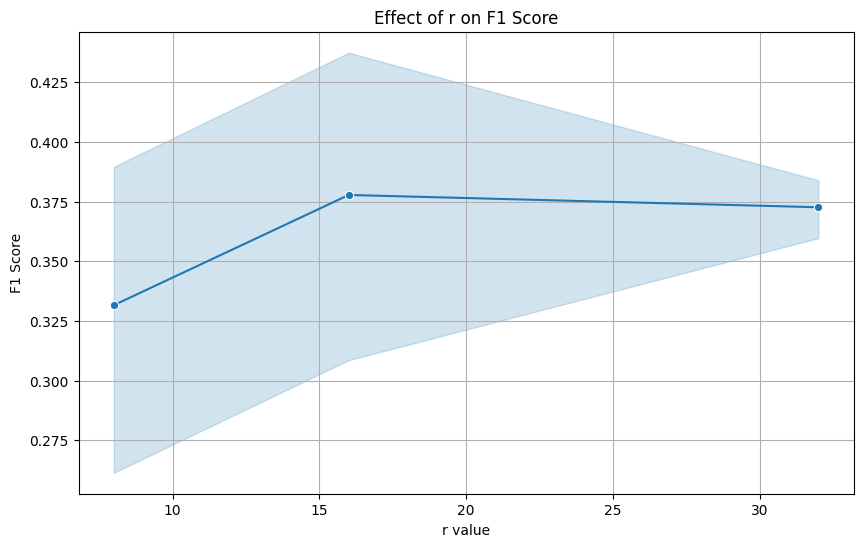

In [ ]:

df = pd.read_csv('results_cross_validation.csv')
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='r', y='eval_f1', marker='o')
plt.title('Effect of r on F1 Score')
plt.xlabel('r value')
plt.ylabel('F1 Score')
plt.grid(True)
plt.savefig('r_on_F1_Score.pdf', format='pdf')
plt.show()

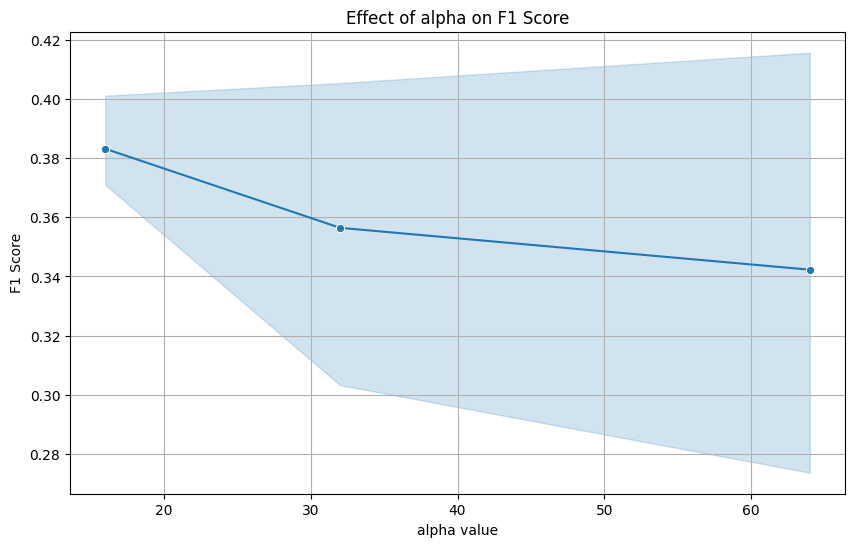

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='alpha', y='eval_f1', marker='o')
plt.title('Effect of alpha on F1 Score')
plt.xlabel('alpha value')
plt.ylabel('F1 Score')
plt.grid(True)
plt.savefig('alpha_on_F1_Score.pdf', format='pdf')
plt.show()

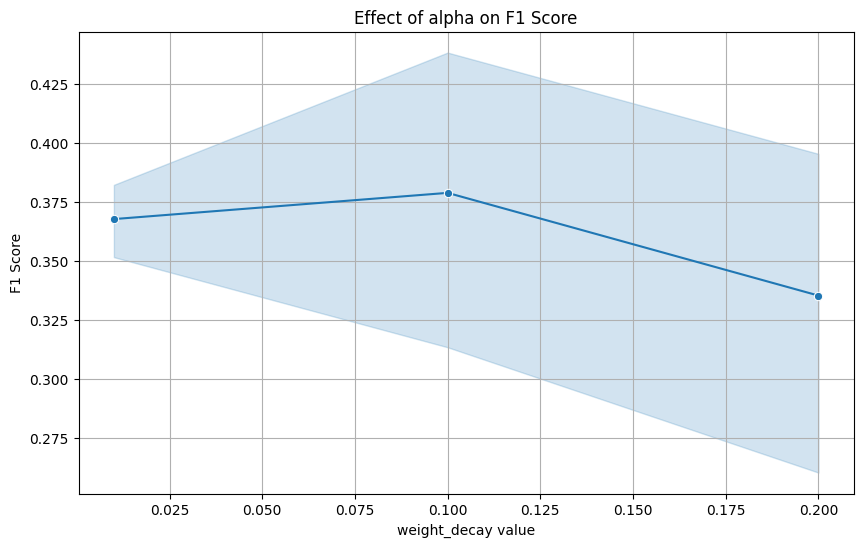

wandb: Network error (ConnectionError), entering retry loop.


In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='weight_decay', y='eval_f1', marker='o')
plt.title('Effect of alpha on F1 Score')
plt.xlabel('weight_decay value')
plt.ylabel('F1 Score')
plt.grid(True)
plt.savefig('weight_decay_on_F1_Score.pdf', format='pdf')
plt.show()